# FomulaBEAT

5桁の数字を反転するタスク

5-1をベースに変更
- タスクを5桁の数字（2進数）を反転するタスクに変更

In [1]:
version = '05-2'
model_dir = './model/' + version
data_path = f'data/eq05-2.txt'
test_data_path = f'data/eq05-2-test.txt'

## 事前定義

In [2]:
# import library
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import pandas as pd
import japanize_matplotlib

In [3]:
# 事前設定
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

Using device: cuda:0


データの取得

In [4]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [5]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_file(data_path)
print(src_data[:3], tgt_data[:3])


['00010', '01111', '10010'] ['01000', '11110', '01001']


辞書データの作成

In [6]:
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [7]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<start>': 10, '<end>': 11, '<pad>': 12, '<unk>': 13}


In [8]:
convert_text_to_indexes("01", vocab_src)


[10, 0, 1, 11]

In [9]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([10,  1,  1,  0,  1,  1, 11])
Output: tensor([10,  1,  1,  0,  1,  1, 11])
元に戻した文章
Input: 11011
Output: 11011


In [10]:
batch_size = 32
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [11]:
len(train_data)

8000

Transoformerの設定

In [12]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [13]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt

class TransformerEncoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerEncoderLayerScratch, self).__init__()
        # Self-attention for the encoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention
        memory, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        memory = src + self.dropout1(memory)
        memory = self.norm1(memory)
        
        return memory


In [14]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        self.encoder_layer = TransformerEncoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )

        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        memory = self.encoder_layer(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs/math.sqrt(self.token_embedding.embedding_size), self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [15]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [16]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [17]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [18]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [19]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(14, 4, padding_idx=12)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  

In [20]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


19 層

層名: token_embedding.embedding.weight
形状: torch.Size([14, 4])
値: Parameter containing:
tensor([[-0.4372, -0.5495,  0.0631,  0.1450],
        [-0.0600,  0.5528, -0.3975,  0.0142],
        [ 0.1810,  0.3576, -0.5460, -0.5041],
        [-0.2725, -0.2464,  0.5155, -0.2797],
        [ 0.0882, -0.0559,  0.2917, -0.2062],
        [ 0.3332,  0.0615,  0.3372, -0.2283],
        [ 0.3893,  0.3360, -0.5638,  0.1026],
        [-0.2150, -0.5511, -0.0888,  0.0458],
        [ 0.1111,  0.0252, -0.0300, -0.1914],
        [-0.0173, -0.3435,  0.5436, -0.1278],
        [ 0.3857, -0.4582, -0.2417,  0.0235],
        [-0.4217, -0.1344, -0.5387, -0.1184],
        [-0.0568, -0.5328, -0.0236, -0.1382],
        [ 0.3674,  0.3445, -0.2183, -0.0639]], device='cuda:0', requires_grad=True)

層名: encoder_layer.self_attn.in_proj_weight
形状: torch.Size([12, 4])
値: Parameter containing:
tensor([[ 0.4510, -0.0674, -0.1963,  0.2868],
        [ 0.4669,  0.0326,  0.2208, -0.1746],
        [ 0.0407,  0.2399, -0.4369,  0.46

## 学習実行

In [21]:
epoch = 50
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

# 可視化用に保存
train_losses = []
valid_losses = []

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    print('[{}/{}] train loss: {:.4f}, valid loss: {:.4f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    counter += 1
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    

  0%|          | 0/250 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 250/250 [00:03<00:00, 77.98it/s]


[1/50] train loss: 1.9470, valid loss: 1.4786  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.58it/s]


[2/50] train loss: 1.2407, valid loss: 1.0584  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.33it/s]


[3/50] train loss: 0.8657, valid loss: 0.6469  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.31it/s]


[4/50] train loss: 0.5421, valid loss: 0.4539  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.60it/s]


[5/50] train loss: 0.3953, valid loss: 0.3538  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.47it/s]


[6/50] train loss: 0.3340, valid loss: 0.3176  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.15it/s]


[7/50] train loss: 0.3051, valid loss: 0.2950  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.36it/s]


[8/50] train loss: 0.2873, valid loss: 0.2797  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.23it/s]


[9/50] train loss: 0.2729, valid loss: 0.2688  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.11it/s]


[10/50] train loss: 0.2630, valid loss: 0.2541  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.06it/s]


[11/50] train loss: 0.2528, valid loss: 0.2463  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 83.33it/s]


[12/50] train loss: 0.2444, valid loss: 0.2358  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.56it/s]


[13/50] train loss: 0.2363, valid loss: 0.2322  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.61it/s]


[14/50] train loss: 0.2333, valid loss: 0.2376  [3s] counter: 0 


100%|██████████| 250/250 [00:02<00:00, 83.83it/s]


[15/50] train loss: 0.2205, valid loss: 0.2164  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 84.19it/s]


[16/50] train loss: 0.2218, valid loss: 0.2158  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.11it/s]


[17/50] train loss: 0.2056, valid loss: 0.1948  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.44it/s]


[18/50] train loss: 0.2021, valid loss: 0.1923  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.32it/s]


[19/50] train loss: 0.1911, valid loss: 0.1829  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.31it/s]


[20/50] train loss: 0.1838, valid loss: 0.1751  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.24it/s]


[21/50] train loss: 0.1700, valid loss: 0.1635  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 81.01it/s]


[22/50] train loss: 0.1645, valid loss: 0.1530  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 80.86it/s]


[23/50] train loss: 0.1570, valid loss: 0.1645  [3s] counter: 0 


100%|██████████| 250/250 [00:03<00:00, 81.05it/s]


[24/50] train loss: 0.1494, valid loss: 0.1434  [3s] counter: 1 **


100%|██████████| 250/250 [00:03<00:00, 81.67it/s]


[25/50] train loss: 0.1473, valid loss: 0.1463  [3s] counter: 0 


100%|██████████| 250/250 [00:02<00:00, 90.20it/s] 


[26/50] train loss: 0.1468, valid loss: 0.1333  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 84.60it/s]


[27/50] train loss: 0.1464, valid loss: 0.1317  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.97it/s]


[28/50] train loss: 0.1329, valid loss: 0.1295  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.09it/s]


[29/50] train loss: 0.1385, valid loss: 0.1250  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 84.12it/s]


[30/50] train loss: 0.1323, valid loss: 0.1285  [3s] counter: 0 


100%|██████████| 250/250 [00:02<00:00, 84.06it/s]


[31/50] train loss: 0.1266, valid loss: 0.1450  [3s] counter: 1 


100%|██████████| 250/250 [00:03<00:00, 83.29it/s]


[32/50] train loss: 0.1215, valid loss: 0.1193  [3s] counter: 2 **


100%|██████████| 250/250 [00:02<00:00, 83.47it/s]


[33/50] train loss: 0.1185, valid loss: 0.1122  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.68it/s]


[34/50] train loss: 0.1110, valid loss: 0.1181  [3s] counter: 0 


100%|██████████| 250/250 [00:02<00:00, 83.53it/s]


[35/50] train loss: 0.1056, valid loss: 0.1031  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 83.71it/s]


[36/50] train loss: 0.1041, valid loss: 0.1013  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.85it/s]


[37/50] train loss: 0.1023, valid loss: 0.0925  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.77it/s]


[38/50] train loss: 0.0908, valid loss: 0.0841  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.66it/s]


[39/50] train loss: 0.0863, valid loss: 0.0803  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 83.33it/s]


[40/50] train loss: 0.0903, valid loss: 0.0741  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.43it/s]


[41/50] train loss: 0.0865, valid loss: 0.0844  [3s] counter: 0 


100%|██████████| 250/250 [00:02<00:00, 83.54it/s]


[42/50] train loss: 0.0728, valid loss: 0.0666  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 83.46it/s]


[43/50] train loss: 0.0625, valid loss: 0.0689  [3s] counter: 0 


100%|██████████| 250/250 [00:02<00:00, 83.52it/s]


[44/50] train loss: 0.0617, valid loss: 0.0527  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 83.57it/s]


[45/50] train loss: 0.0555, valid loss: 0.0446  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.37it/s]


[46/50] train loss: 0.0368, valid loss: 0.0268  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.48it/s]


[47/50] train loss: 0.0288, valid loss: 0.0250  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.67it/s]


[48/50] train loss: 0.0119, valid loss: 0.0092  [3s] counter: 0 **


100%|██████████| 250/250 [00:03<00:00, 83.32it/s]


[49/50] train loss: 0.0088, valid loss: 0.0079  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 83.40it/s]


[50/50] train loss: 0.0073, valid loss: 0.0071  [3s] counter: 0 **


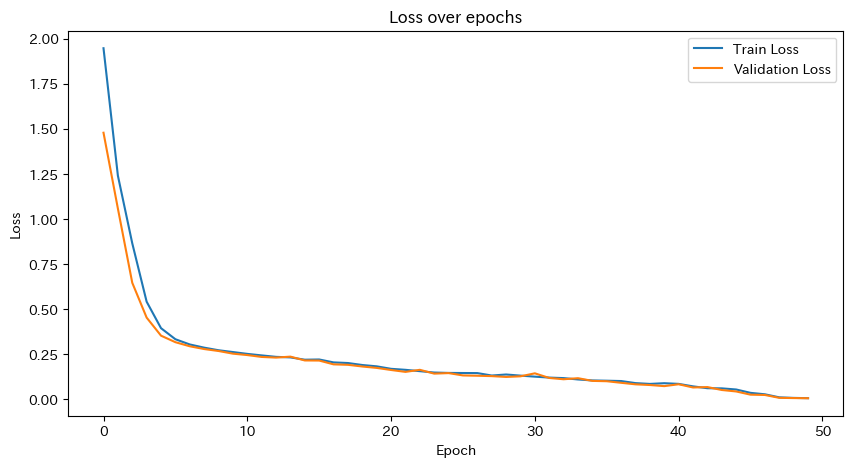

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

学習したモデルの保存

In [23]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [24]:
# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [25]:
def translate(src_sentence, model=loaded_model, vocab_src=vocab_src, vocab_tgt=vocab_tgt, max_len=50):
    model.eval()
    
    # 数値化されたソース文を生成
    src_indexes = torch.tensor([convert_text_to_indexes(src_sentence, vocab_src)], device=device).transpose(0, 1)

    # 初期ターゲット文に <start> トークンを設定
    tgt_indexes = torch.tensor([START_IDX], device=device).unsqueeze(1)

    memory = model.positional_encoding(model.token_embedding(src_indexes))
    memory = model.encoder_layer(memory)

    for _ in range(max_len):
        # デコード
        output = model.decode(tgt_indexes, memory, generate_square_subsequent_mask(tgt_indexes.size(0)))
        next_token = model.compute_output(output)[-1, :].argmax(1).item()

        # 予測トークンをターゲット文に追加
        tgt_indexes = torch.cat([tgt_indexes, torch.tensor([[next_token]], device=device)], dim=0)

        # <end> トークンで終了
        if next_token == END_IDX:
            break

    # インデックスから文字列に変換
    return convert_indexes_to_text(tgt_indexes.squeeze(1).tolist(), vocab_tgt)

In [26]:
text = "11101"
translation = translate(text)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: 11101
Output: 10111


In [27]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        return [tuple(line.strip().split(' => ')) for line in file.readlines()]

def calculate_test_accuracy(test_data):
    # テストデータの読み込み
    correct, mistakes = 0, []
    num_test_data = len(test_data)
    for i, (src_text, tgt_text) in enumerate(test_data):
        print(f'{i/num_test_data*100:.2f}%', end='\r')
        translation = translate(src_text)
        if translation == tgt_text:
            correct += 1
        else:
            mistakes.append((src_text, translation, tgt_text))
    return correct/num_test_data, mistakes

# 正答率の計算
test_data = read_file(test_data_path)
accuracy, mistakes = calculate_test_accuracy(test_data)

# 正答率の表示
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Mistakes: {len(mistakes)} out of {len(test_data)}")

# 間違えたケースの一部（10件まで）を表示
print("\nExamples of mistakes:")
for i, (src_text, translation, tgt_text) in enumerate(mistakes[:10]):
    print(f"Input  : {src_text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt_text}")
    print('---')


Test Accuracy: 1.00%
Mistakes: 0 out of 5000

Examples of mistakes:


## モデルの動作を分析

### 初期設定

In [21]:
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')

#loaded_model用のSeq2Seqクラス
class Seq2SeqForSavedModel(Seq2SeqTransformer):
    def __init__(self, *args, **kwargs):
        super(Seq2SeqForSavedModel, self).__init__(*args, **kwargs)
        self.pca = None

    def positional_encoding(self, tensor: Tensor, maxlen=5000):
        embedding_size = tensor.size(-1)
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)
        return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)
    
    def self_attn_decoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.decoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.decoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.decoder_layer.self_attn.out_proj.weight.data.T) + self.decoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights

    def self_attn_encoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.encoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.encoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.encoder_layer.self_attn.out_proj.weight.data.T) + self.encoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights
    
    def cross_attn(self, tgt, memory, embedding_size):
        multi_attn_wq, multi_attn_wk, multi_attn_wv = self.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = self.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
        KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(multi_attn_weights, VW)
        multi_attn_output = torch.matmul(AV, self.decoder_layer.cross_attn.out_proj.weight.data.T) + self.decoder_layer.cross_attn.out_proj.bias.data
        return tgt + multi_attn_output.permute(1, 0, 2), multi_attn_output.permute(1, 0, 2), multi_attn_weights

    def predict_next_token(self, src, tgt, embedding_size=embedding_size, device=device):
        memory = self.positional_encoding(self.token_embedding(src))
        tgt_embed = self.positional_encoding(self.token_embedding(tgt))
        tgt_mask = generate_square_subsequent_mask(tgt.size(0)).to(device).type(torch.bool)

        memory, _, _ = self.self_attn_encoder(memory, embedding_size)
        memory = self.encoder_layer.norm1(memory)

        tgt, _, self_attn_weights = self.self_attn_decoder(tgt_embed, embedding_size)
        tgt = self.decoder_layer.norm1(tgt)
        tgt, _, multi_attn_weights = self.cross_attn(tgt, memory, embedding_size)
        tgt = self.decoder_layer.norm2(tgt)
        output = self.compute_output(tgt.transpose(0, 1)[:, -1])

        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        return next_word, self_attn_weights, multi_attn_weights
    


In [22]:
# モデルの初期化
loaded_model = Seq2SeqForSavedModel(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqForSavedModel(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(14, 4, padding_idx=12)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)


In [23]:
# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())
for k, v in params.items():
    print(k, v.shape)

token_embedding.embedding.weight torch.Size([14, 4])
encoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
encoder_layer.self_attn.in_proj_bias torch.Size([12])
encoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
encoder_layer.self_attn.out_proj.bias torch.Size([4])
encoder_layer.norm1.weight torch.Size([4])
encoder_layer.norm1.bias torch.Size([4])
decoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.self_attn.in_proj_bias torch.Size([12])
decoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.self_attn.out_proj.bias torch.Size([4])
decoder_layer.cross_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.cross_attn.in_proj_bias torch.Size([12])
decoder_layer.cross_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.cross_attn.out_proj.bias torch.Size([4])
decoder_layer.norm1.weight torch.Size([4])
decoder_layer.norm1.bias torch.Size([4])
decoder_layer.norm2.weight torch.Size([4])
decoder_layer.norm2.bias torch.Size([4])


#### テスト実行


In [24]:
text = '11101'

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

for _ in range(seq_len_tgt):
    next_token, _, _ = loaded_model.predict_next_token(src, ys)
    ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=0)
    if next_token == END_IDX:
        break

print(f"Input: {text}")
print(f"Output: {convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)}")

Input: 11101
Output: 10111


#### PCA、UMAPでの関数plotの定義

In [25]:
reverse_vocab = {idx: token for token, idx in vocab_tgt.items()}

# PCA plot関数（loaded_modelのpcaを利用）
def plot_pca_zero_one(zero_vectors, one_vectors, model=loaded_model, withEnv=True, label1="zero", label2="one", title="title"):
    all_vectors = np.vstack((zero_vectors, one_vectors))
    pca = PCA(n_components=2)
    src = torch.LongTensor(list(vocab_src.values())).to(device)
    token_embedding = model.token_embedding(src).detach().cpu().numpy()
    pca.fit(token_embedding)
    reduced_vectors = pca.transform(all_vectors)
    reduced_embedding = pca.transform(token_embedding)
    plt.figure(figsize=(10, 7))
    # 偶数データをプロット
    plt.scatter(
        reduced_vectors[:len(zero_vectors), 0],  # 偶数のx座標
        reduced_vectors[:len(zero_vectors), 1],  # 偶数のy座標
        alpha=0.2, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        reduced_vectors[len(zero_vectors):, 0],  # 奇数のx座標
        reduced_vectors[len(zero_vectors):, 1],  # 奇数のy座標
        alpha=0.2, label=label2, color='red'
    )

    # 埋め込みデータのプロット
    if withEnv:
        for i, (x, y) in enumerate(reduced_embedding):
            plt.scatter(x, y, alpha=0.2)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(int(reduced_embedding[:, 0].min()) - 1, int(reduced_embedding[:, 0].max()) + 2, 1)) 
    plt.yticks(np.arange(int(reduced_embedding[:, 1].min()) - 1, int(reduced_embedding[:, 1].max()) + 2, 1)) 
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.show()

# UMAP plot関数
def plot_umap_zero_one(zero_vectors, one_vectors, model=loaded_model, withEnv=True, label1="zero", label2="one", n_neighbors=30, title="title"):
    all_vectors = np.vstack((zero_vectors, one_vectors))
    umap_model = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
    reduced_vectors = umap_model.fit_transform(all_vectors)
    plt.figure(figsize=(10, 7))
    # 偶数データをプロット
    plt.scatter(
        reduced_vectors[:len(zero_vectors), 0],  # 偶数のx座標
        reduced_vectors[:len(zero_vectors), 1],  # 偶数のy座標
        alpha=0.2, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        reduced_vectors[len(zero_vectors):, 0],  # 奇数のx座標
        reduced_vectors[len(zero_vectors):, 1],  # 奇数のy座標
        alpha=0.2, label=label2, color='red'
    )

    # 埋め込みデータのプロット
    if withEnv:
        reduced_embedding = umap_model.transform(model.token_embedding.embedding.weight.detach().cpu().numpy())
        for i, (x, y) in enumerate(reduced_embedding):
            plt.scatter(x, y, alpha=0.2)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()


# 最初の4次元を可視化する関数
def plot_map_zero_one(zero_vectors, one_vectors, model=loaded_model, withEnv=True, label1="zero", label2="one", title="title"):
    src = torch.LongTensor(list(vocab_src.values())).to(device)
    token_embedding = model.token_embedding(src).detach().cpu().numpy()

    plt.figure(figsize=(10, 7))
    # 偶数データをプロット
    plt.scatter(
        zero_vectors[:, 0],  # 偶数のx座標
        zero_vectors[:, 1],  # 偶数のy座標
        alpha=0.2, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        one_vectors[:, 0],  # 奇数のx座標
        one_vectors[:, 1],  # 奇数のy座標
        alpha=0.2, label=label2, color='red'
    )
    # 埋め込みデータのプロット
    if withEnv:
        for i, (x, y) in enumerate(token_embedding[:, :2]):
            plt.scatter(x, y, alpha=0.2)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title+" (First 2 dimensions)")
    plt.xlabel("1st dimension")
    plt.ylabel("2nd dimension")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(int(token_embedding[:, 0].min()) - 1, int(token_embedding[:, 0].max()) + 2, 1))
    plt.yticks(np.arange(int(token_embedding[:, 1].min()) - 1, int(token_embedding[:, 1].max()) + 2, 1))
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 7))

    plt.scatter(
        zero_vectors[:, 2],  # 偶数のx座標
        zero_vectors[:, 3],  # 偶数のy座標
        alpha=0.2, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        one_vectors[:, 2],  # 奇数のx座標
        one_vectors[:, 3],  # 奇数のy座標
        alpha=0.2, label=label2, color='red'
    )
    # 埋め込みデータのプロット
    if withEnv:
        for i, (x, y) in enumerate(token_embedding[:, 2:4]):
            plt.scatter(x, y, alpha=0.2)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title+" (Last 2 dimensions)")
    plt.xlabel("3rd dimension")
    plt.ylabel("4th dimension")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(int(token_embedding[:, 2].min()) - 1, int(token_embedding[:, 2].max()) + 2, 1))
    plt.yticks(np.arange(int(token_embedding[:, 3].min()) - 1, int(token_embedding[:, 3].max()) + 2, 1))
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.show()

def plot_heatmap(attention_map, src_label=[], ys_label=[], title="Attention Map"):
    # ヒートマップとしてAttentionを描画
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_map, annot=False, cmap='viridis', cbar=True)
    plt.title(title)
    xticks = [f"{src_label[i]}" for i in range(len(src_label))]
    yticks = [f"{ys_label[i]}" for i in range(len(ys_label))]
    plt.xticks(ticks=np.arange(len(src_label))+0.5, labels=xticks, rotation=0)
    plt.yticks(ticks=np.arange(len(ys_label))+0.5, labels=yticks, rotation=0)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.show()

def plot_stripplot(zero_output, one_output):
    zero_df = pd.DataFrame(zero_output, columns=[reverse_vocab[i] for i in range(0, len(zero_output[0]))])
    zero_df['type'] = 'zero'
    one_df = pd.DataFrame(one_output, columns=[reverse_vocab[i] for i in range(0, len(one_output[0]))])
    one_df['type'] = 'one'
    df = pd.concat([zero_df, one_df])
    df = df.melt(id_vars='type', var_name='token', value_name='probability')

    plt.figure(figsize=(10, 5))
    sns.stripplot(data=df, x='token', y='probability', hue='type', jitter=0.2, dodge=True)
    plt.title("Output Probability")
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.legend(title="Type")
    plt.show()

def plot_pairplot(zero_output, one_output):
    zero_df = pd.DataFrame(zero_output, columns=[f"d{i}" for i in range(zero_output.shape[1])])
    zero_df['type'] = 'zero'
    one_df = pd.DataFrame(one_output, columns=[f"d{i}" for i in range(one_output.shape[1])])
    one_df['type'] = 'one'
    df = pd.concat([zero_df, one_df], ignore_index=True)

    plt.figure(figsize=(10, 5))
    sns.pairplot(df, hue='type', diag_kind='kde', plot_kws={'alpha': 0.2})
    plt.suptitle("Pair Plot")
    plt.show()



### 調査１：最初の文字生成の処理を調べる

#### 初期設定

In [26]:
import random

# 最後の文字が0または1のデータをランダムに生成
def generate_random_data_last_digit_0_1(num_samples=100):
    zero_data = []
    one_data = []
    for _ in range(num_samples):
        # 最後の文字が0
        zero_number = ''.join(str(random.randint(0, 1)) for _ in range(4)) + '0'
        # 最後の文字が1
        one_number = ''.join(str(random.randint(0, 1)) for _ in range(4)) + '1'
        zero_data.append(zero_number)
        one_data.append(one_number)
    return zero_data, one_data

# ランダムなデータを生成
zero_data, one_data = generate_random_data_last_digit_0_1()

zero_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in zero_data]
one_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in one_data]

# 確認
print("Examples of random data ending with 0:", zero_data[:5])
print("Examples of random data ending with 1:", one_data[:5])


Examples of random data ending with 0: ['01000', '00110', '10100', '01000', '01000']
Examples of random data ending with 1: ['01101', '01101', '11001', '01101', '10111']


In [27]:
# 1個目の出力までを取得
text = zero_data[0]

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

for _ in range(0):
    next_token, _, _ = loaded_model.predict_next_token(src, ys)
    ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=0)
print(ys)

tensor([[10]], device='cuda:0')


#### Encoder: Memory Emb + PEを図示

In [ ]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory_emb = model.positional_encoding(model.token_embedding(src))
        vectors.append(memory_emb.detach().cpu().numpy()[1:6, :, :].reshape(-1, embedding_size))
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model).reshape(500, embedding_size)
one_vectors_ca = extract_vectors(one_src, loaded_model).reshape(500, embedding_size)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

#### Encoder: Self-Attention + yを図示

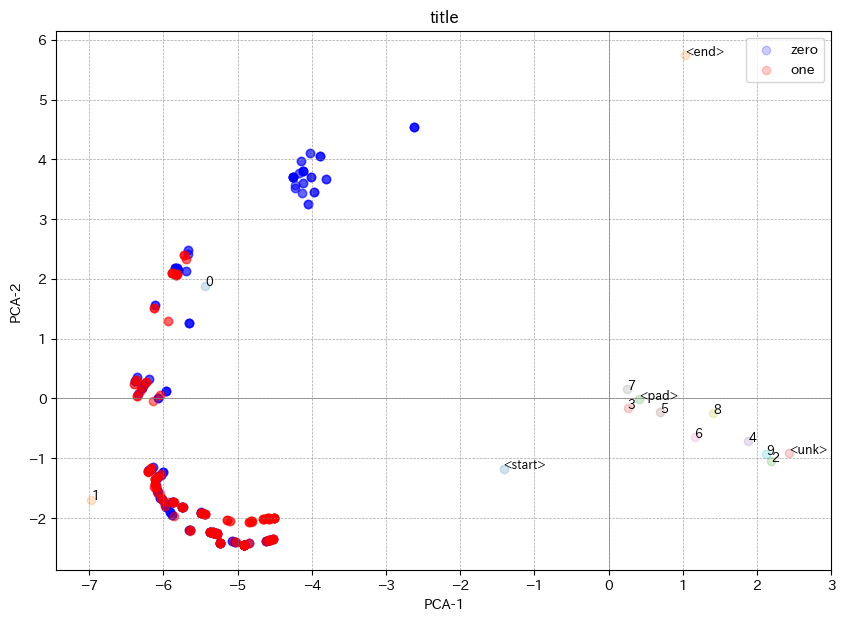

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


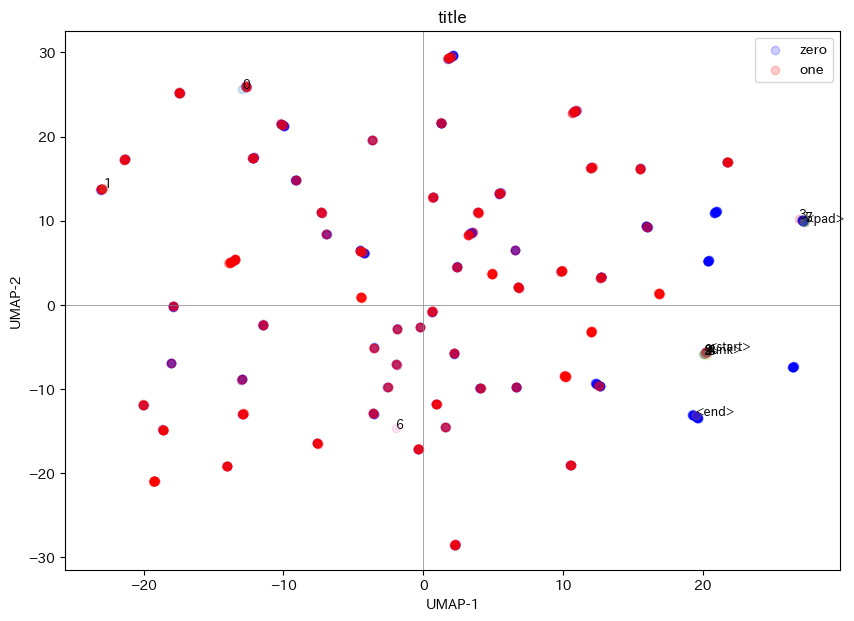

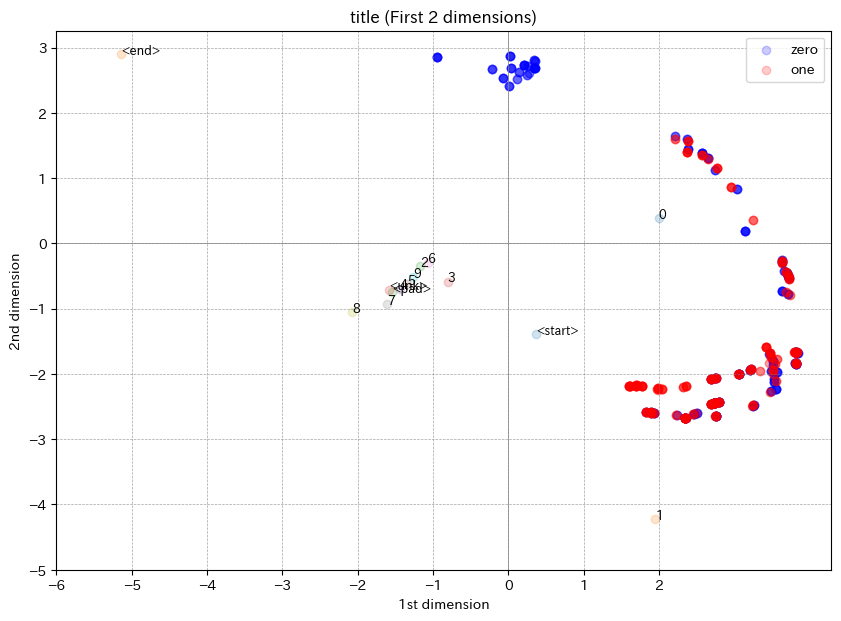

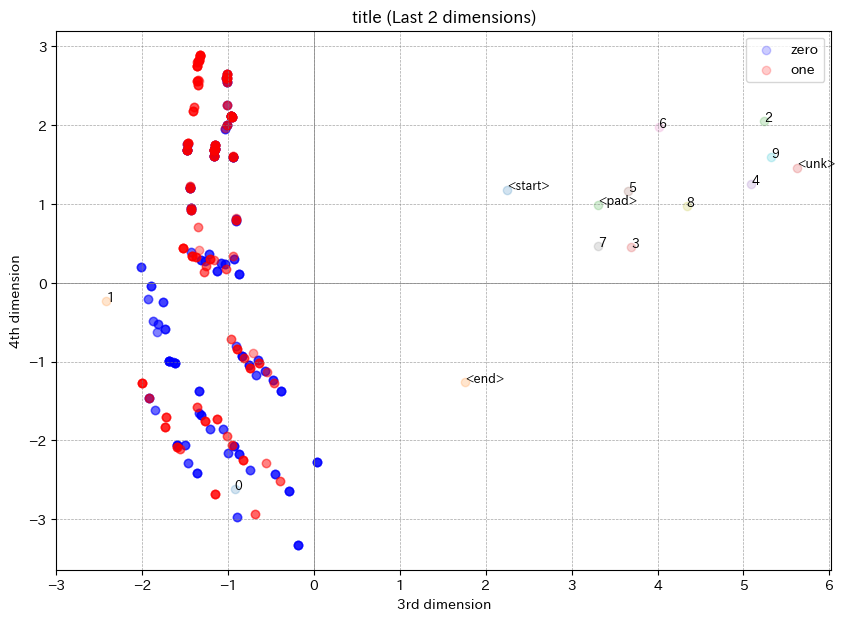

<Figure size 1000x500 with 0 Axes>

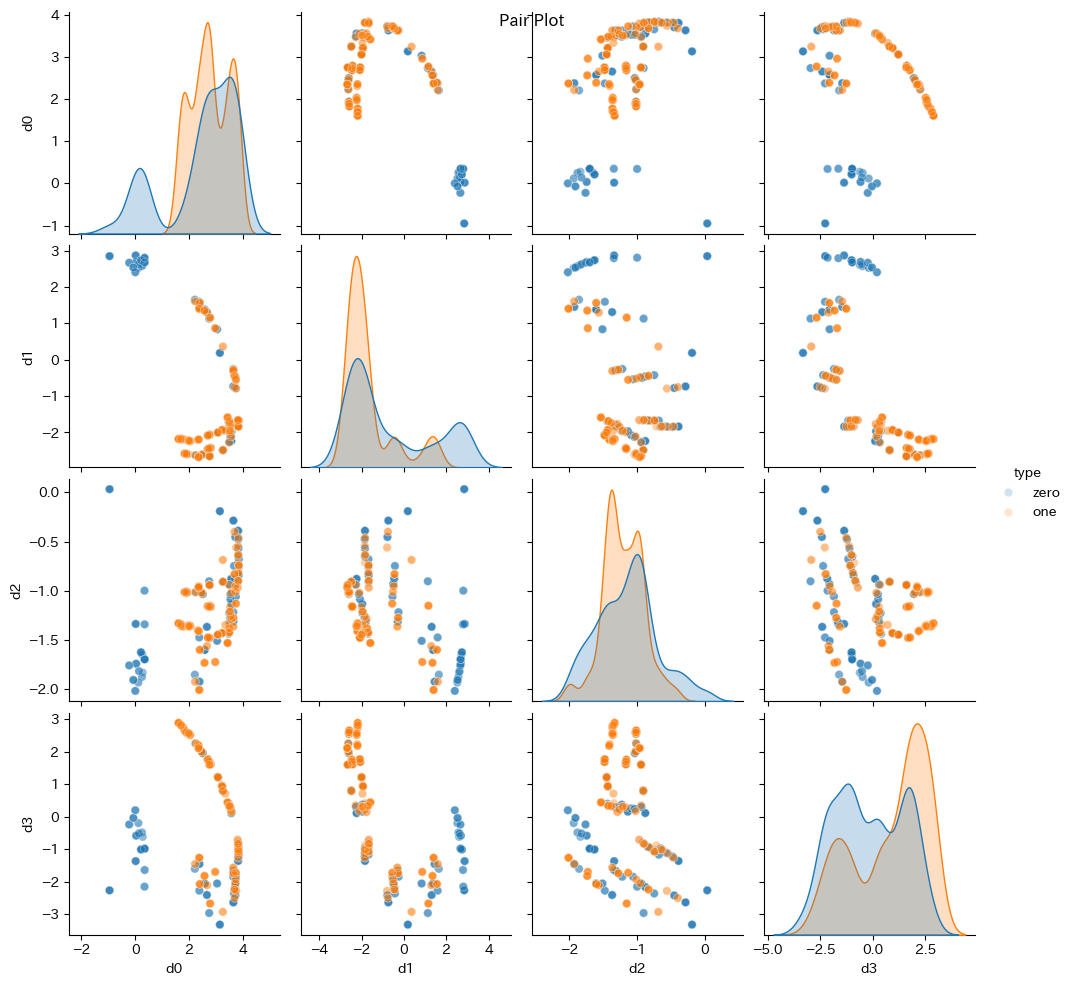

In [30]:

def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        vectors.append(memory.detach().cpu().numpy().reshape(-1, embedding_size))
    vectors_array = np.array(vectors)
    return vectors_array

# self-attentionのベクトルを抽出
zero_vectors_sa = extract_self_attention_vectors(zero_src, loaded_model)
one_vectors_sa = extract_self_attention_vectors(one_src, loaded_model)
zero_vectors_sa_squeezed = zero_vectors_sa[:, 1:6, :].reshape(-1, embedding_size)
one_vectors_sa_squeezed = one_vectors_sa[:, 1:6, :].reshape(-1, embedding_size)

plot_pca_zero_one(zero_vectors_sa_squeezed, one_vectors_sa_squeezed)
plot_umap_zero_one(zero_vectors_sa_squeezed, one_vectors_sa_squeezed)
plot_map_zero_one(zero_vectors_sa_squeezed, one_vectors_sa_squeezed)
plot_pairplot(zero_vectors_sa_squeezed, one_vectors_sa_squeezed)

In [ ]:
print(zero_vectors_sa.shape)
for i in range(7):
    plot_pca_zero_one(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :], title=f"SA Layer {i+1}th token")
    # plot_umap_zero_one(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :], title=f"SA Layer {i+1}th token")
    plot_map_zero_one(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :], title=f"SA Layer {i+1}th token")
    plot_pairplot(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :])

#### Decoder: Self-Attention + yを図示

In [ ]:

def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        vectors.append(tgt.detach().cpu().numpy().squeeze())  # 平均化して次元を整える
    vectors_array = np.array(vectors)
    return vectors_array

# self-attentionのベクトルを抽出
zero_vectors_sa = extract_self_attention_vectors(zero_src, loaded_model)
one_vectors_sa = extract_self_attention_vectors(one_src, loaded_model)


plot_pca_zero_one(zero_vectors_sa, one_vectors_sa)
plot_umap_zero_one(zero_vectors_sa, one_vectors_sa)
plot_map_zero_one(zero_vectors_sa, one_vectors_sa)

#### Cross-AttentionのAttention Weightを図示

In [ ]:

# Cross-AttentionのAttentionWeightの出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, tgt_, attention_weight = model.cross_attn(tgt, memory, embedding_size)
        vectors.append(attention_weight.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array
    

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False, n_neighbors=20)
plot_pairplot(zero_vectors_ca, one_vectors_ca)



In [ ]:
# Cross AttentionのAttentionWeightのヒートマップを表示
plot_heatmap(zero_vectors_ca, title="Attention Weight (Zero)")
plot_heatmap(one_vectors_ca, title="Attention Weight (One)")

#### Cross-AttentionのVw*memoryを図示


特に、AttentionWeightが多いindex5を可視化

In [ ]:
# Vw*memのindex5を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # Cross Attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        VW = torch.matmul(VW, model.decoder_layer.cross_attn.out_proj.weight.data.T)
        index5 = VW[:, 5, :]
        vectors.append(index5.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)


次にindex = 4を可視化。ちなみにindex4は赤青は関係ないので、実際意味がないが、確かめるために試す

In [ ]:
# Vw*memのindex4を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # Cross Attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        VW = torch.matmul(VW, model.decoder_layer.cross_attn.out_proj.weight.data.T)
        index5 = VW[:, 4, :]
        vectors.append(index5.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array


# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pairplot(zero_vectors_ca, one_vectors_ca)


#### Vw*Memがそれぞれ何を表しているかを示す

In [ ]:
# 特にまとまっているOne-vectorについてVw*memを示す
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    VWxmems = []
    ca_vectors = []
    attn_maps = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # Cross Attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        VWxmem = torch.matmul(VW, model.decoder_layer.cross_attn.out_proj.weight.data.T)+ model.decoder_layer.cross_attn.out_proj.bias.data
        VWxmem = model.decoder_layer.norm2(VWxmem)
        VWxmems.append(VWxmem.detach().cpu().numpy().squeeze())

        _, ca, attn_map = model.cross_attn(tgt, memory, embedding_size)
        ca = model.decoder_layer.norm2(ca)
        ca_vectors.append(ca.detach().cpu().numpy().squeeze())
        attn_maps.append(attn_map.detach().cpu().numpy().squeeze())

    VWxmems = np.array(VWxmems)
    ca_vectors = np.array(ca_vectors)
    attn_maps = np.array(attn_maps)
    return VWxmems, ca_vectors, attn_maps

# 偶数と奇数のCross Attention後のベクトルリストを取得
VWxmems_one, ca_vectors_one, attn_maps_one = extract_vectors(one_src, loaded_model)
VWxmems_zero, ca_vectors_zero, attn_maps_zero = extract_vectors(zero_src, loaded_model)
print(VWxmems_one.shape, ca_vectors_one.shape, attn_maps_one.shape)
VWxmems_one, ca_vectors_one, attn_maps_one = VWxmems_one.mean(axis=0), ca_vectors_one.mean(axis=0), attn_maps_one.mean(axis=0)
VWxmems_zero, ca_vectors_zero, attn_maps_zero = VWxmems_zero.mean(axis=0), ca_vectors_zero.mean(axis=0), attn_maps_zero.mean(axis=0)

# Attention mapを表示
plot_heatmap([attn_maps_one], title="Attention Map (One)", src_label="sxxxx1e", ys_label="s")
plot_heatmap([attn_maps_zero], title="Attention Map (Zero)", src_label="sxxxx0e", ys_label="s")


In [ ]:

embedding_weight = loaded_model.token_embedding.embedding.weight.data.detach().cpu().numpy()
embedding_size = loaded_model.token_embedding.embedding_size
labels = [reverse_vocab[i] for i in range(0, len(reverse_vocab))]

# Vwxmemと埋め込みベクトルの類似度を計算
print(embedding_weight.shape)
similarity_one = np.matmul(VWxmems_one/math.sqrt(embedding_size), embedding_weight.T)
similarity_zero = np.matmul(VWxmems_zero/math.sqrt(embedding_size), embedding_weight.T)

print(similarity_one.shape, similarity_zero.shape)
plot_heatmap(similarity_one, title="Vw*memoryの出力がどの埋め込みベクトルに似ているかをヒートマップ", src_label=labels, ys_label="sxxxx1e")
plot_heatmap(similarity_zero, title="Vw*memoryの出力がどの埋め込みベクトルに似ているかをヒートマップ", src_label=labels, ys_label="sxxxx0e")

In [ ]:
# CAの最終出力と埋め込みベクトルの類似度を計算
print(embedding_weight.shape)
similarity_one = np.matmul(ca_vectors_one/math.sqrt(embedding_size), embedding_weight.T)
similarity_zero = np.matmul(ca_vectors_zero/math.sqrt(embedding_size), embedding_weight.T)

plot_heatmap([similarity_one], title="CA出力の平均と埋め込みベクトルの類似度のヒートマップ", src_label=labels)
plot_heatmap([similarity_zero], title="CA出力の平均と埋め込みベクトルの類似度のヒートマップ", src_label=labels)

#### Cross-Attentionを図示

In [ ]:

# Cross Attention後の出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        _, tgt, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt)
        vectors.append(tgt.transpose(0, 1)[:, -1].detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

#### Cross-Attention + yを図示

In [ ]:

# Cross Attention後の出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt[:, -1])
        vectors.append(tgt.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

#### 最終の確率を図示

In [ ]:
# 結果の出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt)
        output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(output.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
plot_stripplot(zero_vectors_ca, one_vectors_ca)
plot_stripplot(zero_vectors_ca[:, :2], one_vectors_ca[:, :2])

### 調査2：3つ目の文字生成処理を調べる

#### 初期設定

In [31]:
import random

# 最後の文字が0または1のデータをランダムに生成
def generate_random_data_last_digit_0_1(num_samples=100):
    zero_data = []
    one_data = []
    for _ in range(num_samples):
        # 最後の文字が0
        zero_number = ''.join(str(random.randint(0, 1)) for _ in range(2)) + '010'
        # 最後の文字が1
        one_number = ''.join(str(random.randint(0, 1)) for _ in range(2)) + '110'
        zero_data.append(zero_number)
        one_data.append(one_number)
    return zero_data, one_data

# ランダムなデータを生成
zero_data, one_data = generate_random_data_last_digit_0_1()

zero_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in zero_data]
one_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in one_data]

# 確認
print("Examples of random data ending with 0:", zero_data[:5])
print("Examples of random data ending with 1:", one_data[:5])

Examples of random data ending with 0: ['11010', '01010', '10010', '11010', '10010']
Examples of random data ending with 1: ['01110', '00110', '10110', '01110', '10110']


In [32]:
# 4個目の出力までを取得

text = zero_data[0]

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

for _ in range(2):
    next_token, _, _ = loaded_model.predict_next_token(src, ys)
    ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=0)
print(ys)

tensor([[10],
        [ 0],
        [ 1]], device='cuda:0')


#### Encoder: Memory Emb + PEを図示

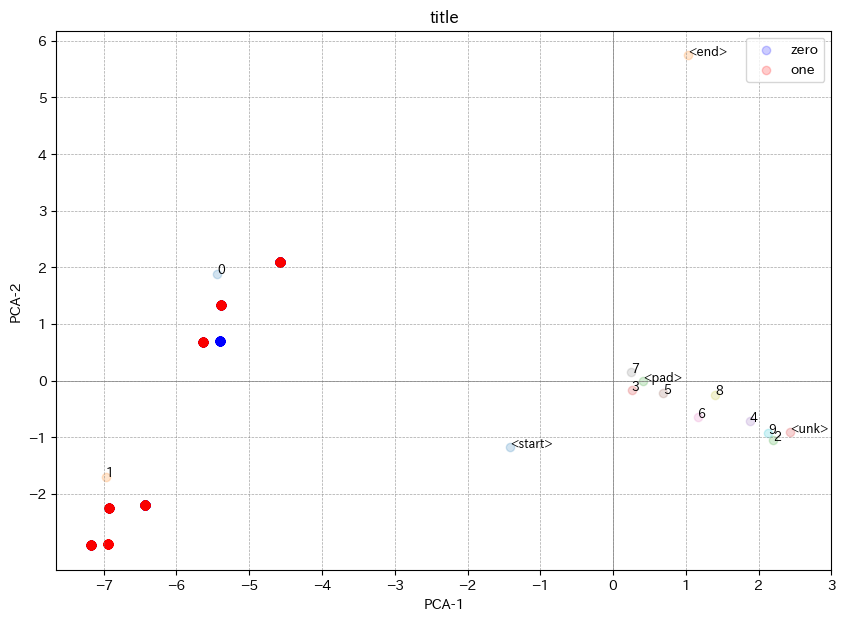

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


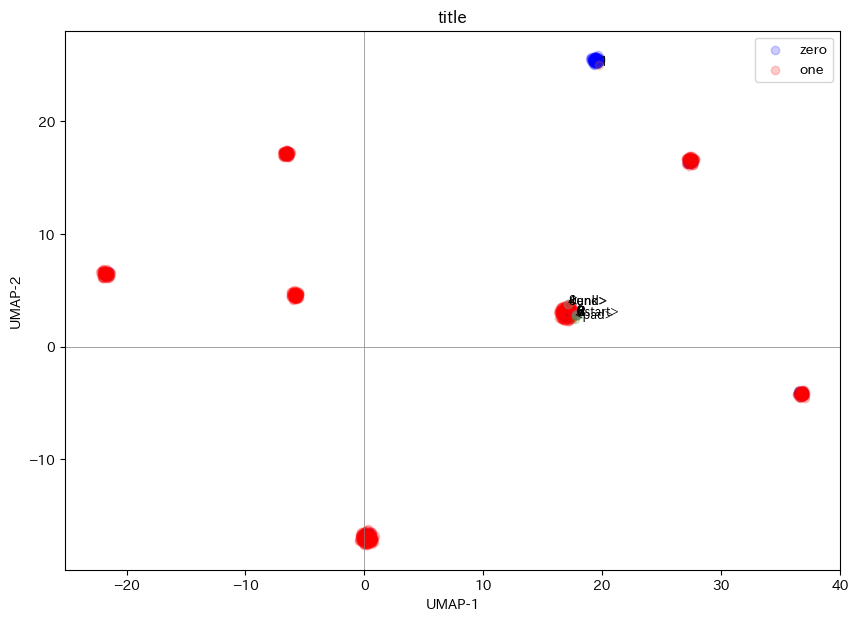

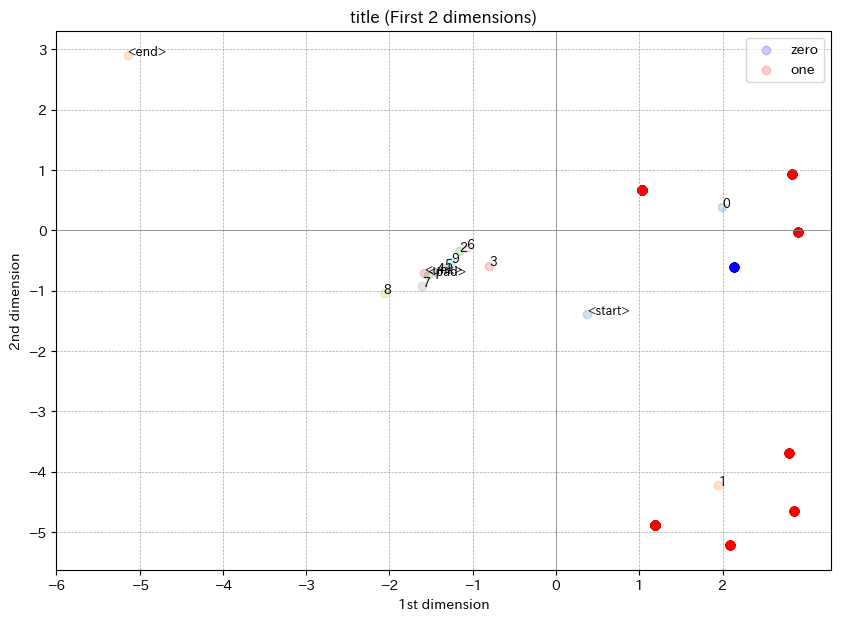

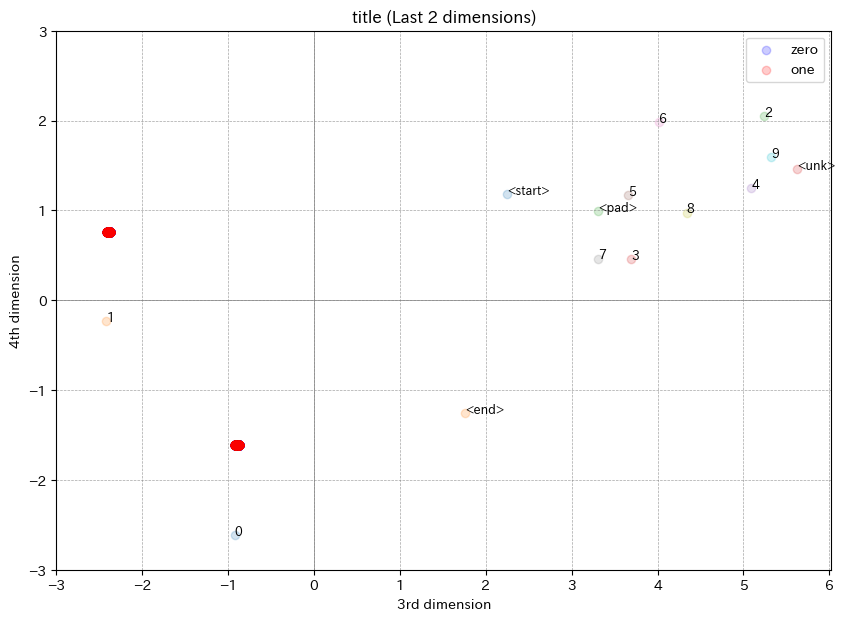

<Figure size 1000x500 with 0 Axes>

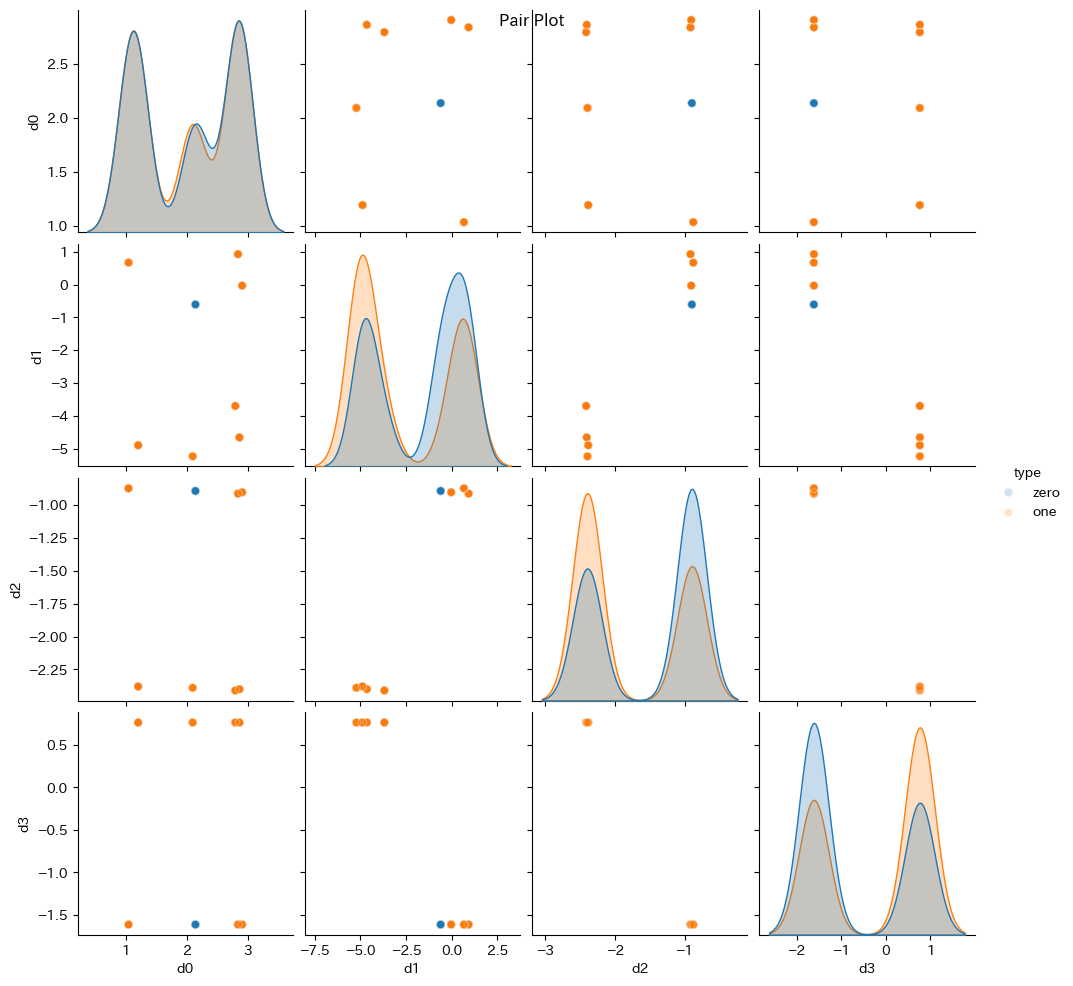

In [39]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory_emb = model.positional_encoding(model.token_embedding(src))
        vectors.append(memory_emb.detach().cpu().numpy()[1:6, :, :].reshape(-1, embedding_size))
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model).reshape(500, embedding_size)
one_vectors_ca = extract_vectors(one_src, loaded_model).reshape(500, embedding_size)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

#### Encoder: Self-Attentionの重みを可視化

(7, 7)


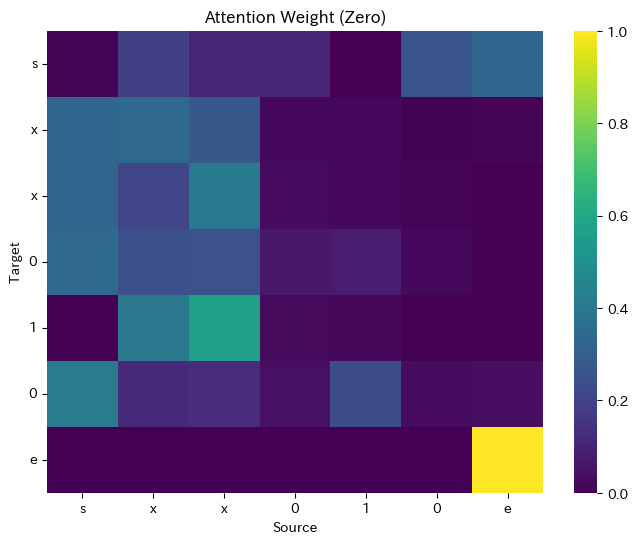

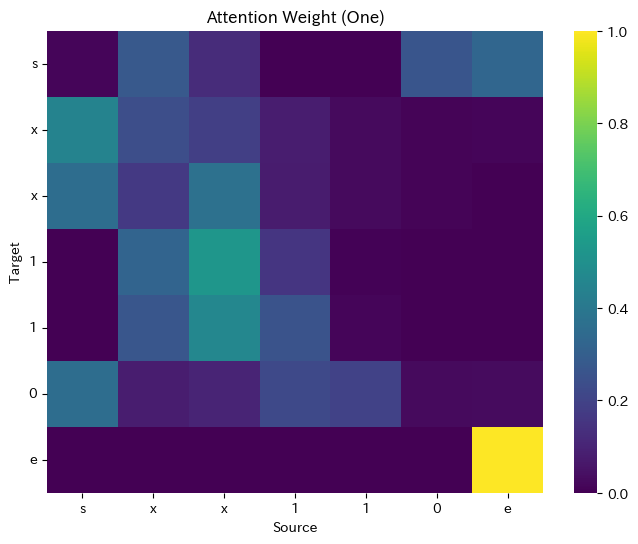

In [66]:
def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    attn_maps = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory = model.positional_encoding(model.token_embedding(src))
        _, _, attn_map = model.self_attn_encoder(memory, embedding_size)
        attn_maps.append(attn_map.detach().cpu().numpy())
    attn_maps = np.array(attn_maps)
    return attn_maps

# self-attentionのベクトルを抽出
zero_vectors_sa = extract_self_attention_vectors(zero_src, loaded_model).mean(axis=0).squeeze()
one_vectors_sa = extract_self_attention_vectors(one_src, loaded_model).mean(axis=0).squeeze()

# Cross AttentionのAttentionWeightのヒートマップを表示
print(zero_vectors_sa.shape)
plot_heatmap(zero_vectors_sa, title="Attention Weight (Zero)", src_label="sxx010e", ys_label="sxx010e")
plot_heatmap(one_vectors_sa, title="Attention Weight (One)", src_label="sxx110e", ys_label="sxx110e")

#### Encoder: Self-Attention + yを図示

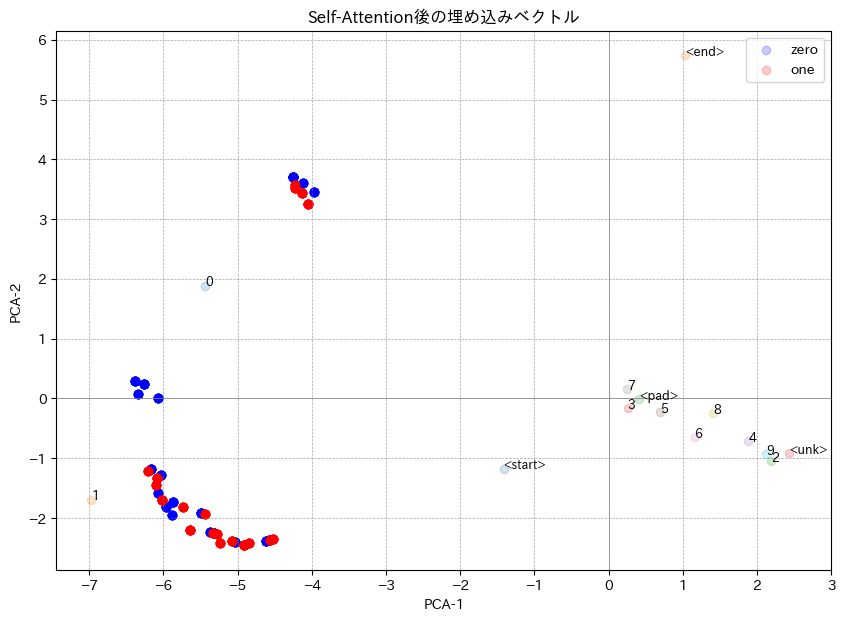

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


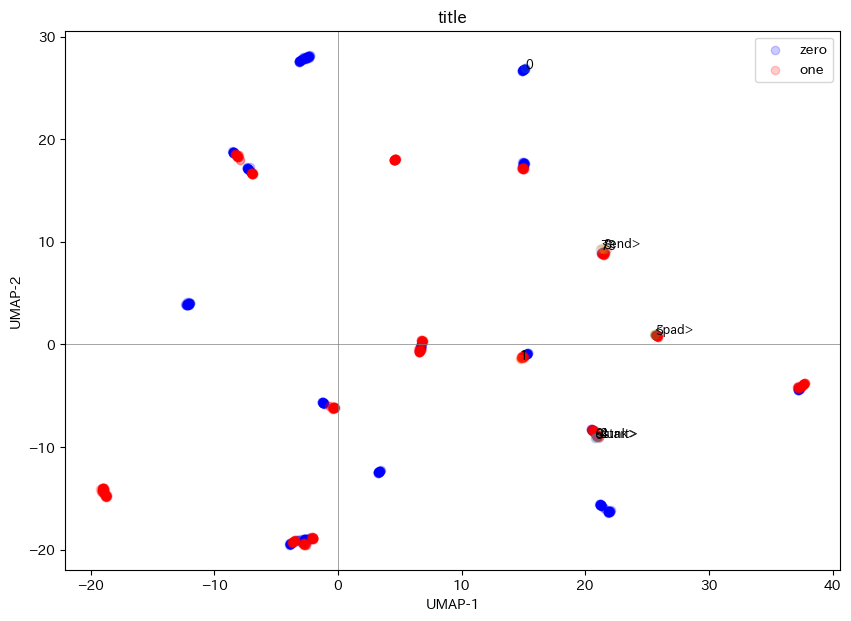

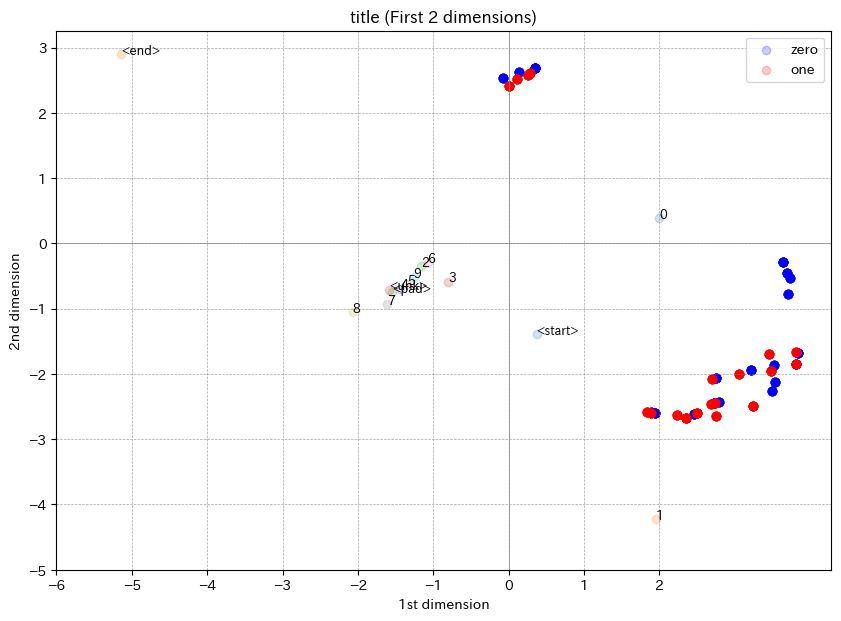

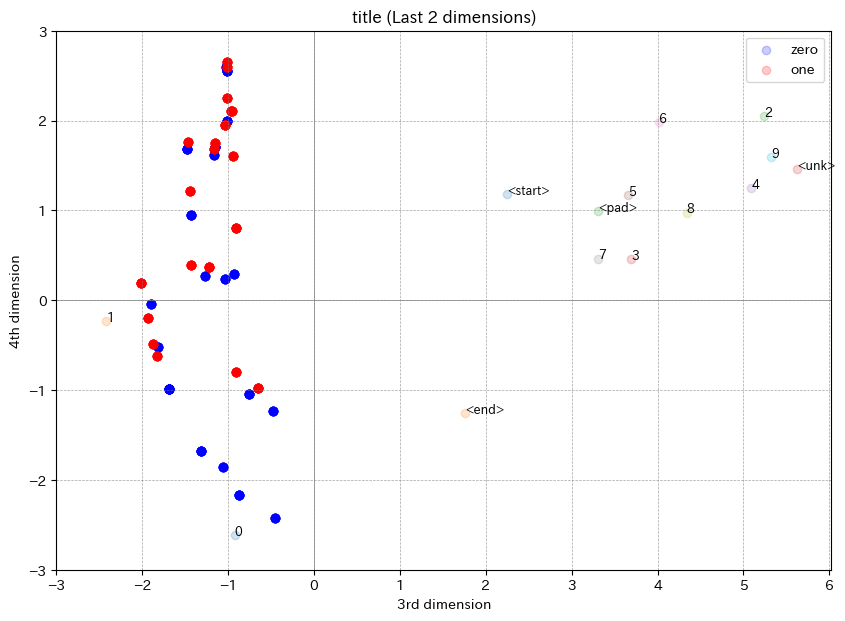

<Figure size 1000x500 with 0 Axes>

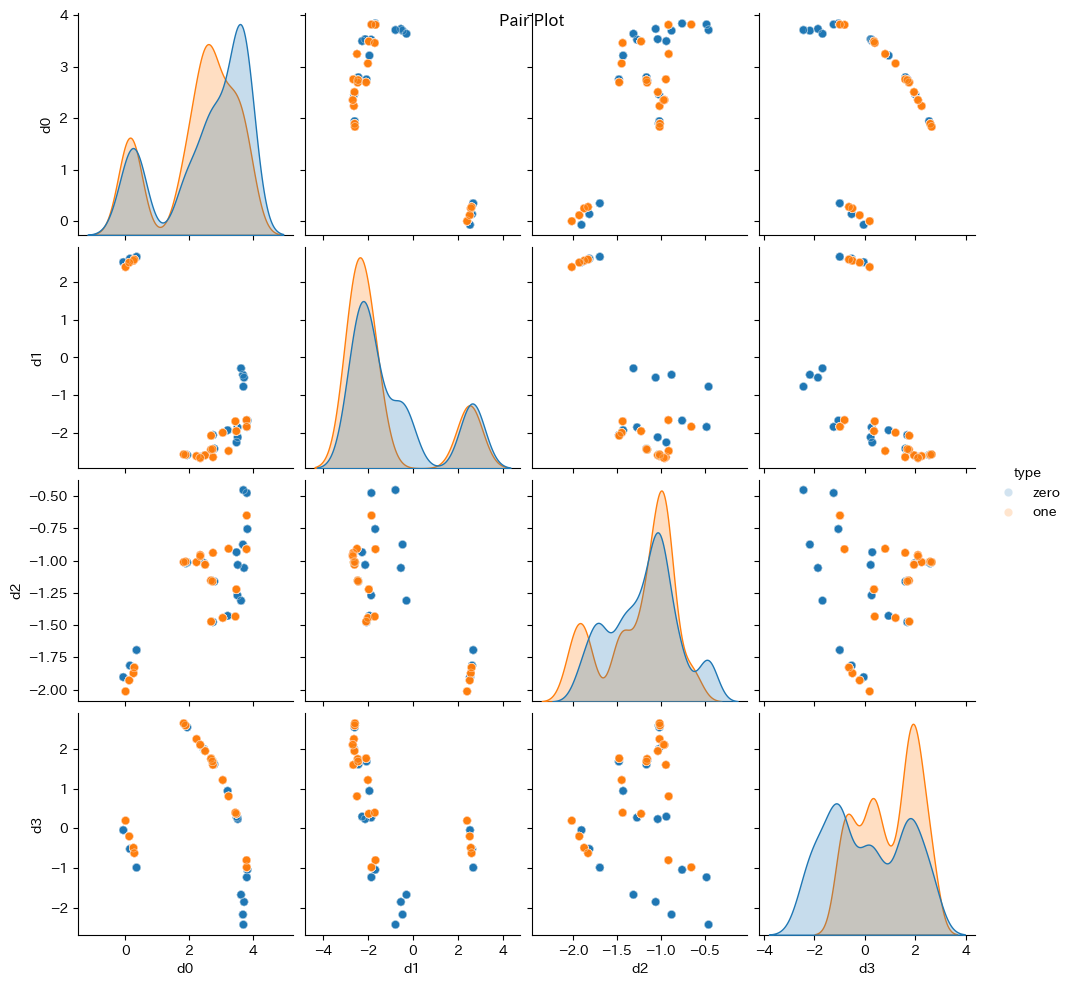

In [67]:

def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        vectors.append(memory.detach().cpu().numpy().reshape(-1, embedding_size))
    vectors_array = np.array(vectors)
    return vectors_array

# self-attentionのベクトルを抽出
zero_vectors_sa = extract_self_attention_vectors(zero_src, loaded_model)
one_vectors_sa = extract_self_attention_vectors(one_src, loaded_model)
zero_vectors_sa_squeezed = zero_vectors_sa[:, 1:6, :].reshape(-1, embedding_size)
one_vectors_sa_squeezed = one_vectors_sa[:, 1:6, :].reshape(-1, embedding_size)

plot_pca_zero_one(zero_vectors_sa_squeezed, one_vectors_sa_squeezed, title="Self-Attention後の埋め込みベクトル")
plot_umap_zero_one(zero_vectors_sa_squeezed, one_vectors_sa_squeezed)
plot_map_zero_one(zero_vectors_sa_squeezed, one_vectors_sa_squeezed)
plot_pairplot(zero_vectors_sa_squeezed, one_vectors_sa_squeezed)

(100, 7, 4)


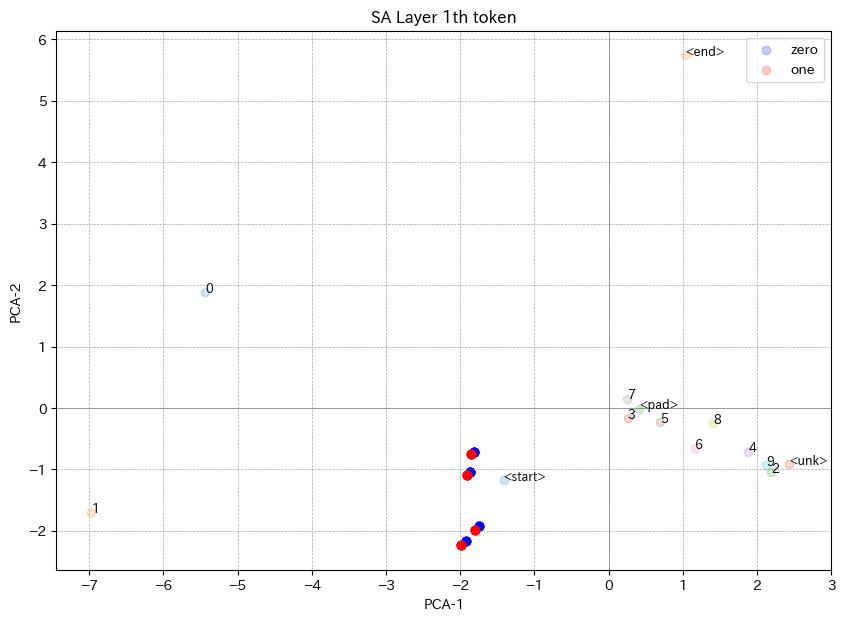

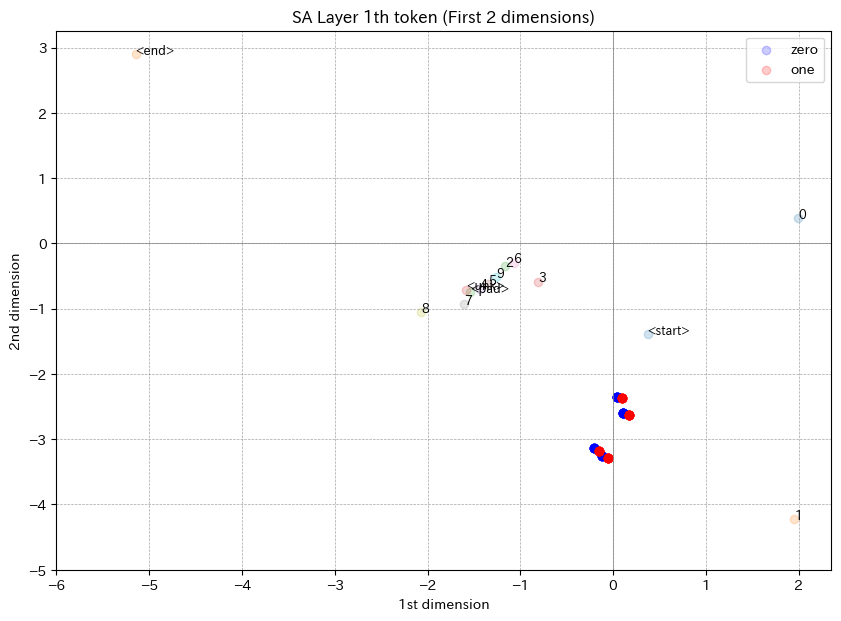

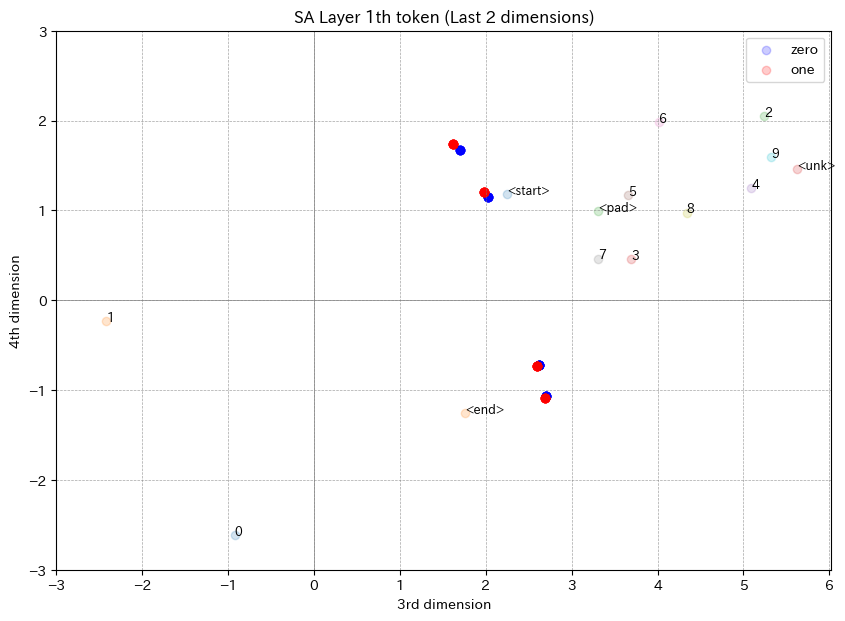

<Figure size 1000x500 with 0 Axes>

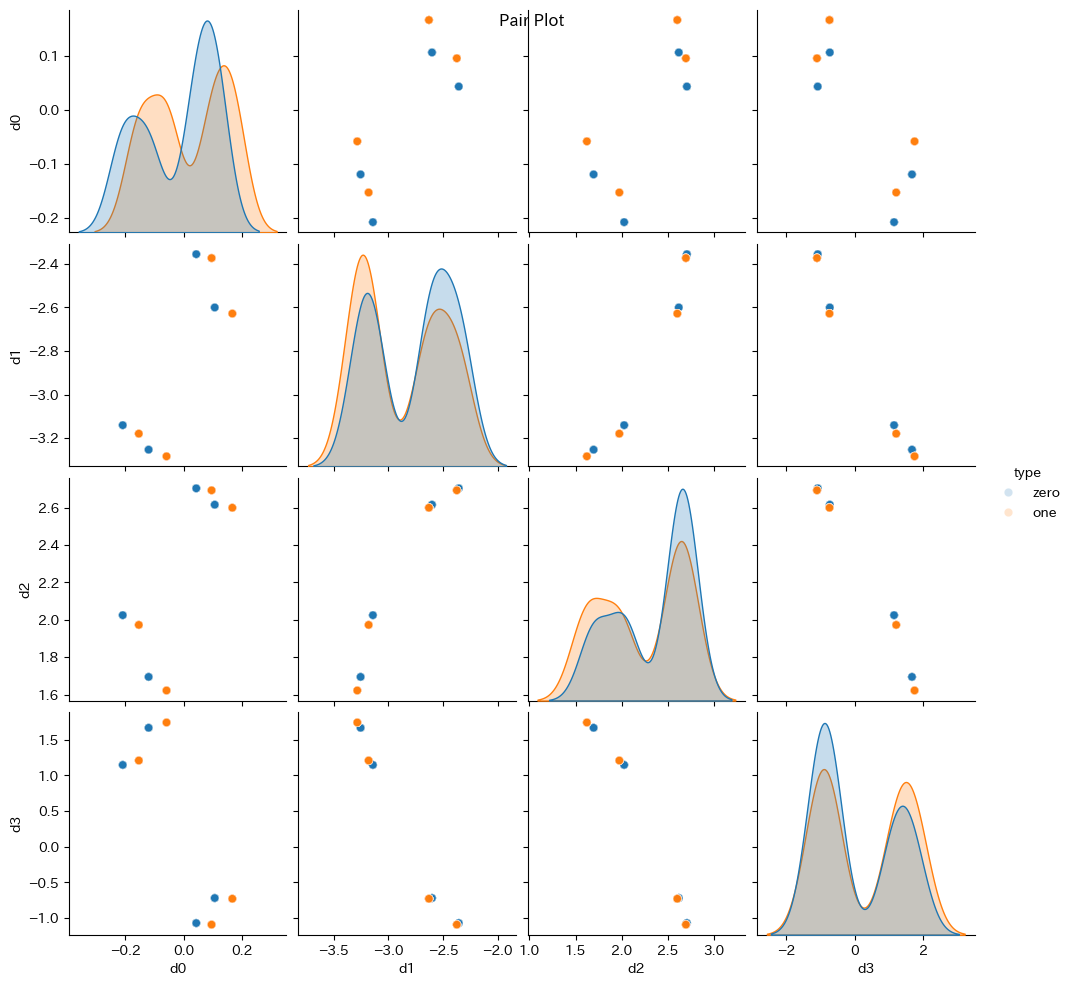

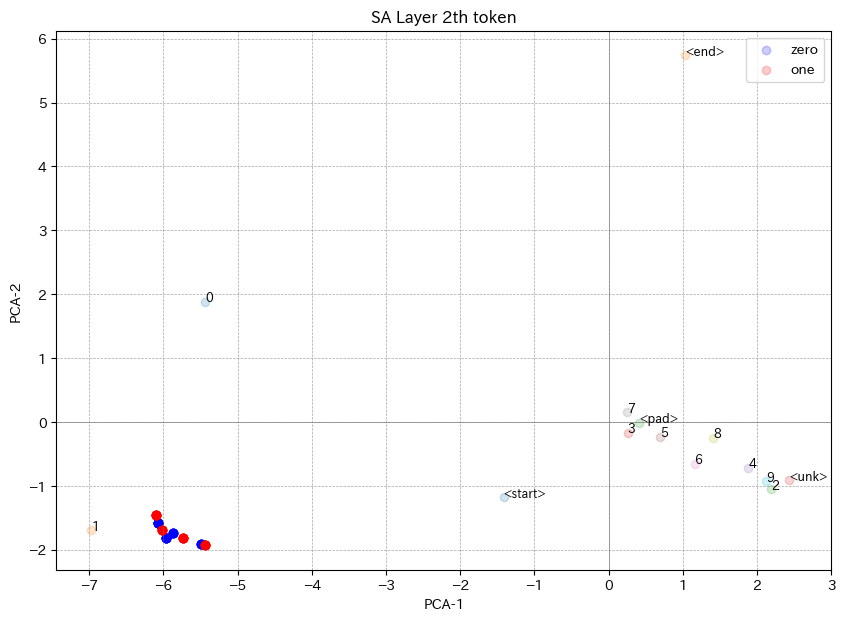

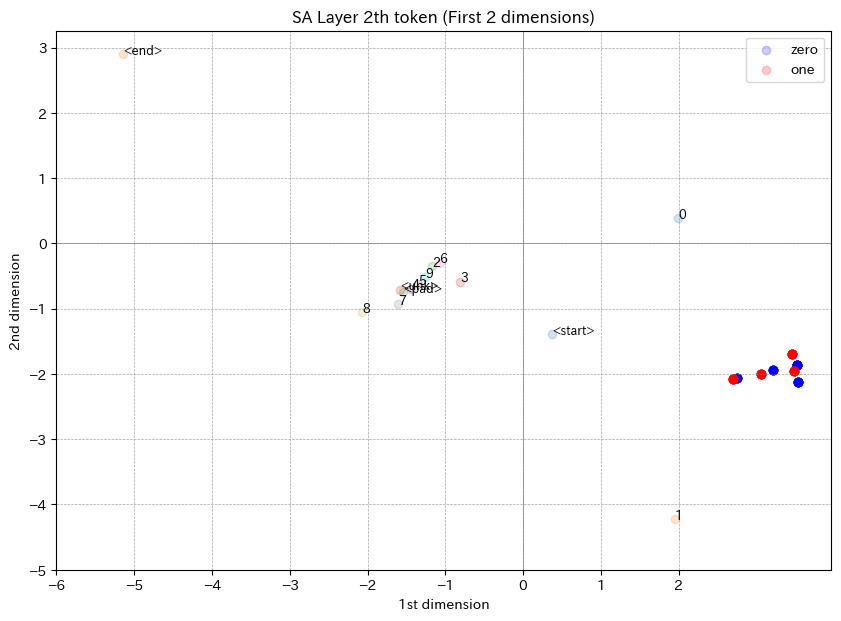

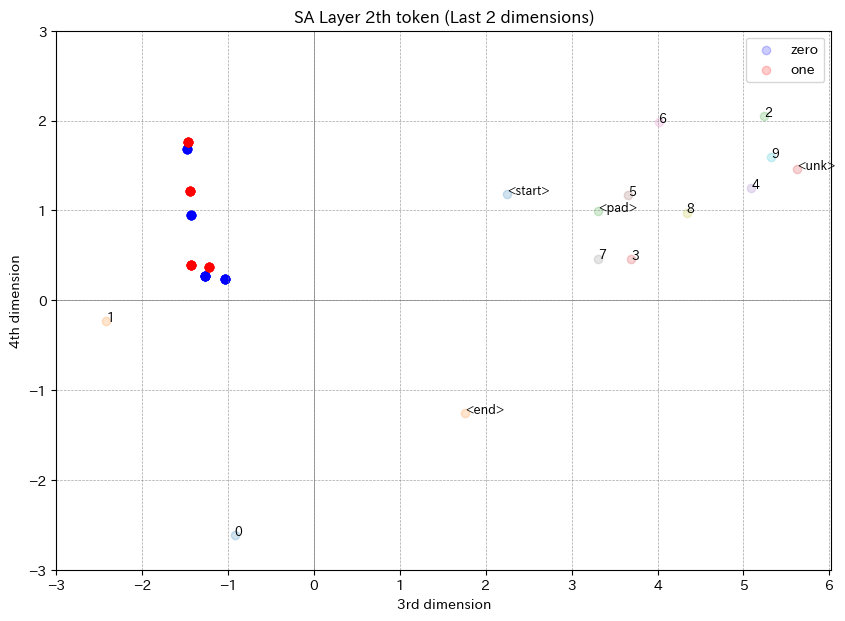

<Figure size 1000x500 with 0 Axes>

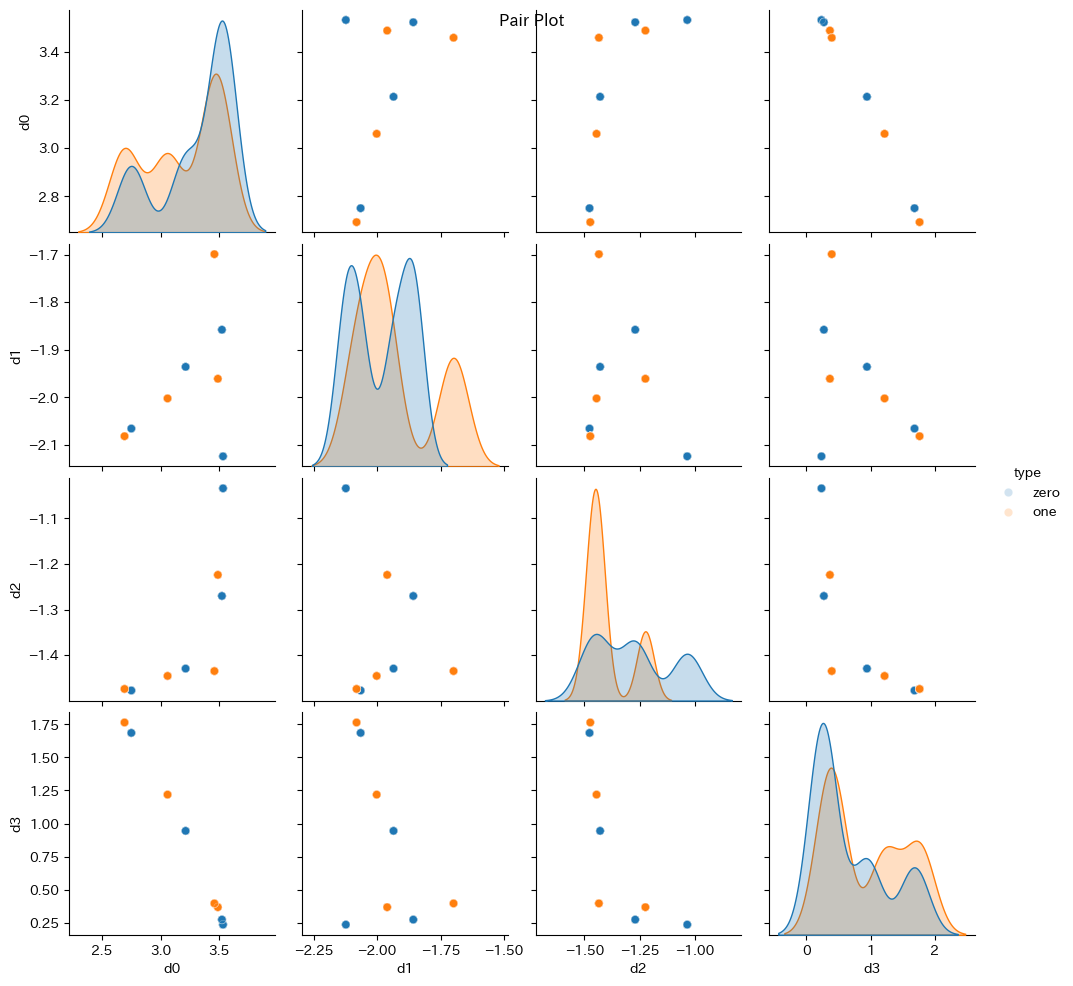

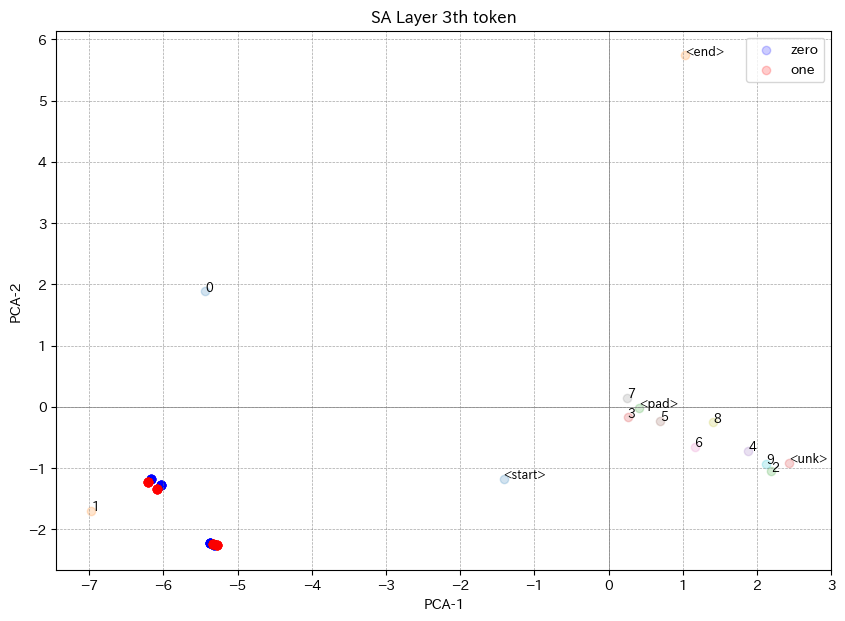

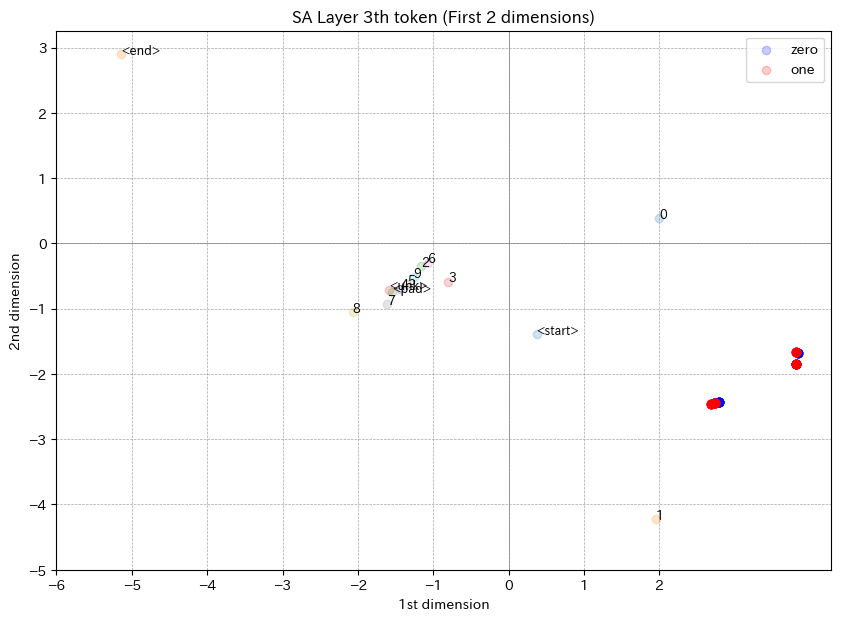

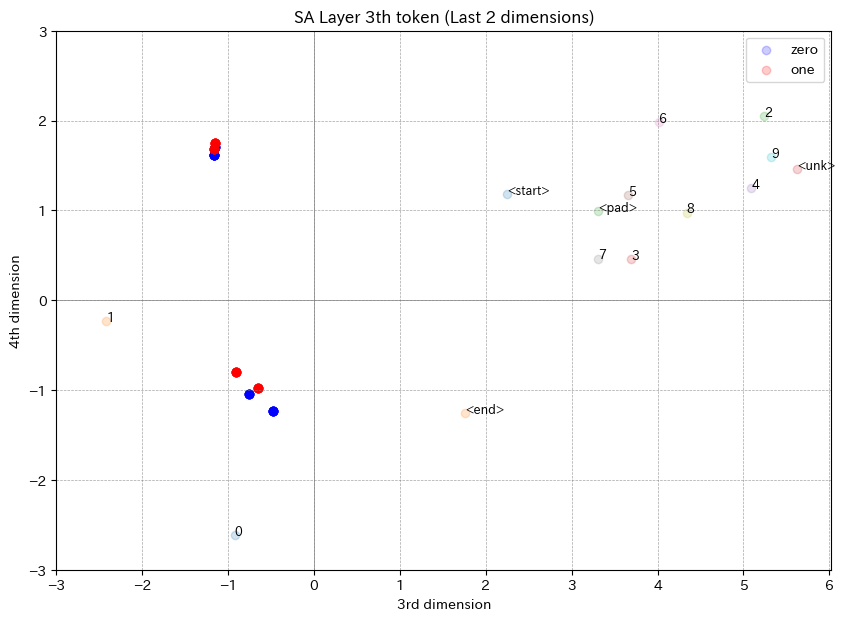

<Figure size 1000x500 with 0 Axes>

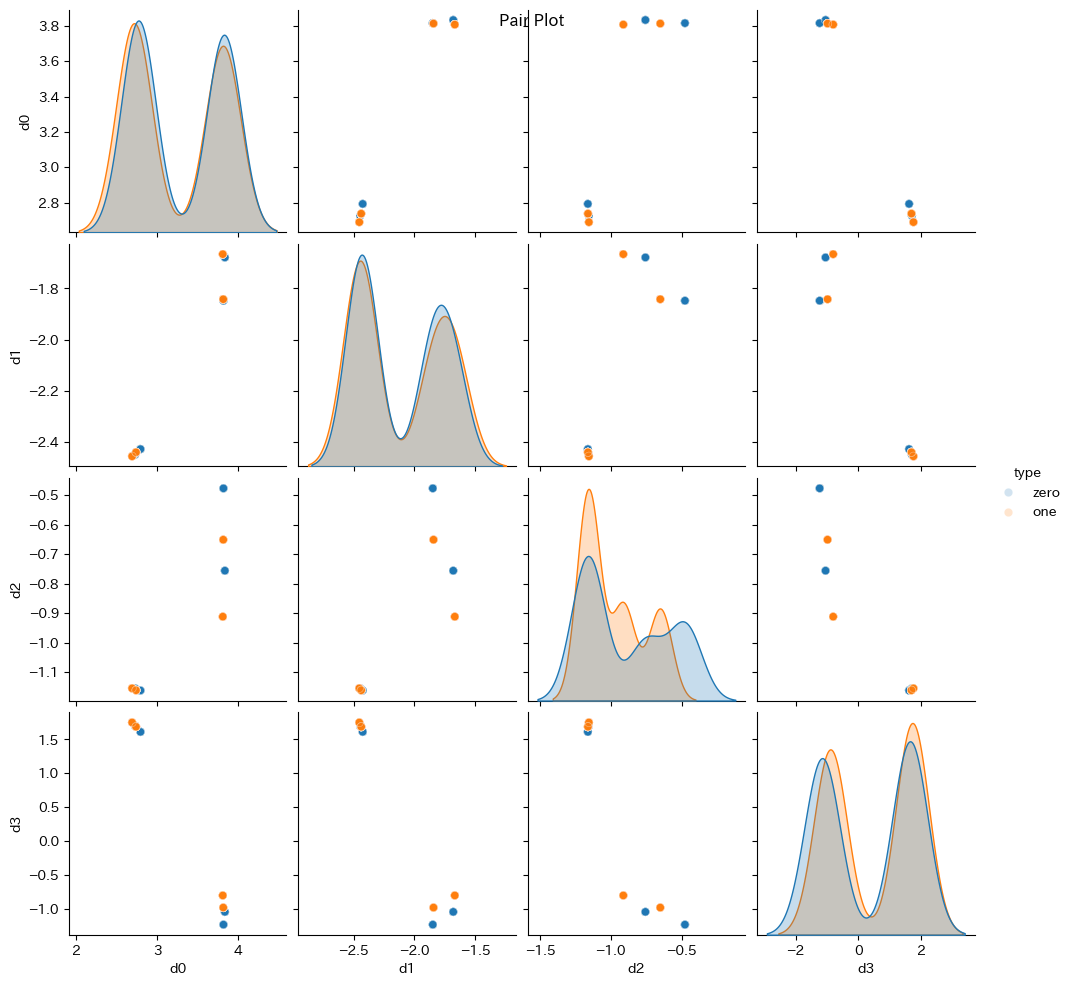

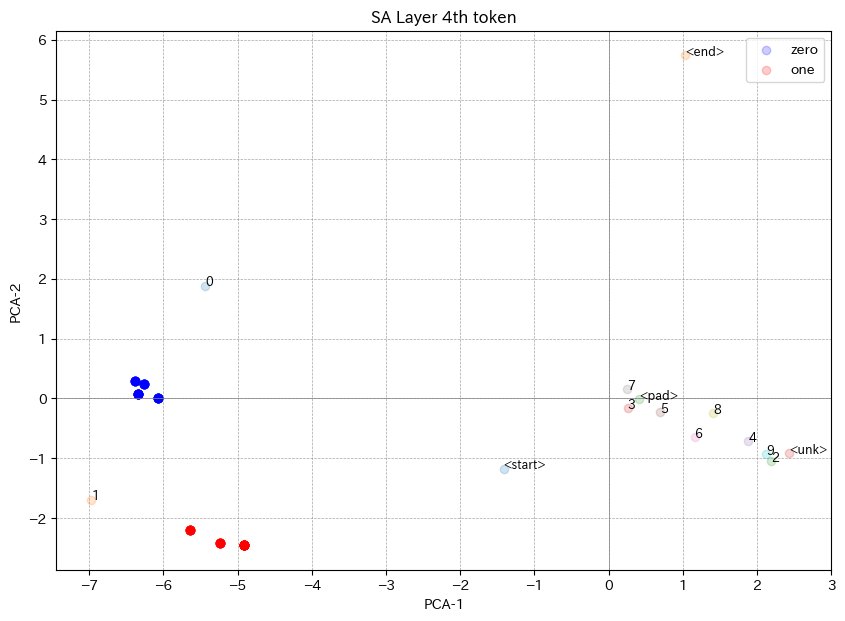

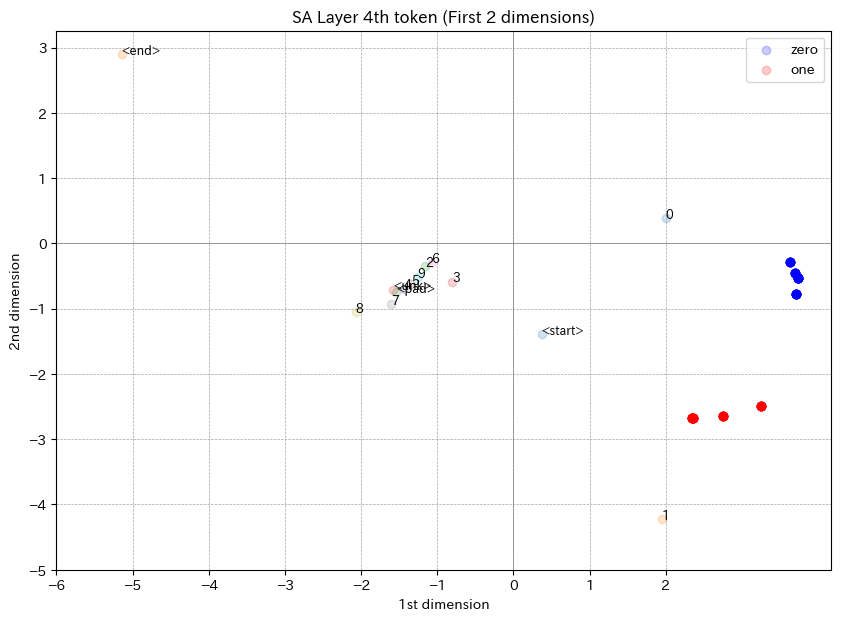

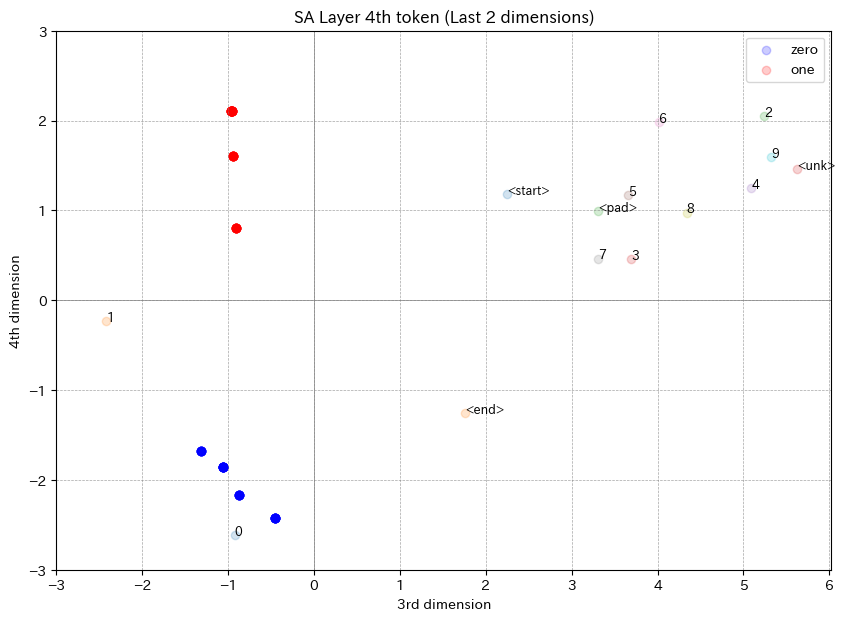

<Figure size 1000x500 with 0 Axes>

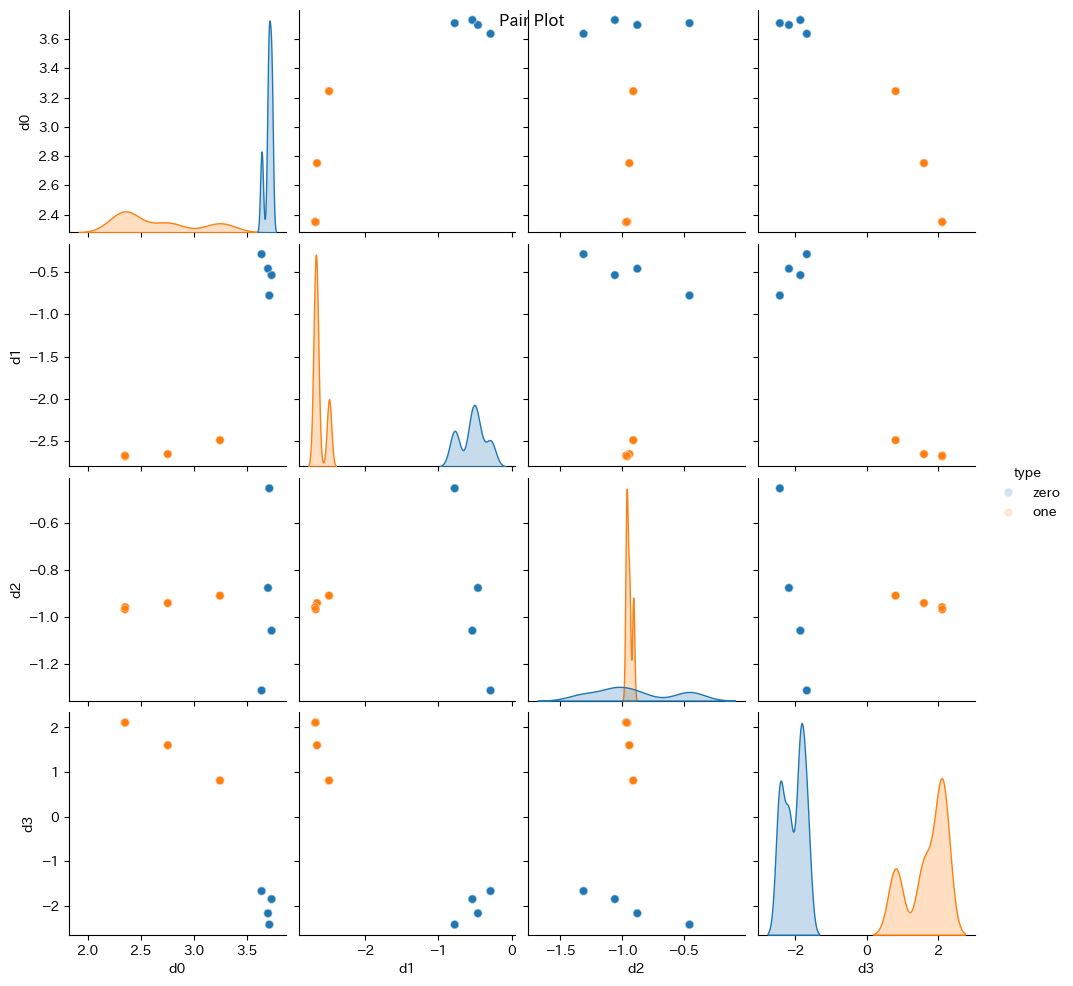

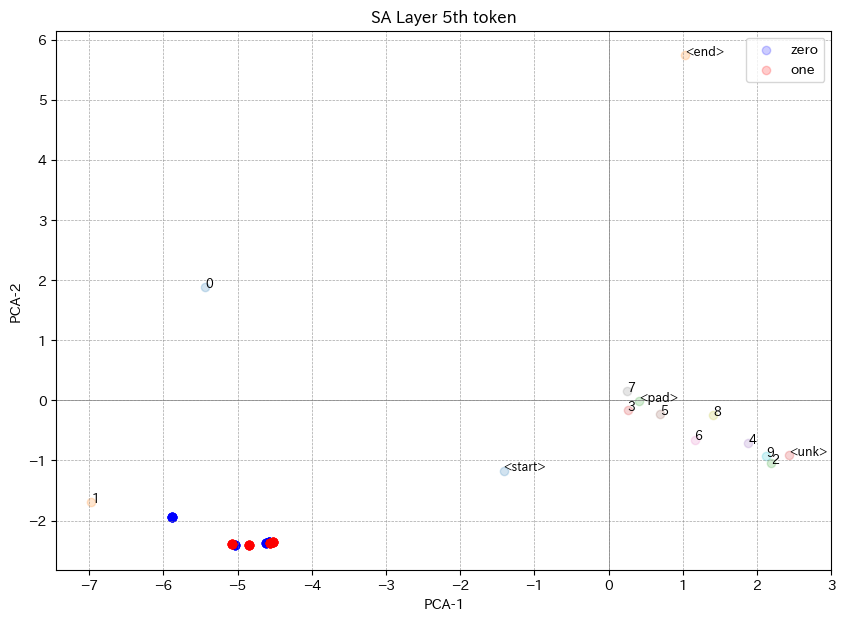

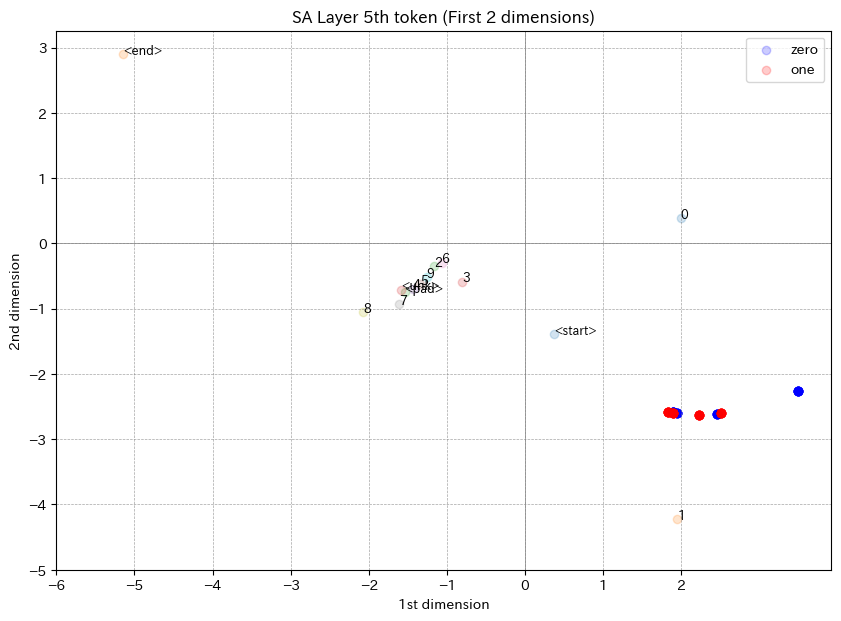

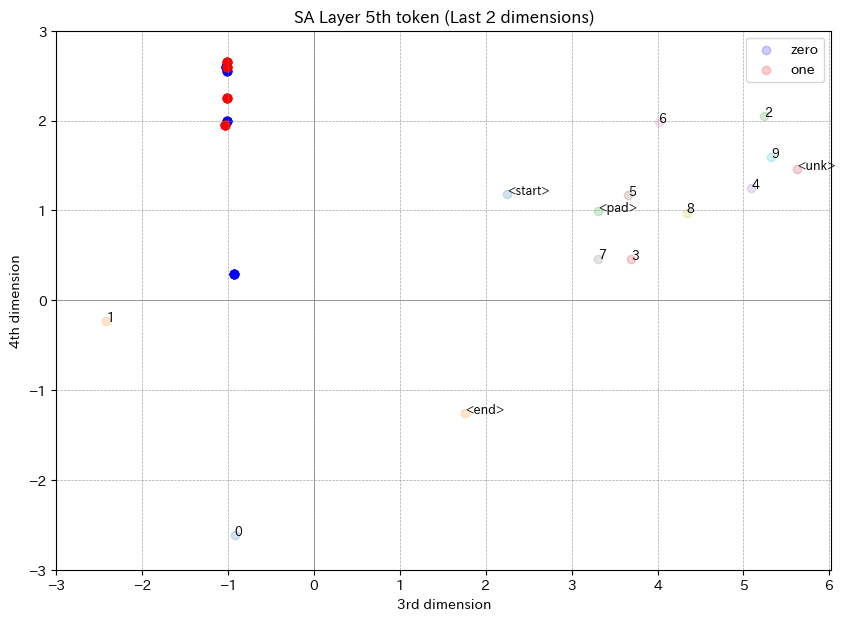

<Figure size 1000x500 with 0 Axes>

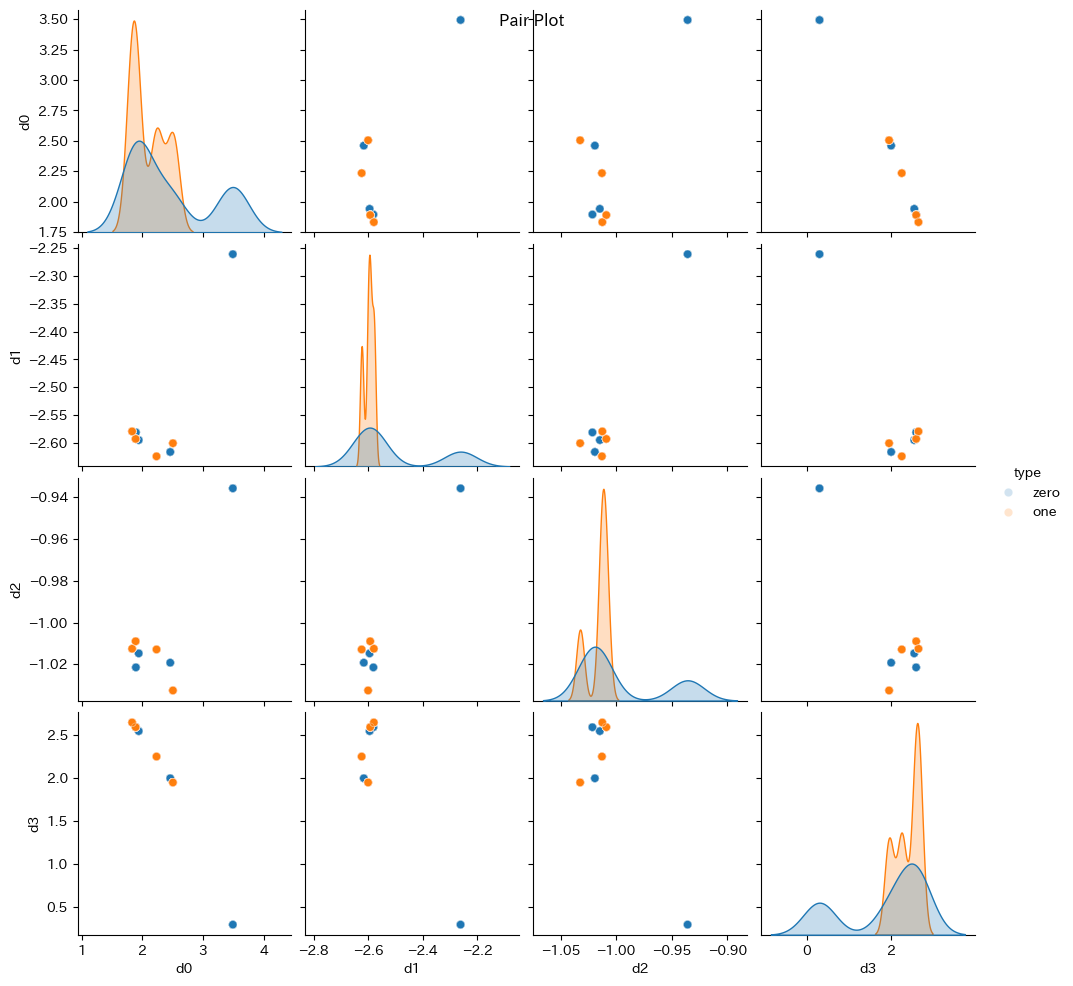

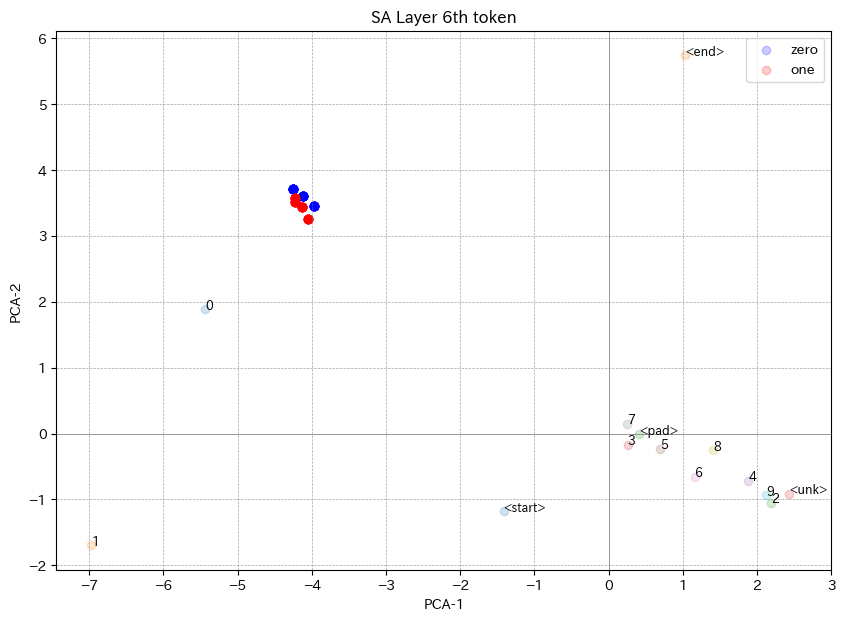

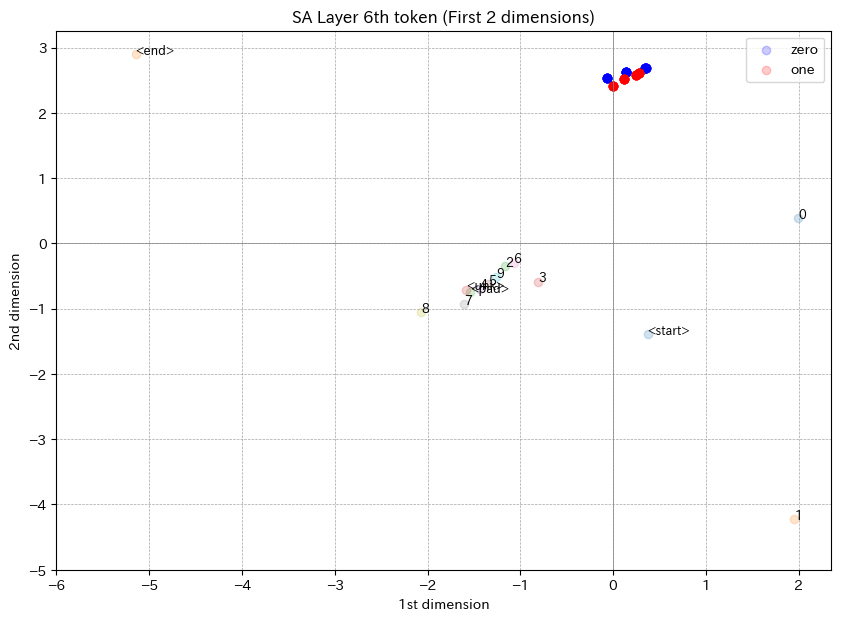

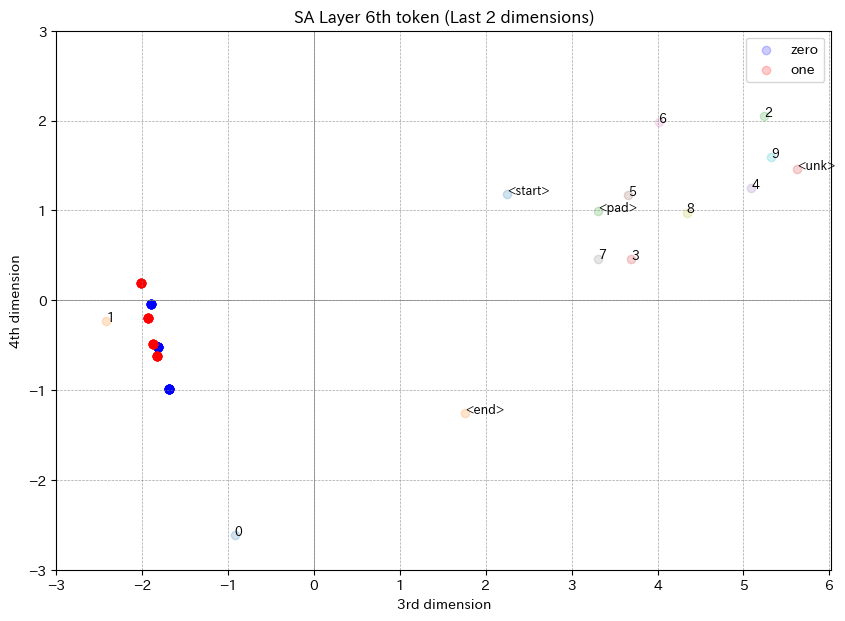

<Figure size 1000x500 with 0 Axes>

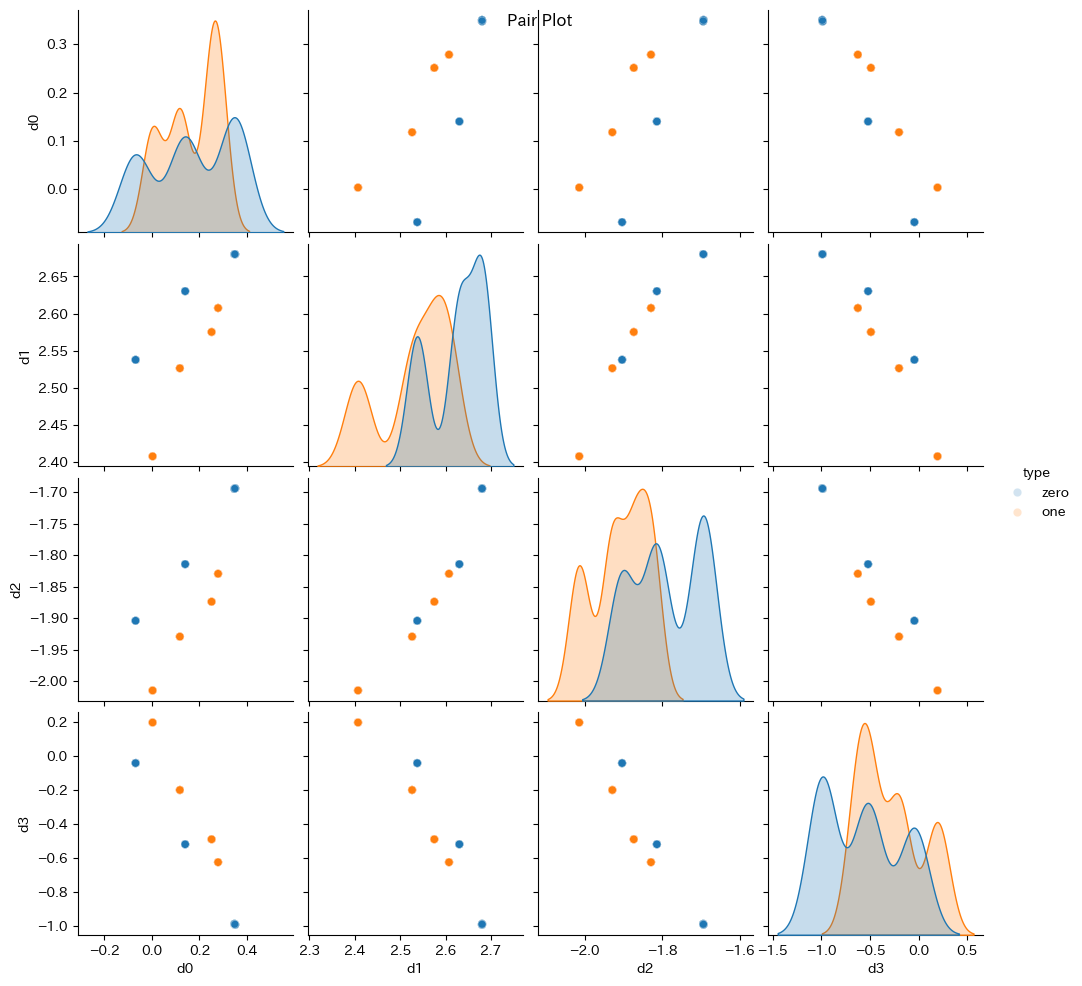

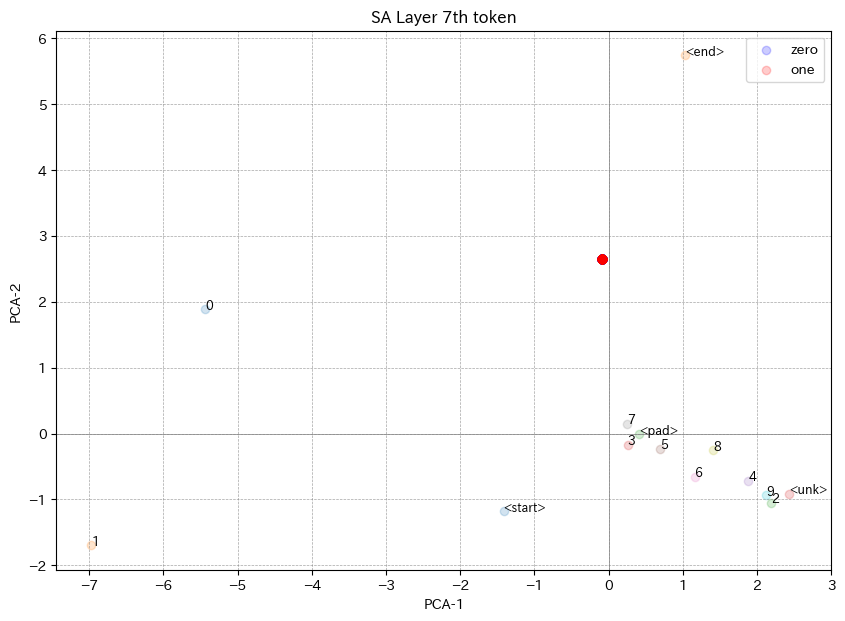

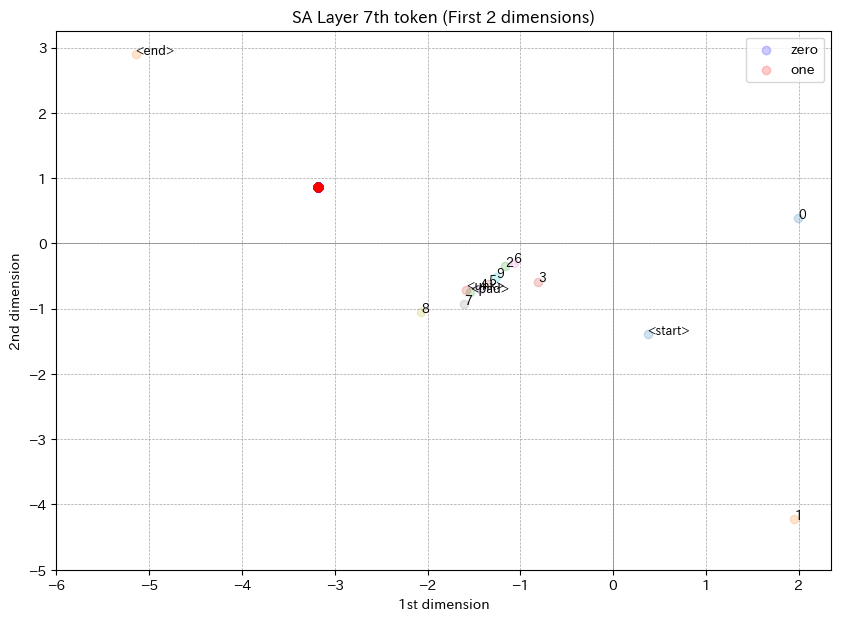

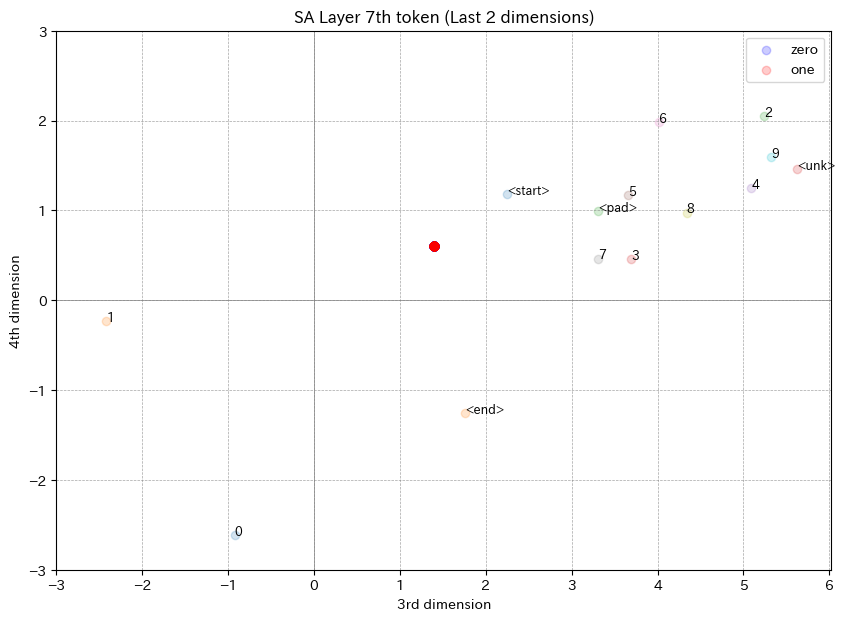

<Figure size 1000x500 with 0 Axes>

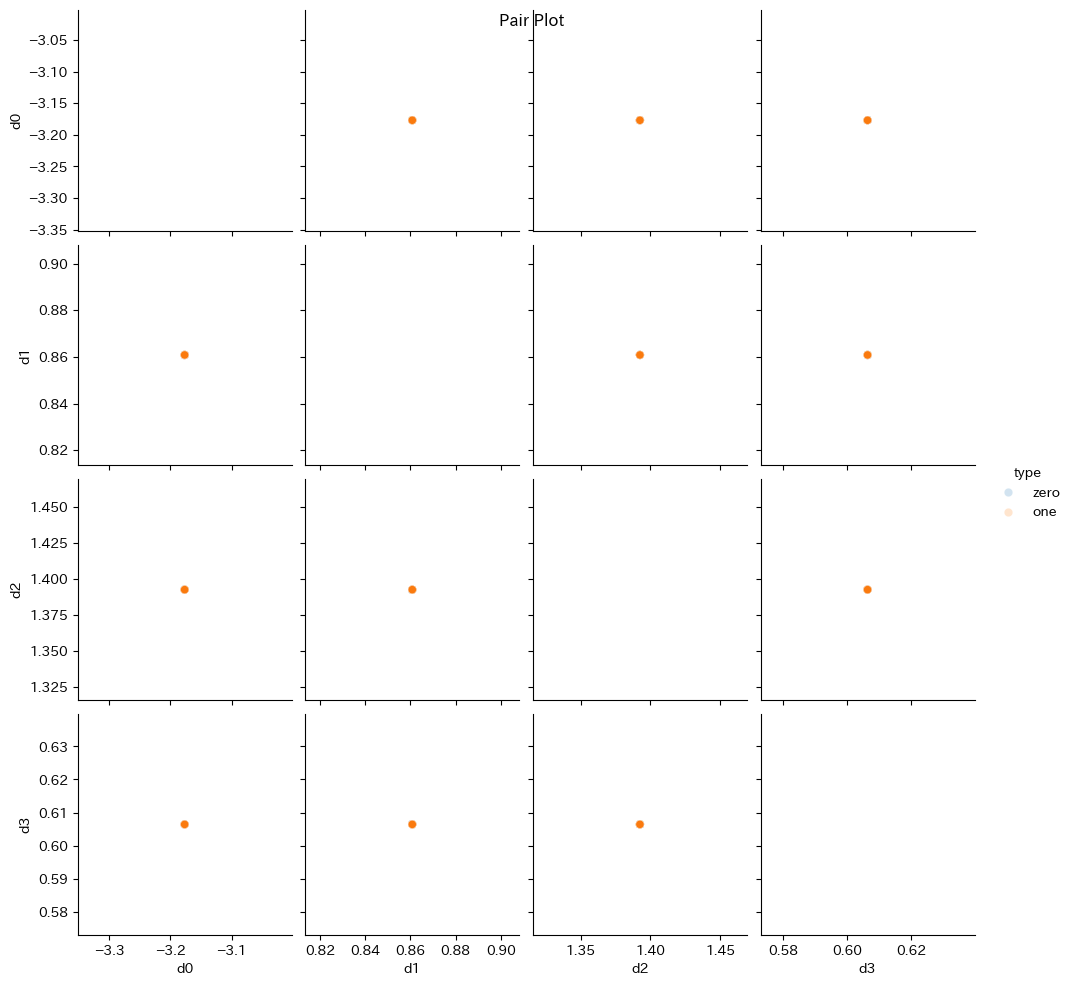

In [ ]:
print(zero_vectors_sa.shape)
for i in range(7):
    plot_pca_zero_one(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :], title=f"SA Layer {i+1}th token")
    # plot_umap_zero_one(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :], title=f"SA Layer {i+1}th token")
    plot_map_zero_one(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :], title=f"SA Layer {i+1}th token")
    plot_pairplot(zero_vectors_sa[:, i, :], one_vectors_sa[:, i, :])

#### Decoder: Self-Attentionの重みを可視化

(3, 3)


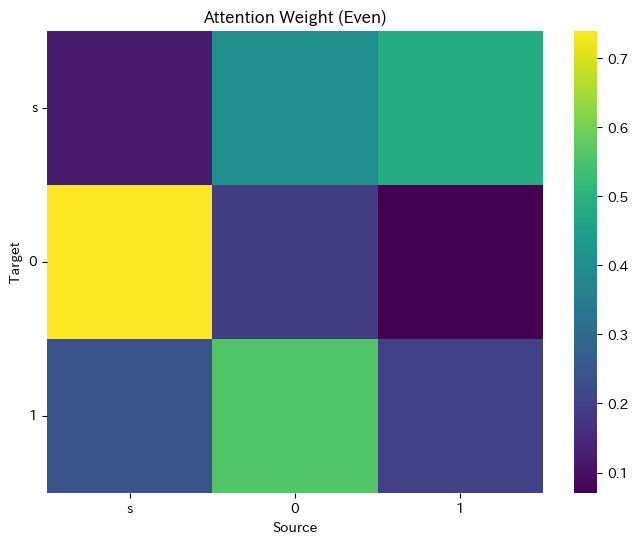

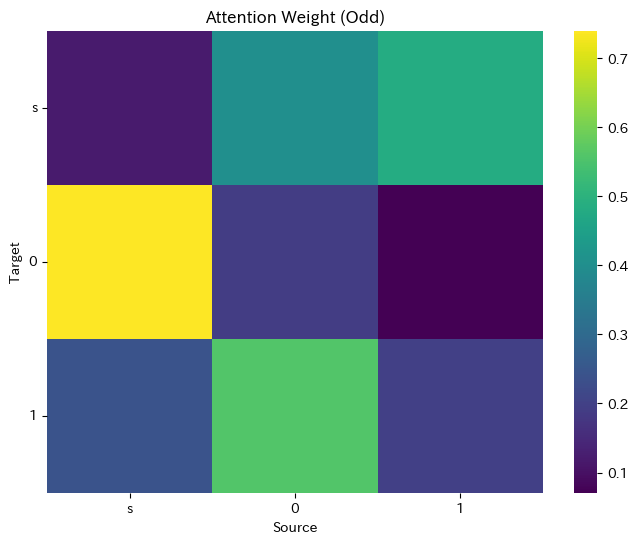

In [52]:
def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    attn_maps = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        tgt, _, attn_map = model.self_attn_decoder(tgt, embedding_size)
        attn_maps.append(attn_map.detach().cpu().numpy())
    attn_maps = np.array(attn_maps)
    return attn_maps

# self-attentionのベクトルを抽出
zero_vectors_sa = extract_self_attention_vectors(zero_src, loaded_model).mean(axis=0).squeeze()
one_vectors_sa = extract_self_attention_vectors(one_src, loaded_model).mean(axis=0).squeeze()

# Cross AttentionのAttentionWeightのヒートマップを表示
print(zero_vectors_sa.shape)
plot_heatmap(zero_vectors_sa, title="Attention Weight (Even)", src_label="s01", ys_label="s01")
plot_heatmap(one_vectors_sa, title="Attention Weight (Odd)", src_label="s01", ys_label="s01")

#### Decoder: Self-Attention + yを図示

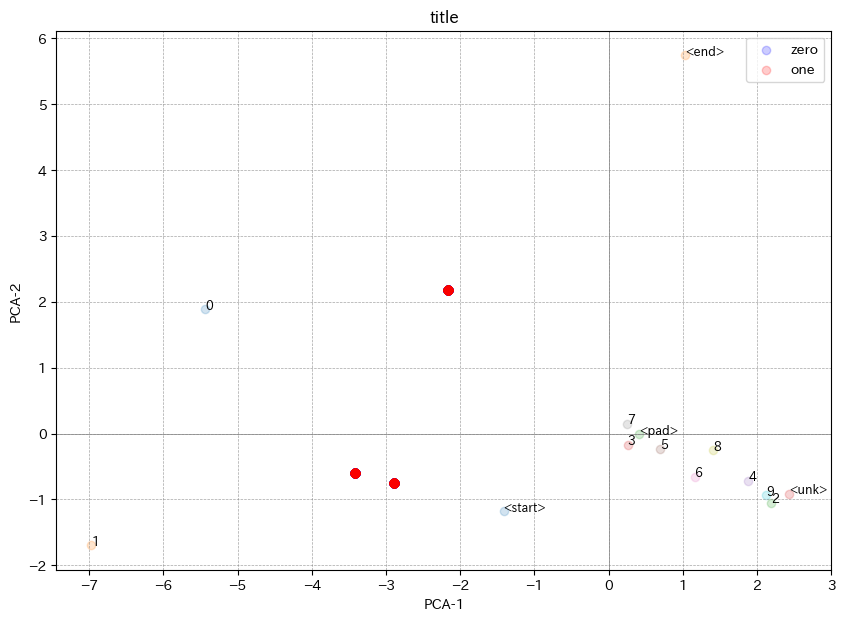

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


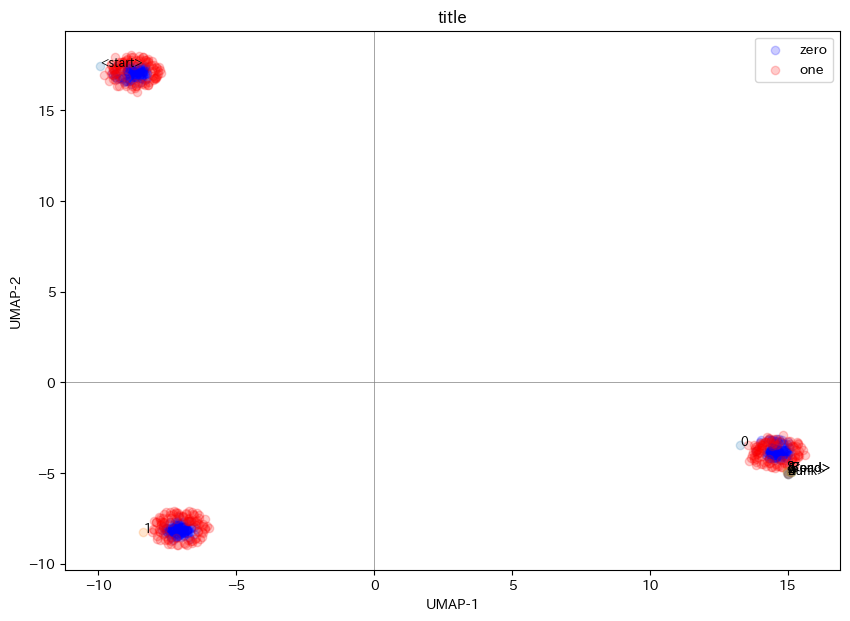

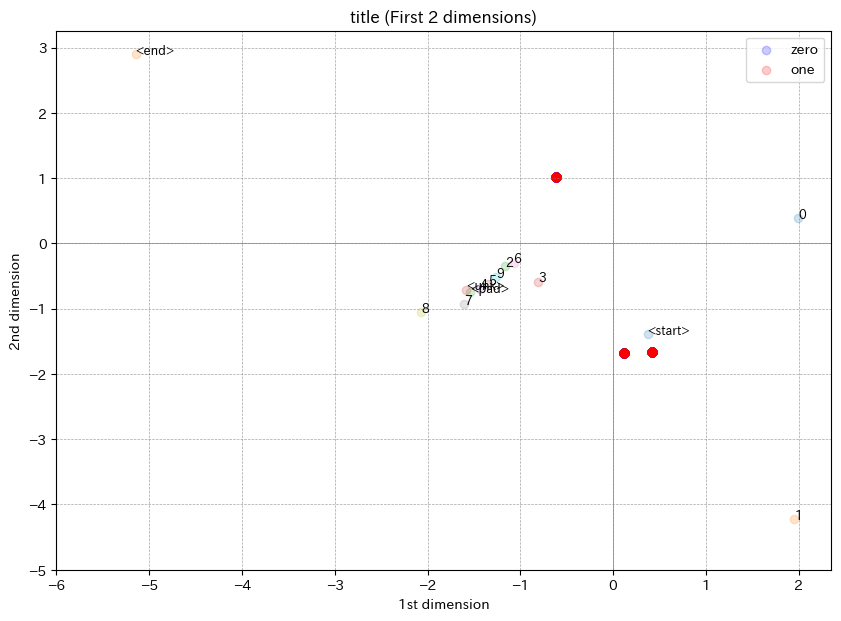

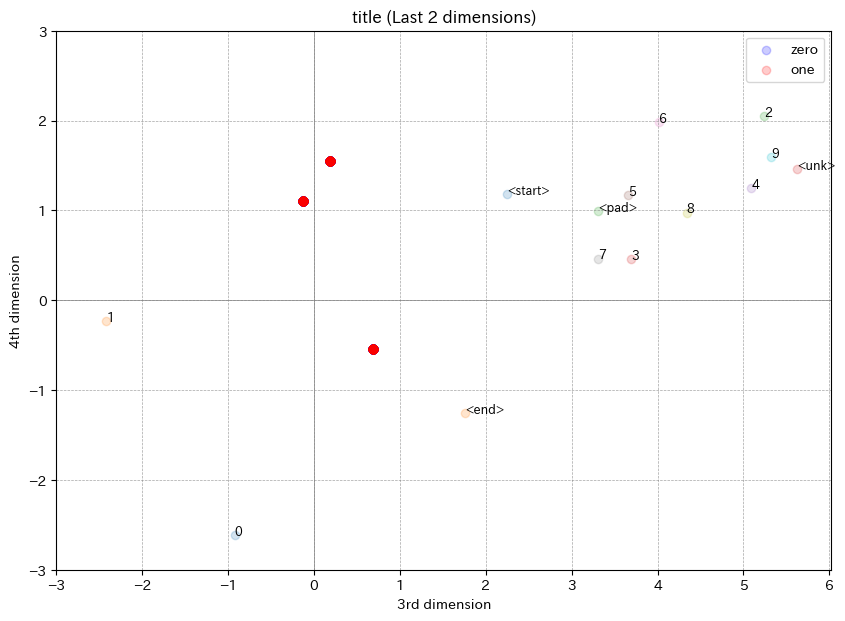

<Figure size 1000x500 with 0 Axes>

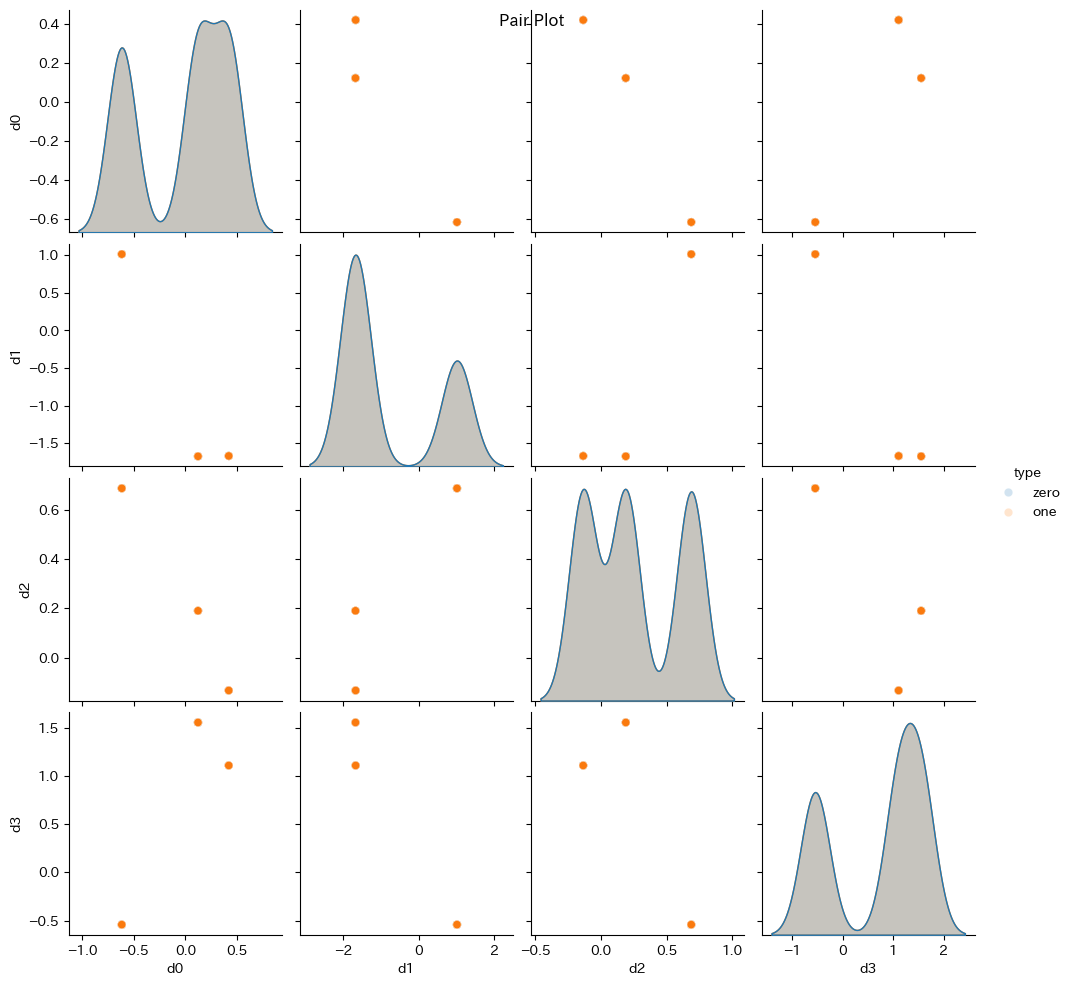

In [53]:

def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)
        vectors.append(tgt.detach().cpu().numpy().squeeze())  # 平均化して次元を整える
    vectors_array = np.array(vectors)
    return vectors_array

# self-attentionのベクトルを抽出
zero_vectors_sa = extract_self_attention_vectors(zero_src, loaded_model).reshape(-1, embedding_size)
one_vectors_sa = extract_self_attention_vectors(one_src, loaded_model).reshape(-1, embedding_size)

plot_pca_zero_one(zero_vectors_sa, one_vectors_sa)
plot_umap_zero_one(zero_vectors_sa, one_vectors_sa)
plot_map_zero_one(zero_vectors_sa, one_vectors_sa)
plot_pairplot(zero_vectors_sa, one_vectors_sa)

#### Cross-AttentionのAttention Weightを図示

(100, 3, 7) (100, 3, 7)


/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


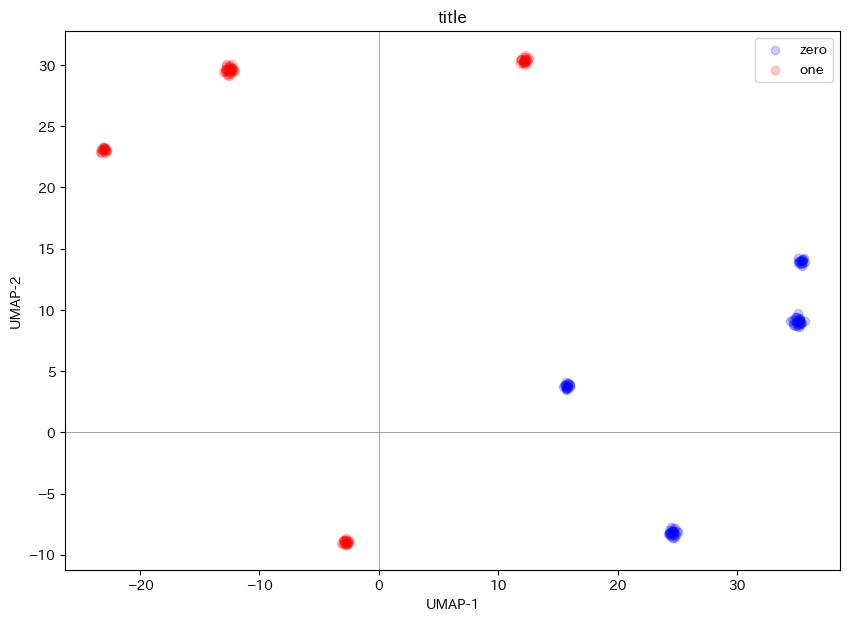

<Figure size 1000x500 with 0 Axes>

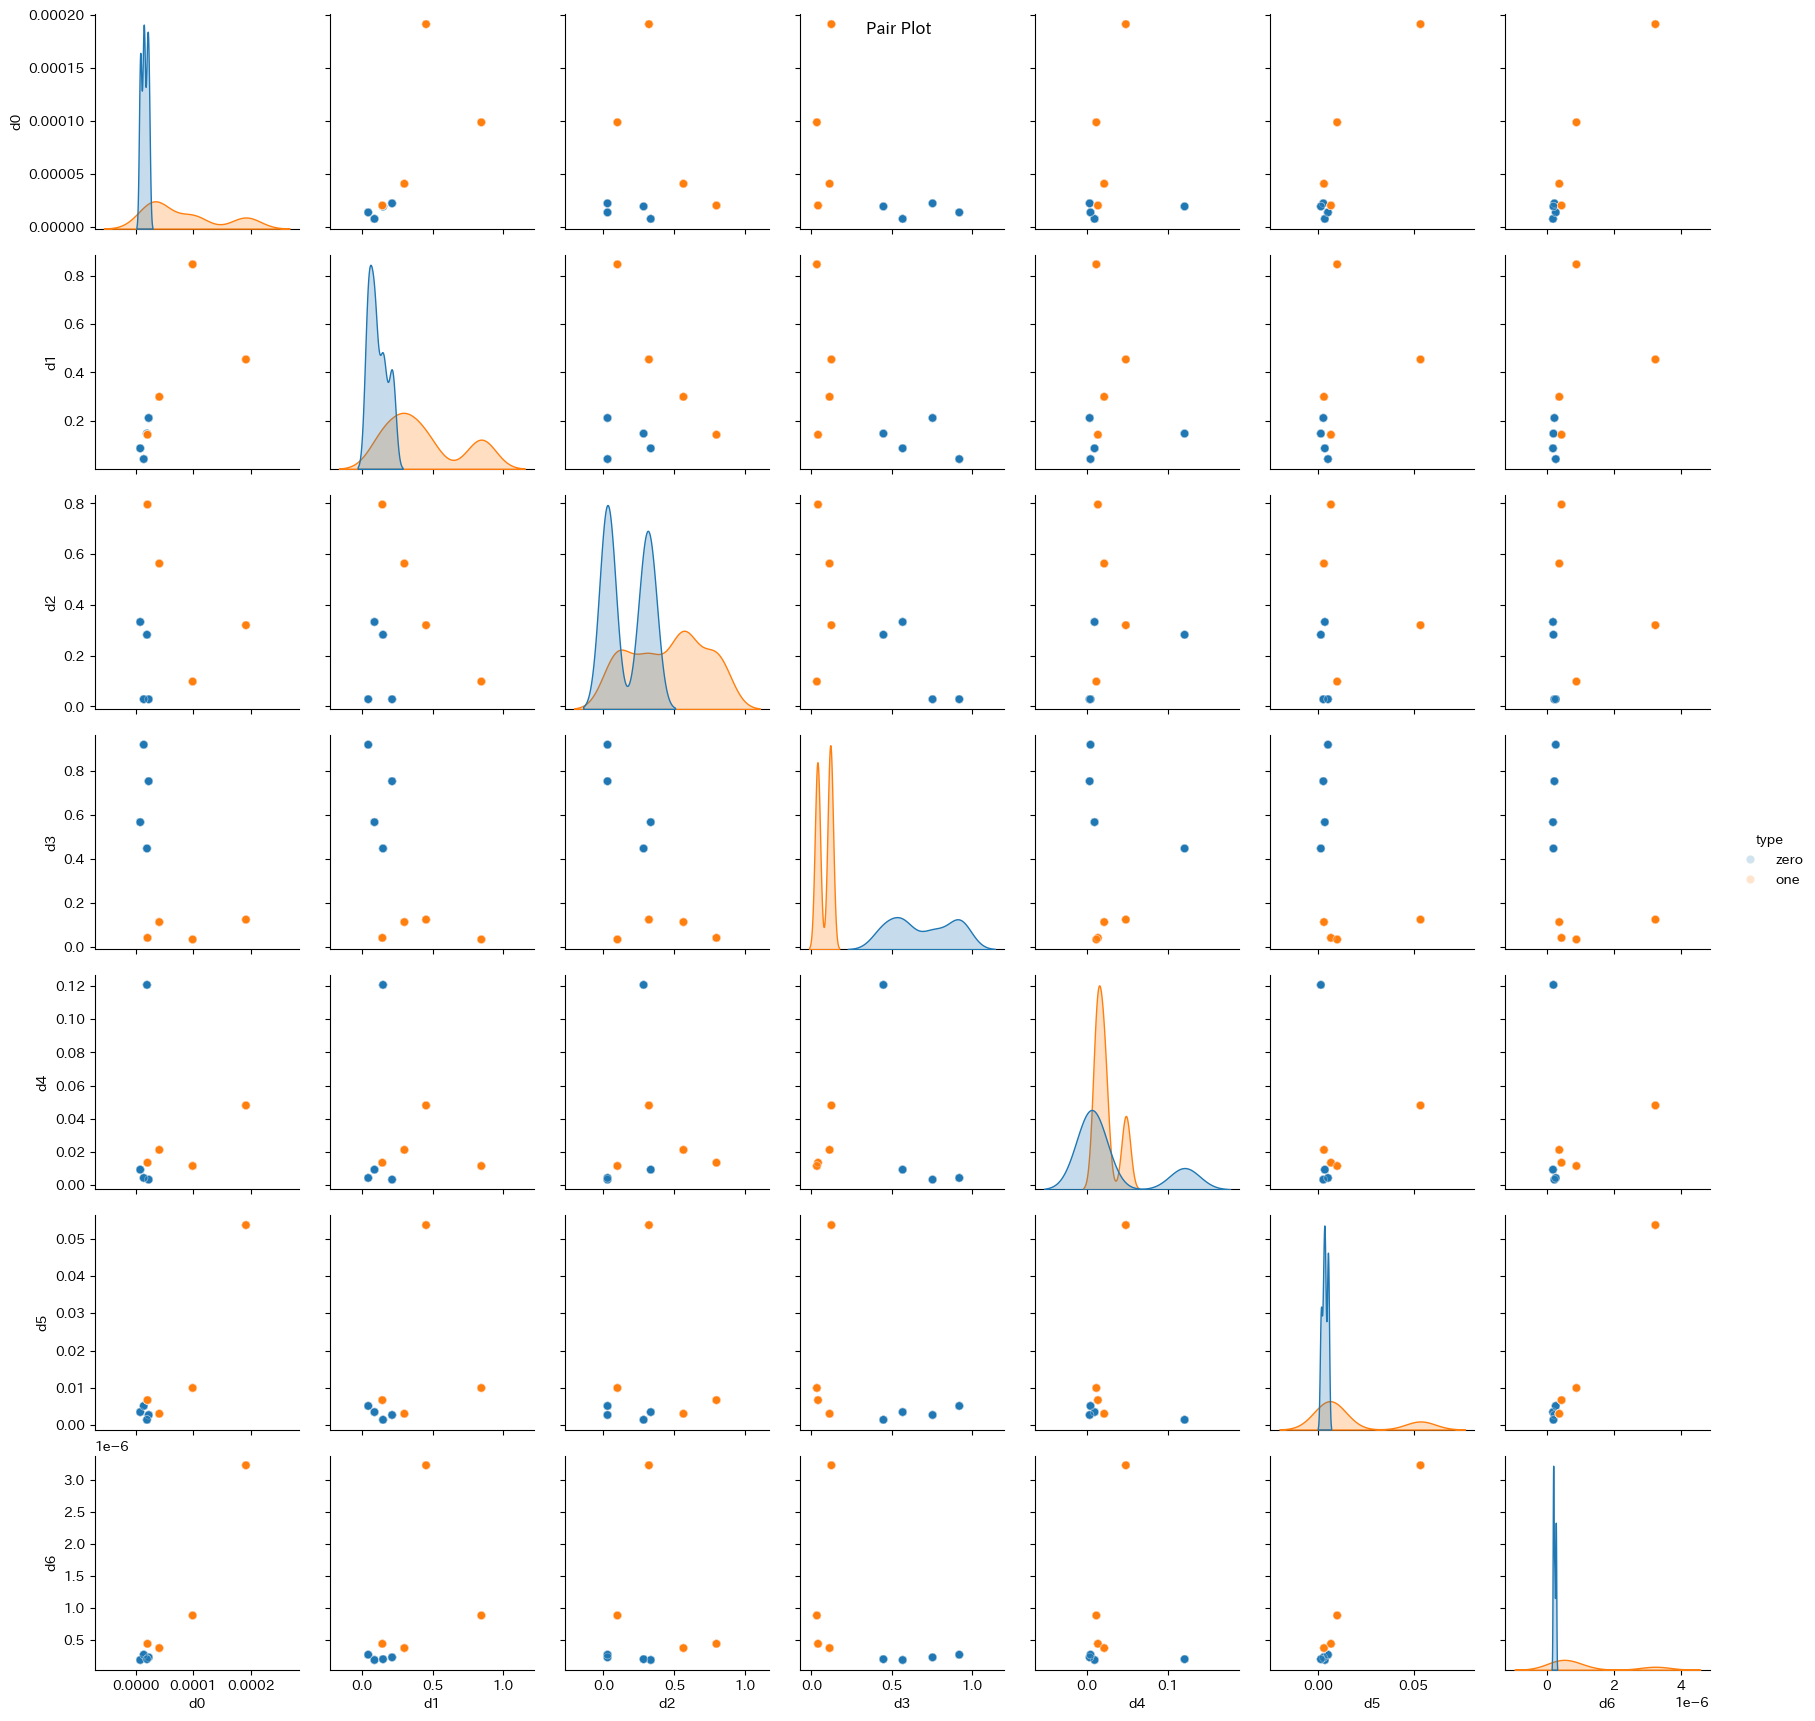

In [54]:

# Cross-AttentionのAttentionWeightの出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, tgt_, attention_weight = model.cross_attn(tgt, memory, embedding_size)
        vectors.append(attention_weight.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array
    

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
zero_vectors_ca3 = zero_vectors_ca[:, -1, :]
one_vectors_ca3 = one_vectors_ca[:, -1, :]
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_umap_zero_one(zero_vectors_ca3, one_vectors_ca3, withEnv=False, n_neighbors=20)
plot_pairplot(zero_vectors_ca3, one_vectors_ca3)



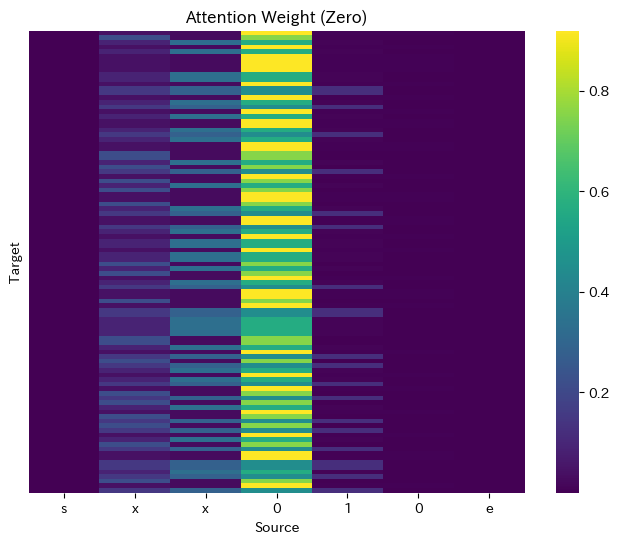

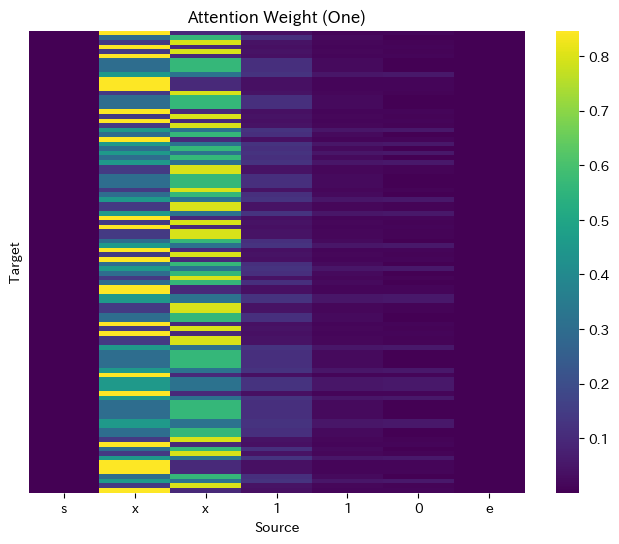

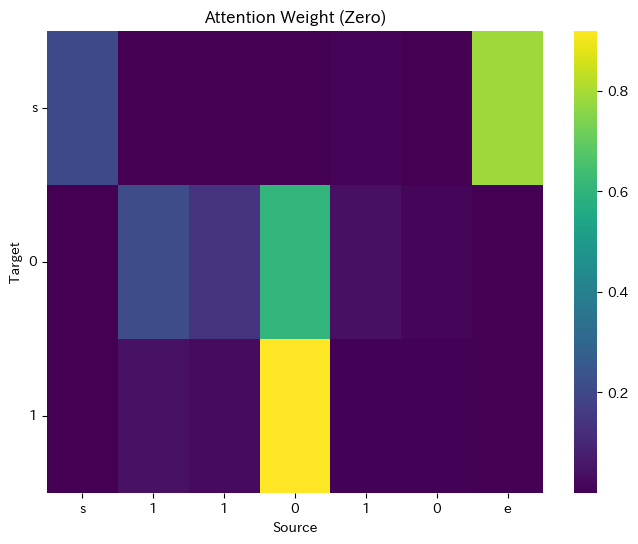

In [70]:
# Cross AttentionのAttentionWeightのヒートマップを表示
plot_heatmap(zero_vectors_ca3, title="Attention Weight (Zero)", src_label="sxx010e")
plot_heatmap(one_vectors_ca3, title="Attention Weight (One)", src_label="sxx110e")
plot_heatmap(zero_vectors_ca[0,: , :], title="Attention Weight (Zero)", src_label="s"+zero_data[0]+"e", ys_label="s"+convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt))

#### Cross-AttentionのVw*memoryを図示


特に、本来見るべきindex3を可視化

(100, 4) (100, 4)


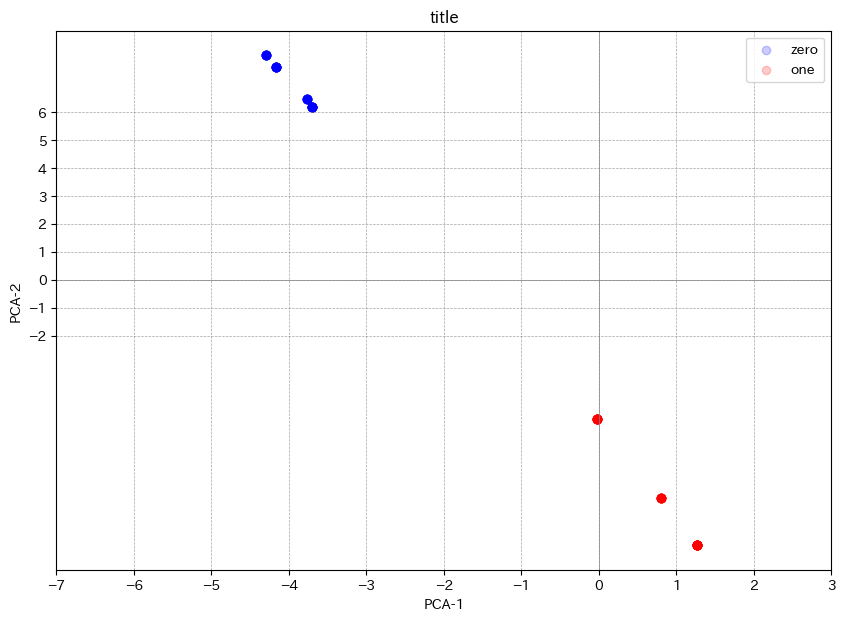

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


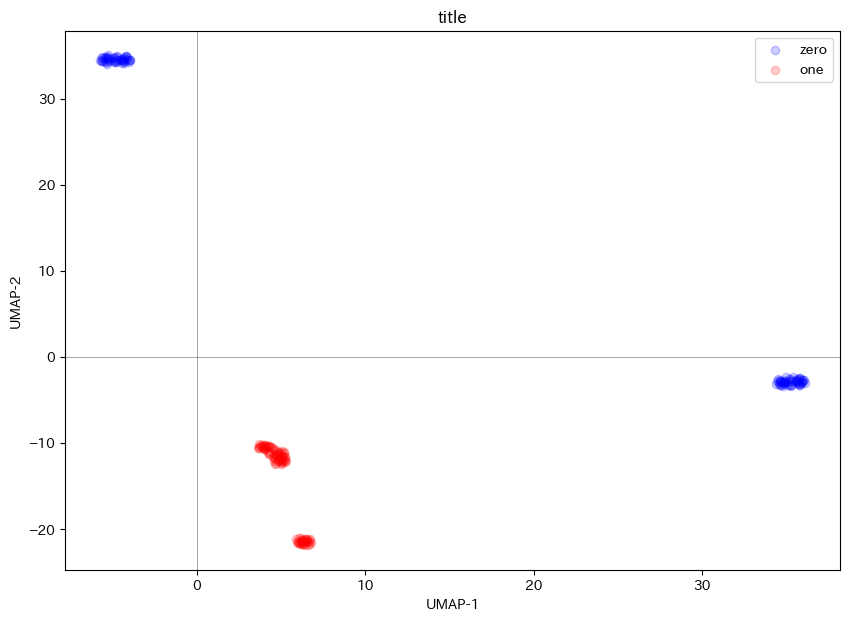

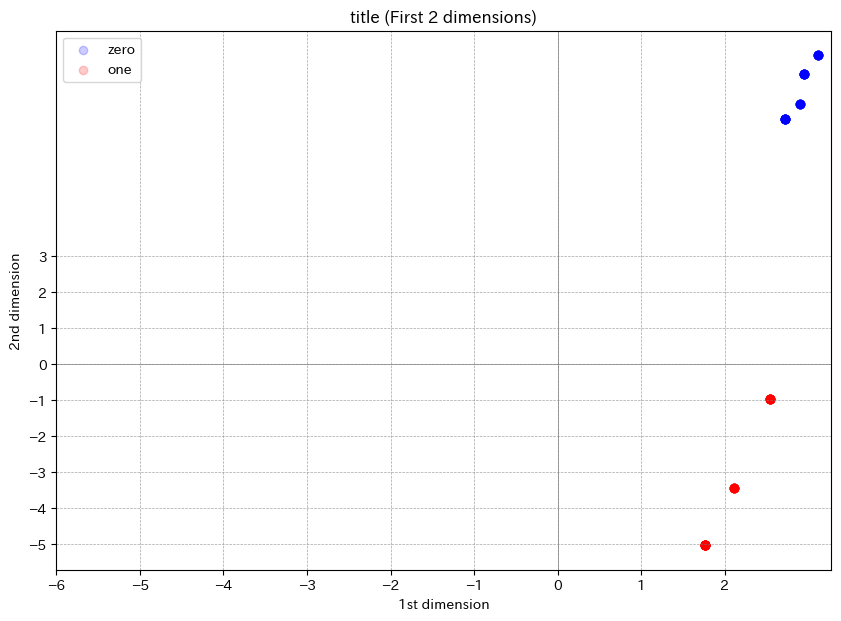

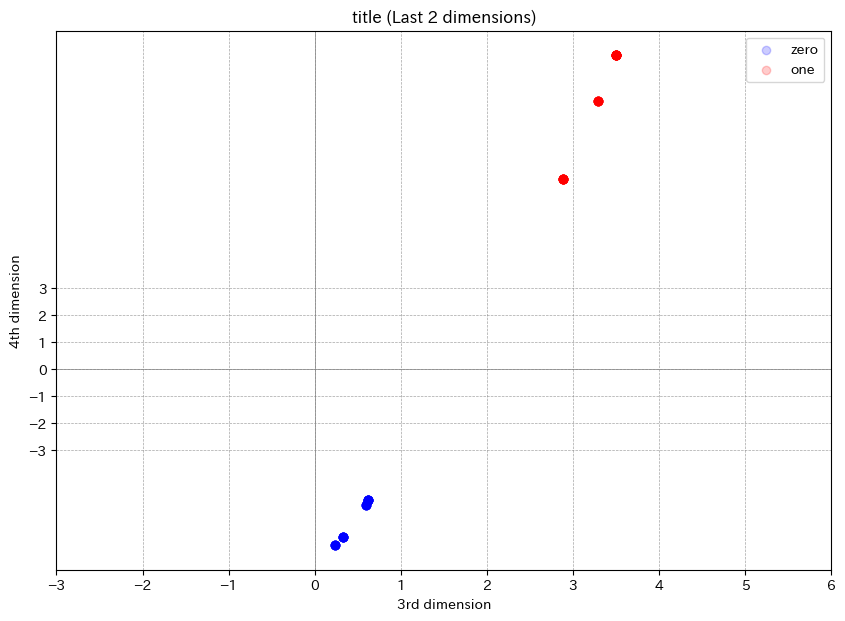

<Figure size 1000x500 with 0 Axes>

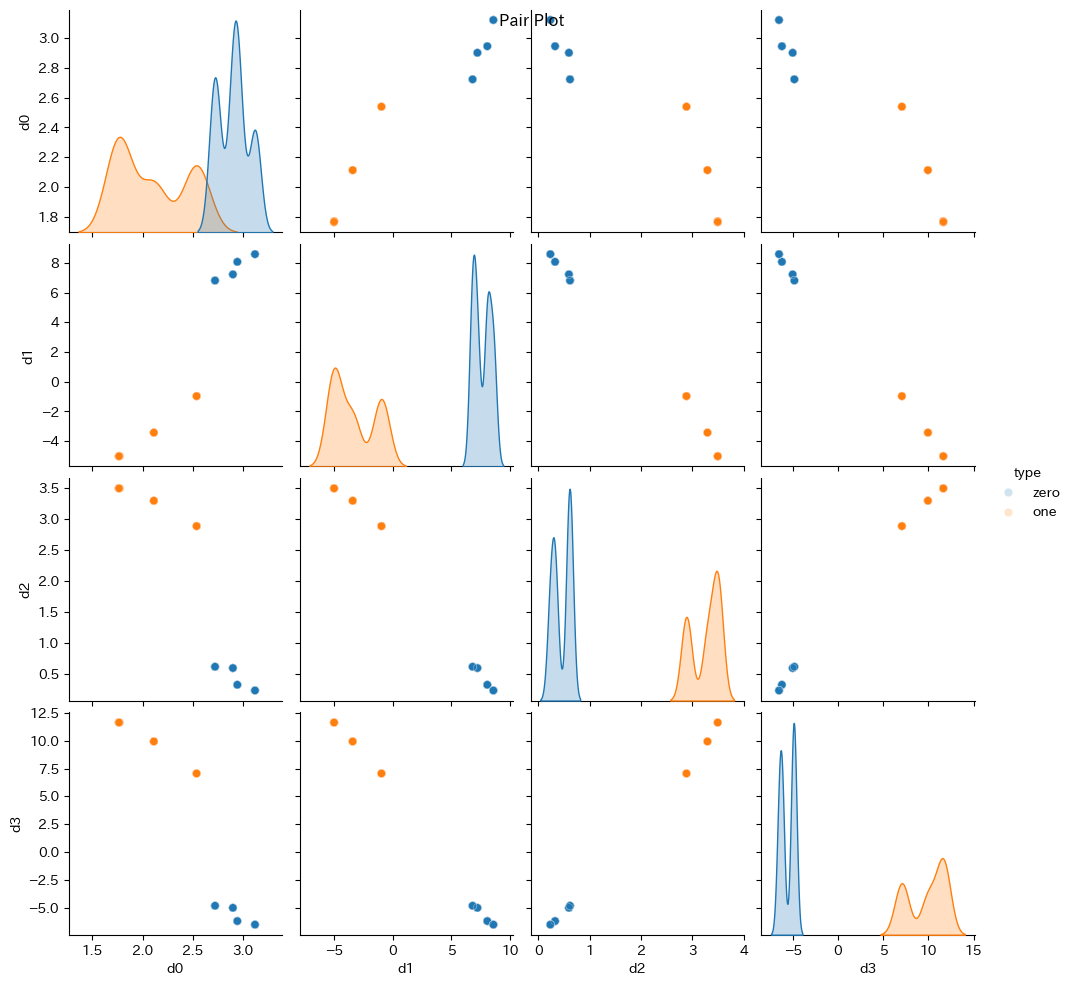

In [37]:
# Vw*memのindex5を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # Cross Attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        VW = torch.matmul(VW, model.decoder_layer.cross_attn.out_proj.weight.data.T)
        index5 = VW[:, 3, :]
        vectors.append(index5.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)


次にindex = 4を可視化。ちなみにindex4は赤青は関係ないので、実際意味がないが、確かめるために試す

(100, 4) (100, 4)


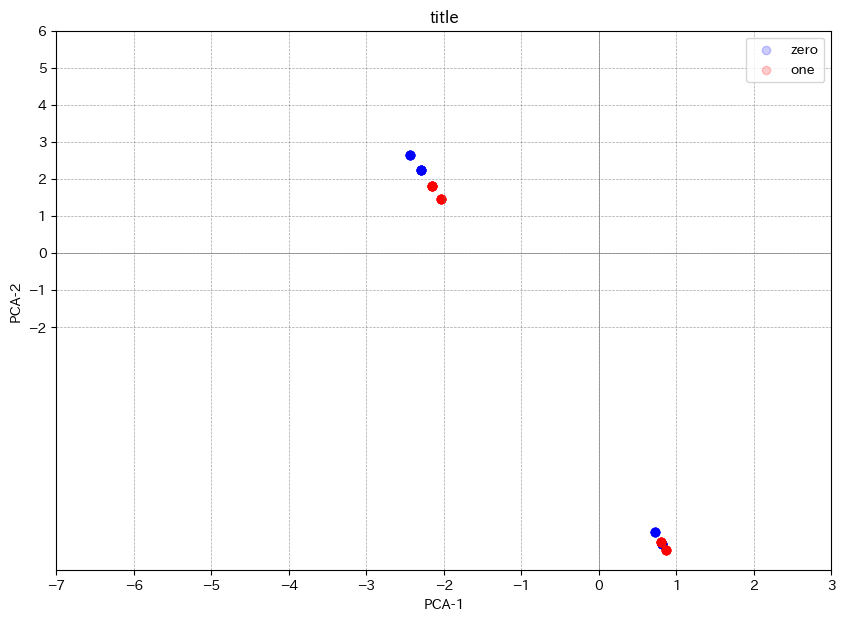

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


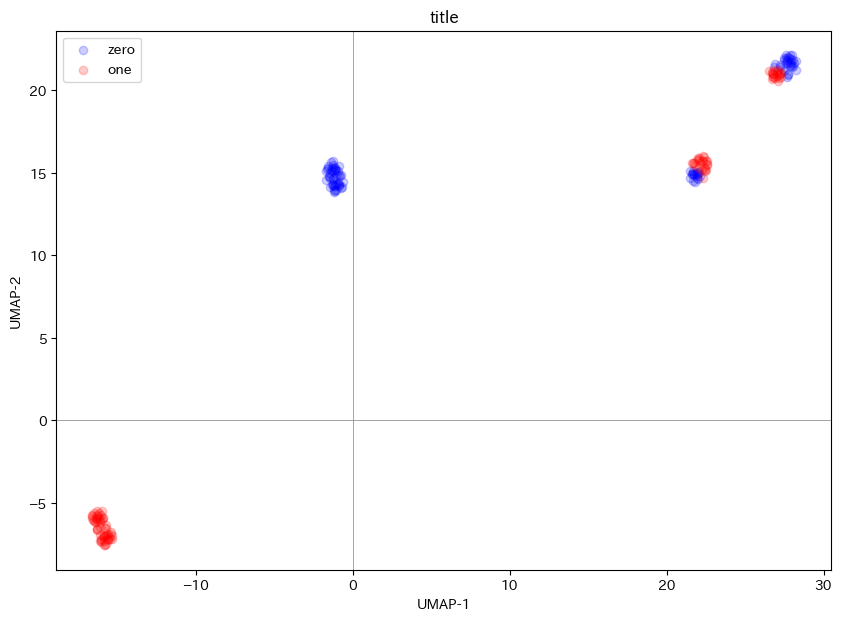

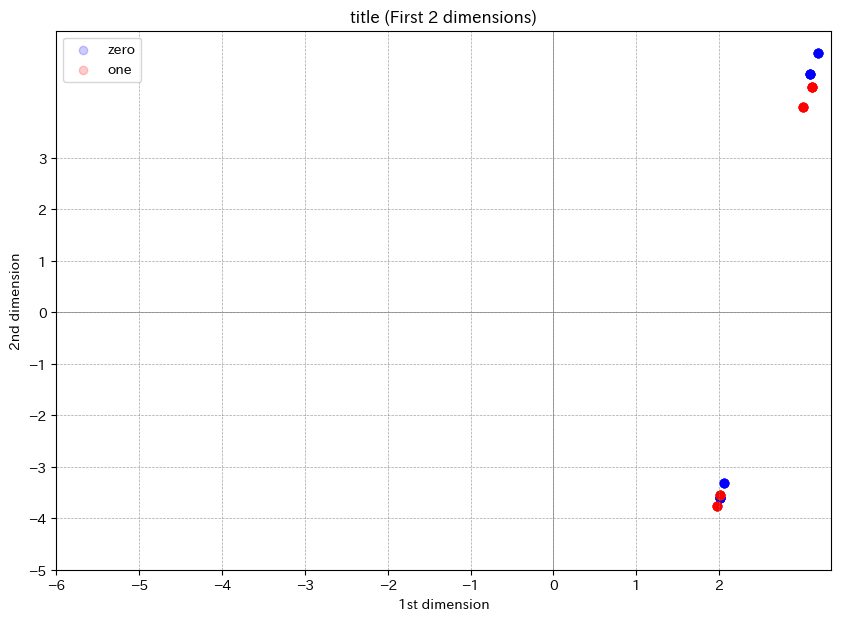

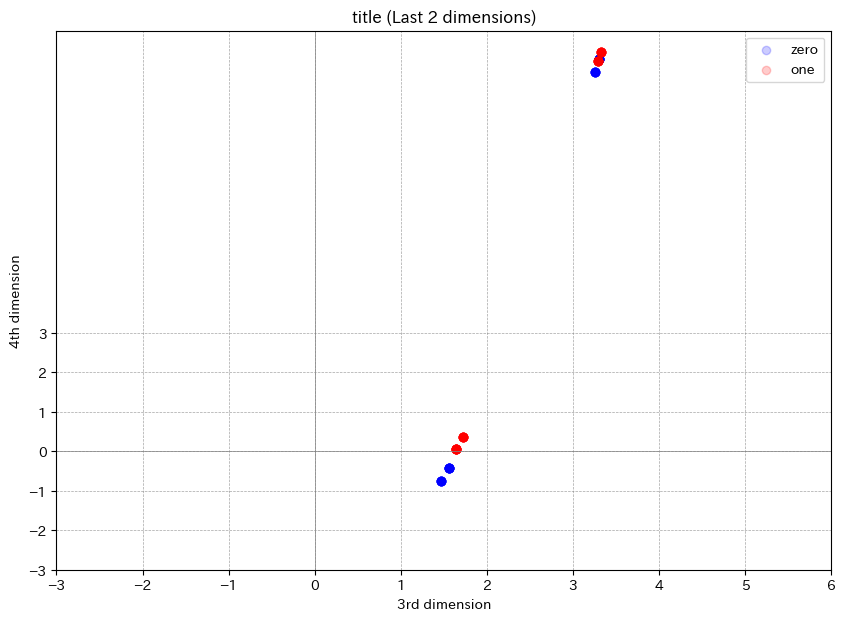

<Figure size 1000x500 with 0 Axes>

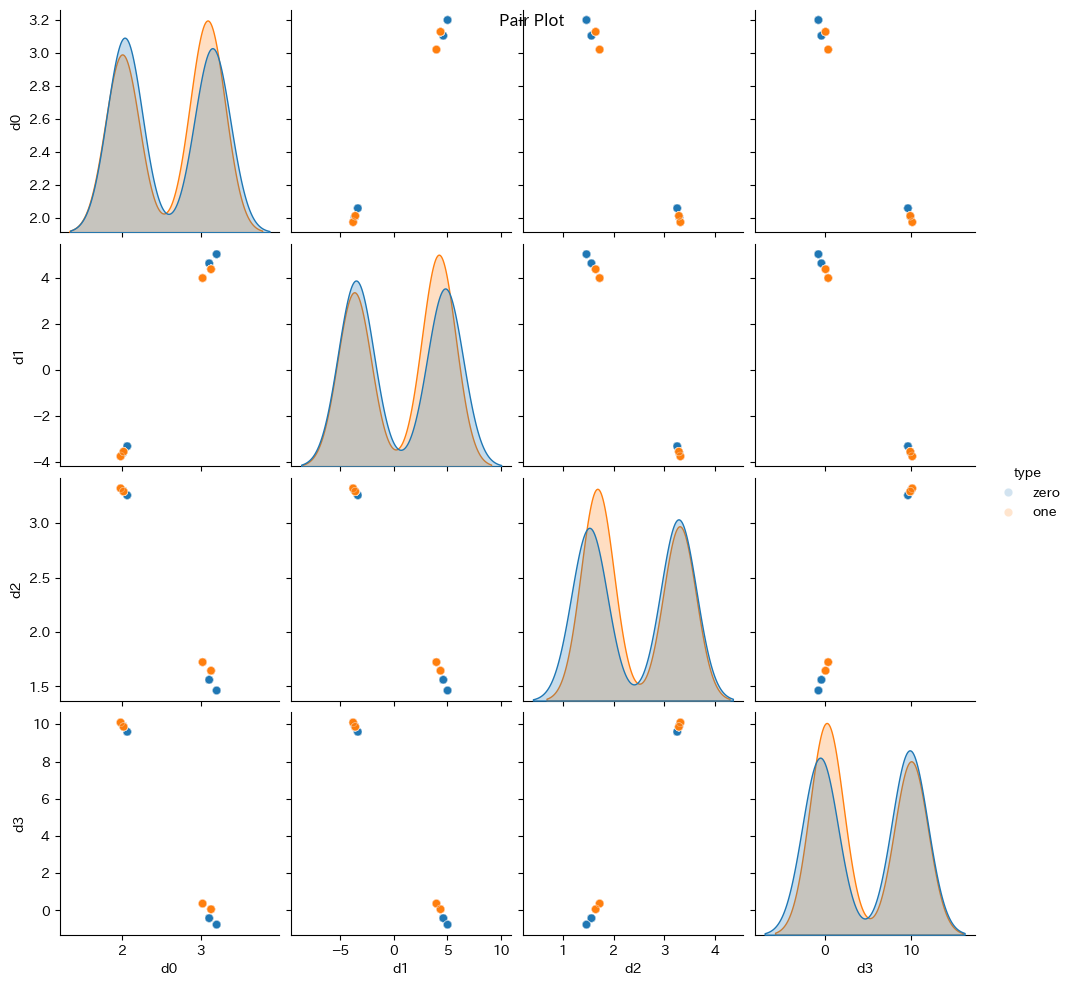

In [39]:
# Vw*memのindex4を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
        tgt = model.positional_encoding(model.token_embedding.embedding.weight[tgt] * math.sqrt(embedding_size))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # Cross Attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        VW = torch.matmul(VW, model.decoder_layer.cross_attn.out_proj.weight.data.T)
        index5 = VW[:, 2, :]
        vectors.append(index5.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array


# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False, n_neighbors=30)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)


#### Vw*Memがそれぞれ何を表しているかを示す

(100, 7, 4) (100, 3, 4) (100, 3, 7)


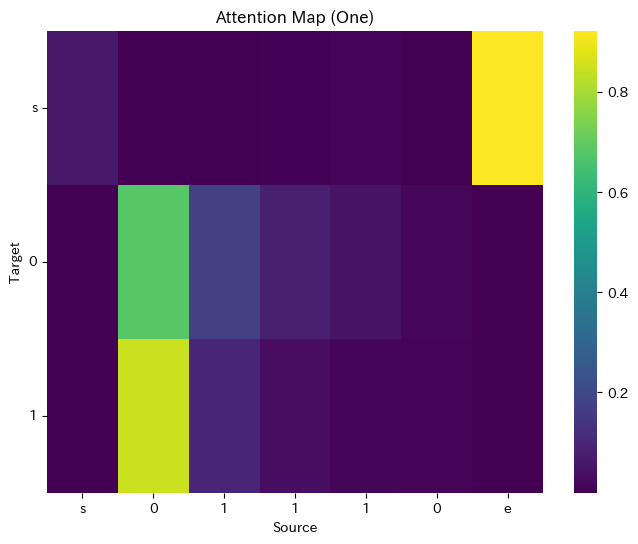

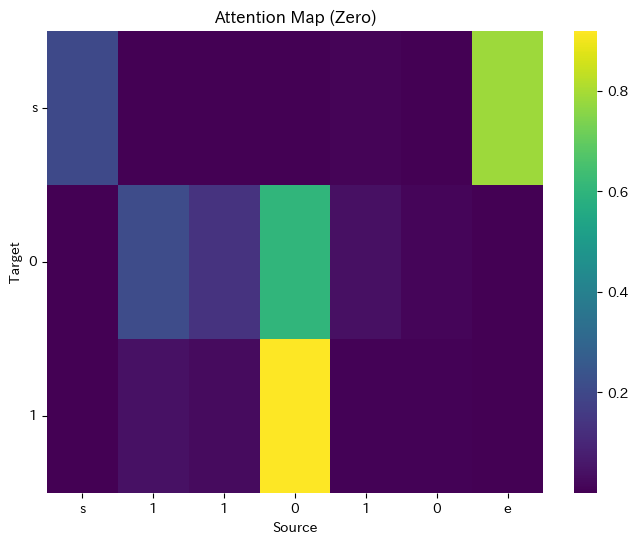

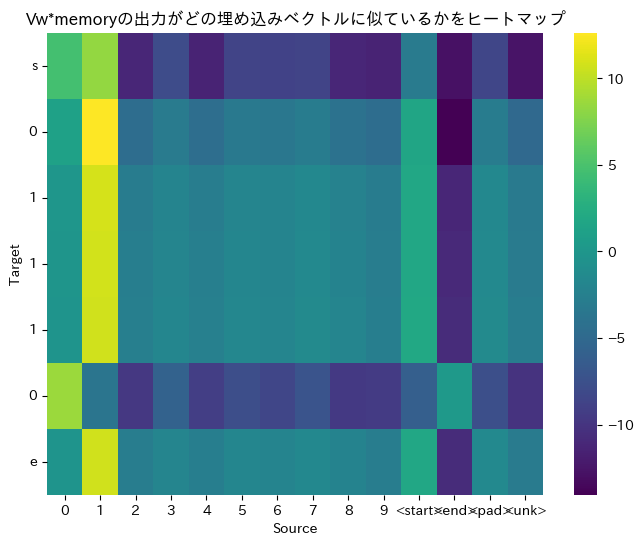

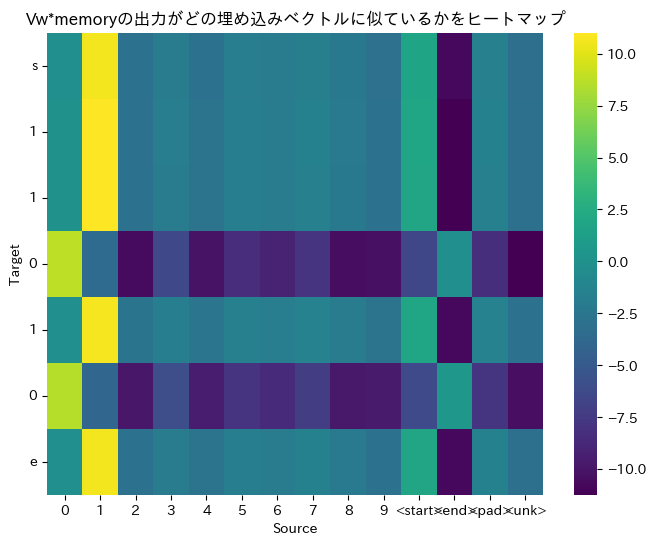

In [61]:
# 特にまとまっているOne-vectorについてVw*memを示す
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    VWxmems = []
    ca_vectors = []
    attn_maps = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # Cross Attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        VWxmem = torch.matmul(VW, model.decoder_layer.cross_attn.out_proj.weight.data.T)+ model.decoder_layer.cross_attn.out_proj.bias.data
        VWxmem = model.decoder_layer.norm2(VWxmem)
        VWxmems.append(VWxmem.detach().cpu().numpy().squeeze())

        _, ca, attn_map = model.cross_attn(tgt, memory, embedding_size)
        ca = model.decoder_layer.norm2(ca)
        ca_vectors.append(ca.detach().cpu().numpy().squeeze())
        attn_maps.append(attn_map.detach().cpu().numpy().squeeze())

    VWxmems = np.array(VWxmems)
    ca_vectors = np.array(ca_vectors)
    attn_maps = np.array(attn_maps)
    return VWxmems, ca_vectors, attn_maps

# 偶数と奇数のCross Attention後のベクトルリストを取得
VWxmems_one, ca_vectors_one, attn_maps_one = extract_vectors(one_src, loaded_model)
VWxmems_zero, ca_vectors_zero, attn_maps_zero = extract_vectors(zero_src, loaded_model)
print(VWxmems_one.shape, ca_vectors_one.shape, attn_maps_one.shape)

embedding_weight = loaded_model.token_embedding.embedding.weight.data.detach().cpu().numpy()
embedding_size = loaded_model.token_embedding.embedding_size
labels = [reverse_vocab[i] for i in range(0, len(reverse_vocab))]


# Attention mapを表示
plot_heatmap(attn_maps_one[0], title="Attention Map (One)", src_label="s"+one_data[0]+"e", ys_label="s01")
plot_heatmap(attn_maps_zero[0], title="Attention Map (Zero)", src_label="s"+zero_data[0]+"e", ys_label="s01")

similarity_one = np.matmul(VWxmems_one[0, :]/math.sqrt(embedding_size), embedding_weight.T)
similarity_zero = np.matmul(VWxmems_zero[0, :]/math.sqrt(embedding_size), embedding_weight.T)

plot_heatmap(similarity_one, title="Vw*memoryの出力がどの埋め込みベクトルに似ているかをヒートマップ", src_label=labels, ys_label="s"+one_data[0]+"e")
plot_heatmap(similarity_zero, title="Vw*memoryの出力がどの埋め込みベクトルに似ているかをヒートマップ", src_label=labels, ys_label="s"+zero_data[0]+"e")


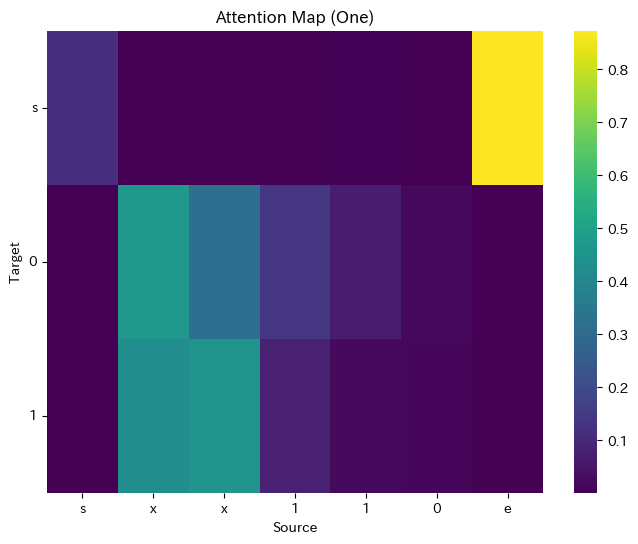

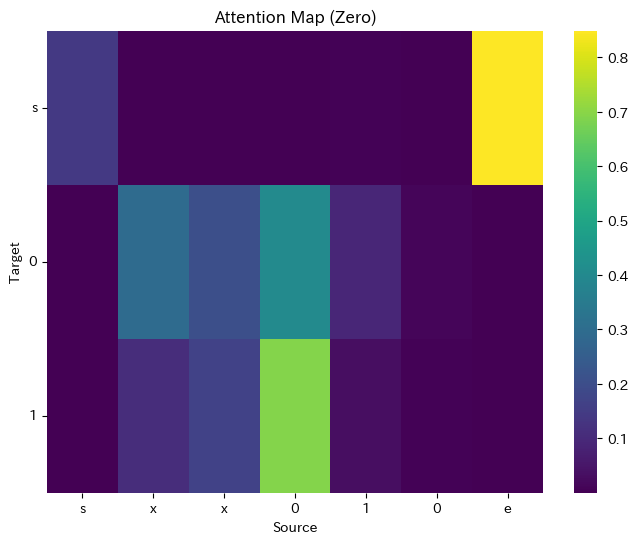

In [71]:

VWxmems_one, ca_vectors_one, attn_maps_one = VWxmems_one.mean(axis=0), ca_vectors_one.mean(axis=0), attn_maps_one.mean(axis=0)
VWxmems_zero, ca_vectors_zero, attn_maps_zero = VWxmems_zero.mean(axis=0), ca_vectors_zero.mean(axis=0), attn_maps_zero.mean(axis=0)

# Attention mapを表示
plot_heatmap(attn_maps_one, title="Attention Map (One)", src_label="sxx110e", ys_label="s01")
plot_heatmap(attn_maps_zero, title="Attention Map (Zero)", src_label="sxx010e", ys_label="s01")


(14, 4)
(7, 14) (7, 14)


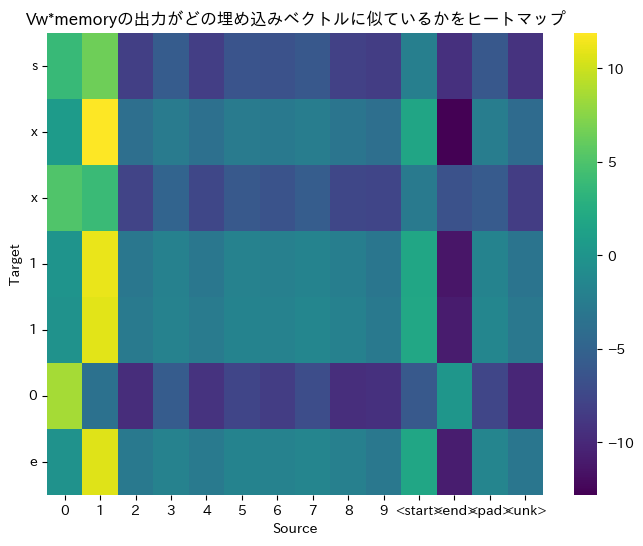

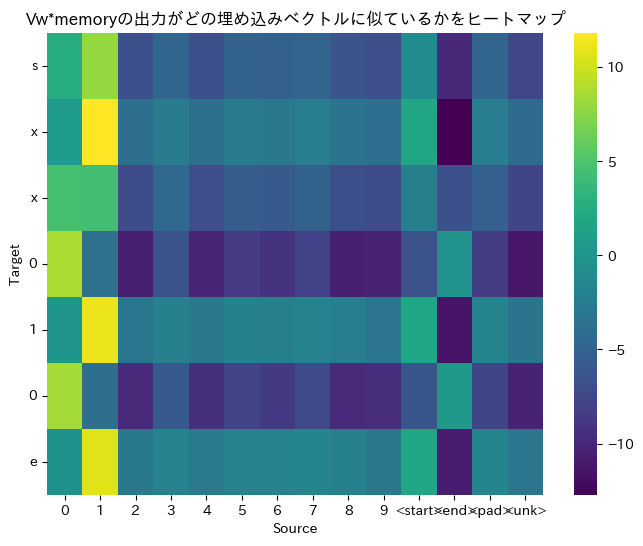

In [72]:

embedding_weight = loaded_model.token_embedding.embedding.weight.data.detach().cpu().numpy()
embedding_size = loaded_model.token_embedding.embedding_size
labels = [reverse_vocab[i] for i in range(0, len(reverse_vocab))]

# Vwxmemと埋め込みベクトルの類似度を計算
print(embedding_weight.shape)
similarity_one = np.matmul(VWxmems_one/math.sqrt(embedding_size), embedding_weight.T)
similarity_zero = np.matmul(VWxmems_zero/math.sqrt(embedding_size), embedding_weight.T)

print(similarity_one.shape, similarity_zero.shape)
plot_heatmap(similarity_one, title="Vw*memoryの出力がどの埋め込みベクトルに似ているかをヒートマップ", src_label=labels, ys_label="sxx110e")
plot_heatmap(similarity_zero, title="Vw*memoryの出力がどの埋め込みベクトルに似ているかをヒートマップ", src_label=labels, ys_label="sxx010e")

(14, 4)


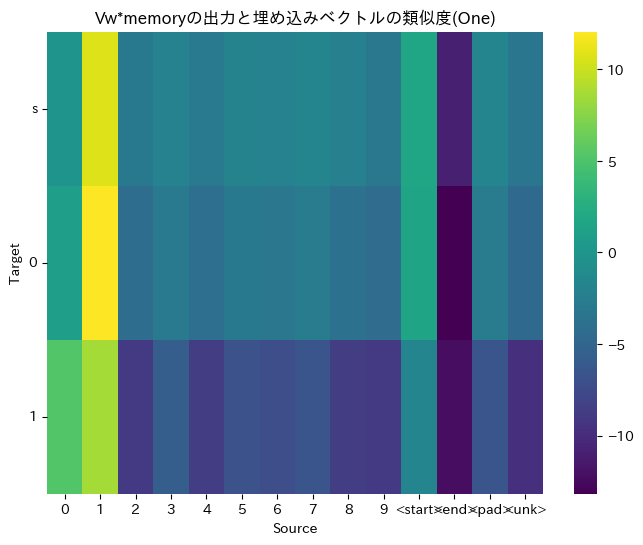

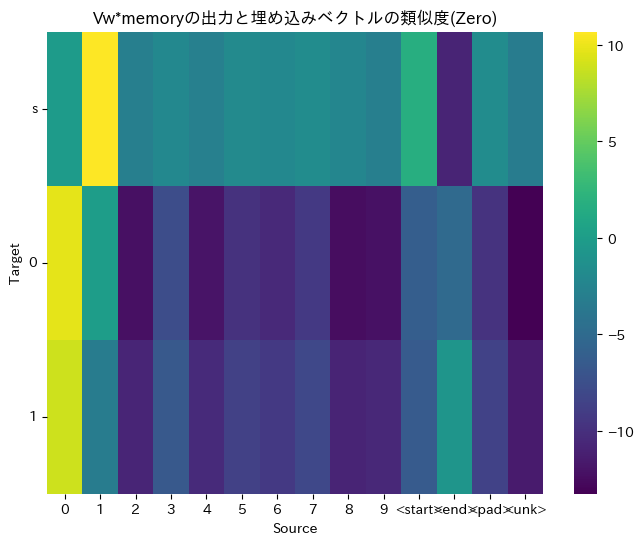

In [76]:
# CAの最終出力と埋め込みベクトルの類似度を計算
print(embedding_weight.shape)
similarity_one = np.matmul(ca_vectors_one/math.sqrt(embedding_size), embedding_weight.T)
similarity_zero = np.matmul(ca_vectors_zero/math.sqrt(embedding_size), embedding_weight.T)

plot_heatmap(similarity_one, title="Vw*memoryの出力と埋め込みベクトルの類似度(One)", src_label=labels, ys_label="s01")
plot_heatmap(similarity_zero, title="Vw*memoryの出力と埋め込みベクトルの類似度(Zero)", src_label=labels, ys_label="s01")

#### Cross-Attentionを図示

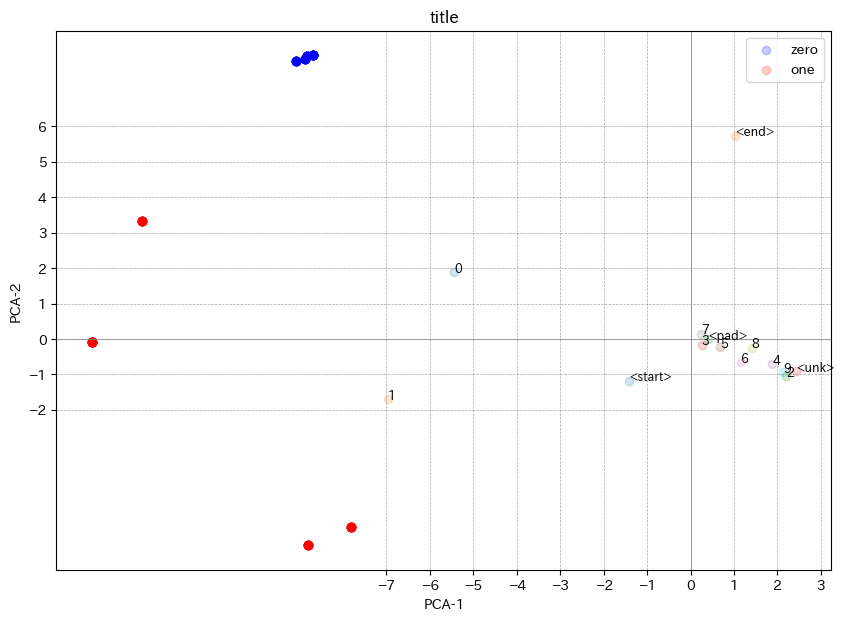

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


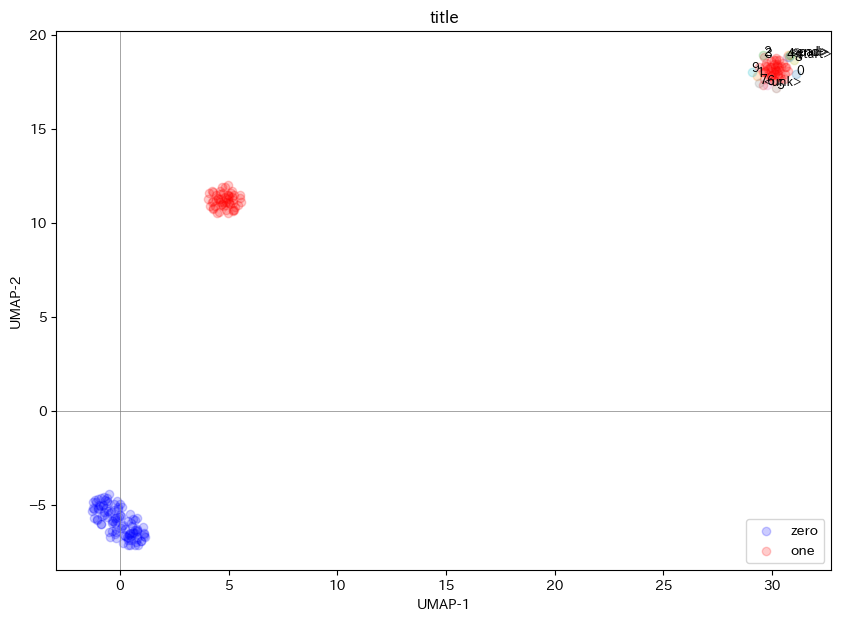

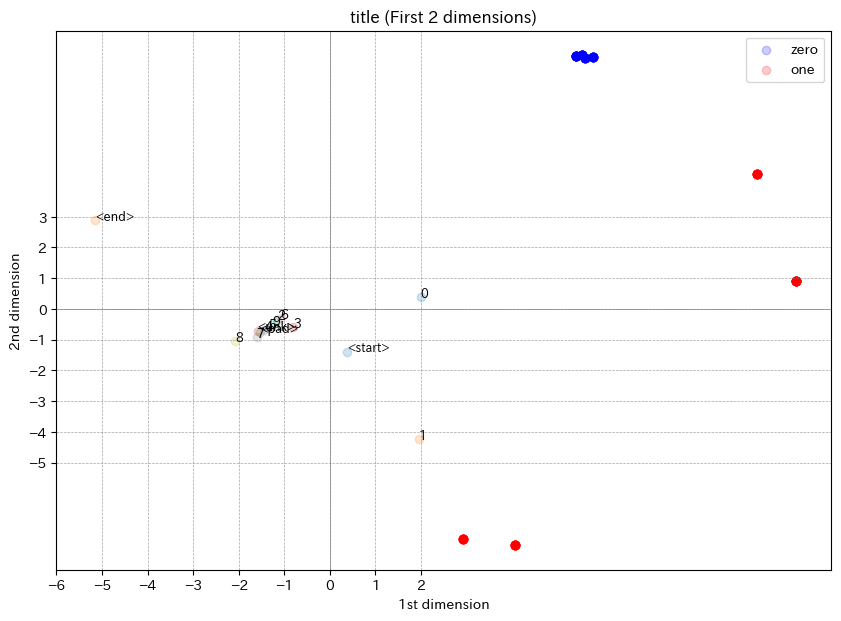

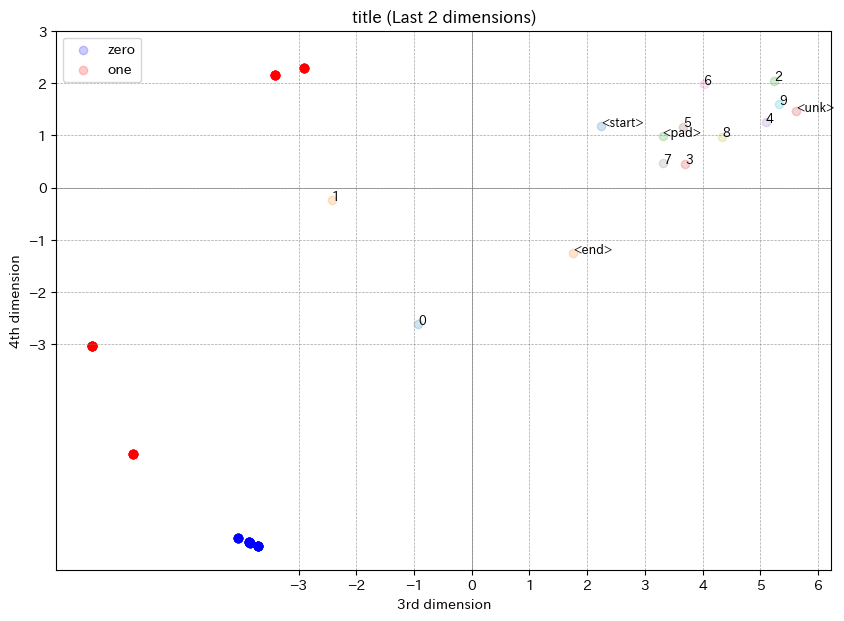

<Figure size 1000x500 with 0 Axes>

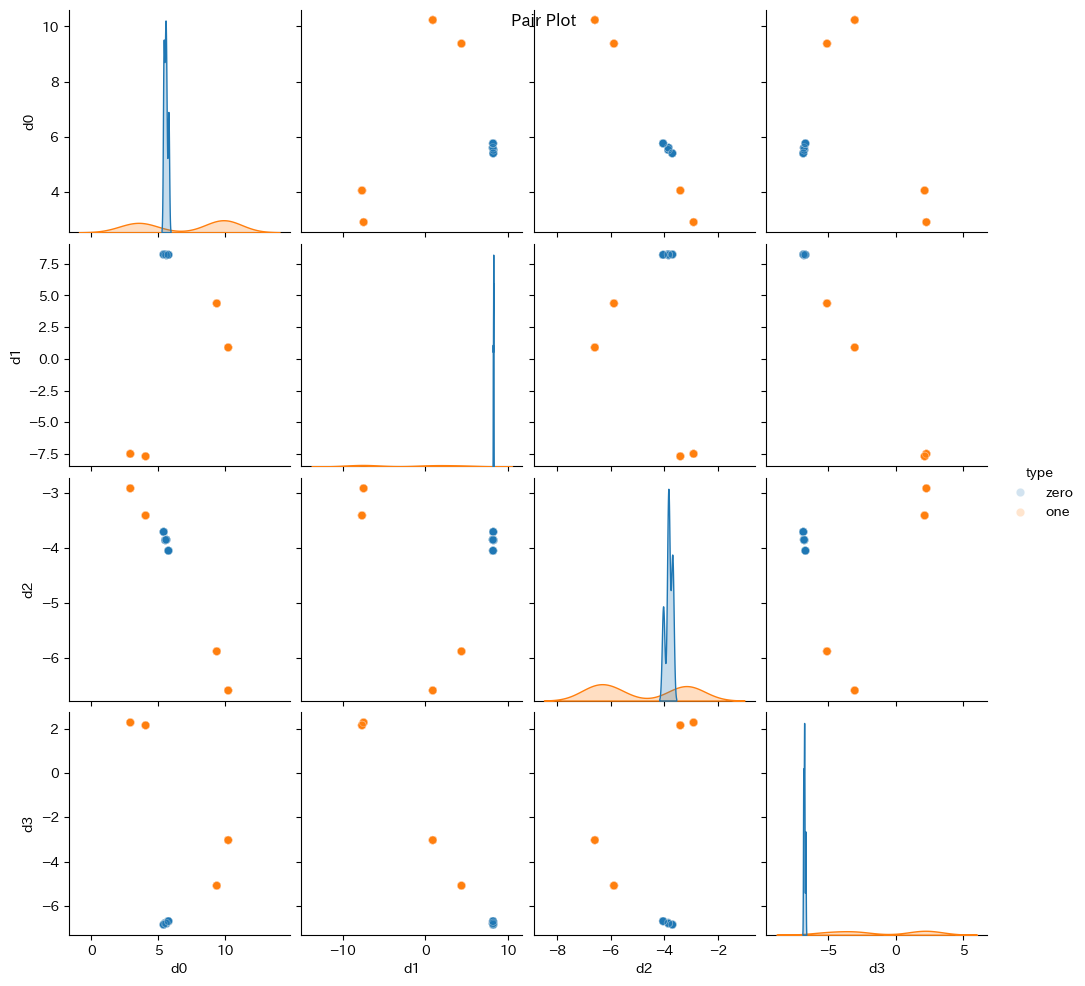

In [42]:

# Cross Attention後の出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        _, tgt, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt[:, -1])
        vectors.append(tgt.transpose(0, 1)[:, -1].detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True, n_neighbors=50)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

#### Cross-Attention + yを図示

(100, 4) (100, 4)


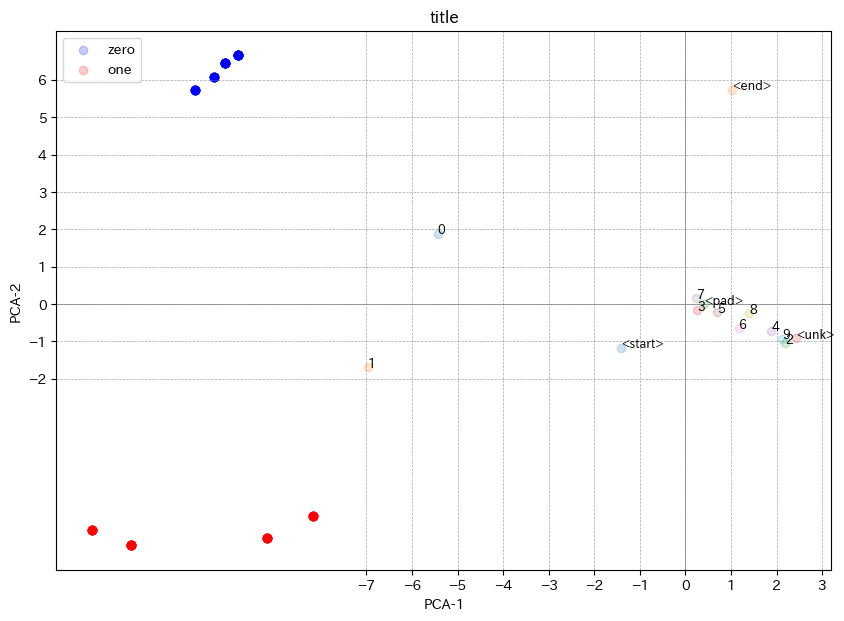

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


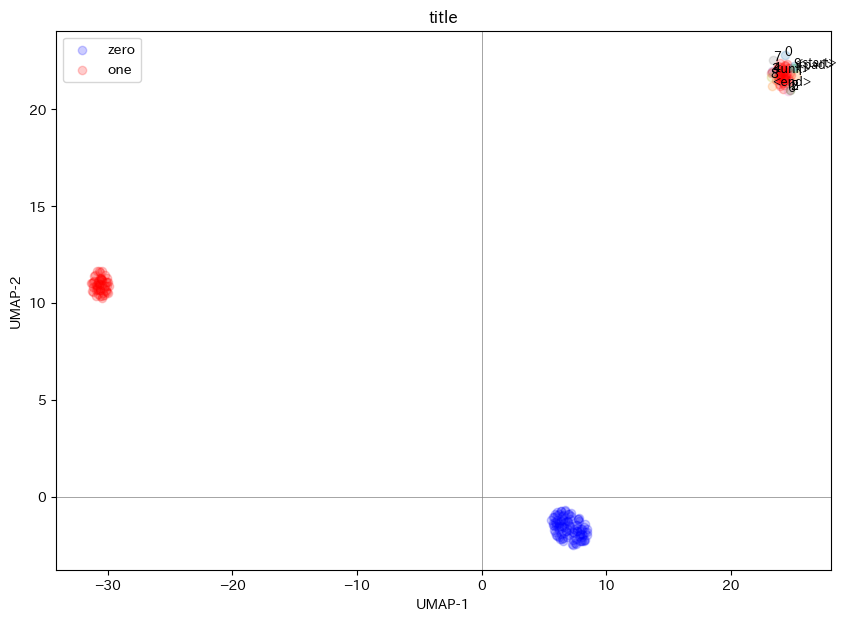

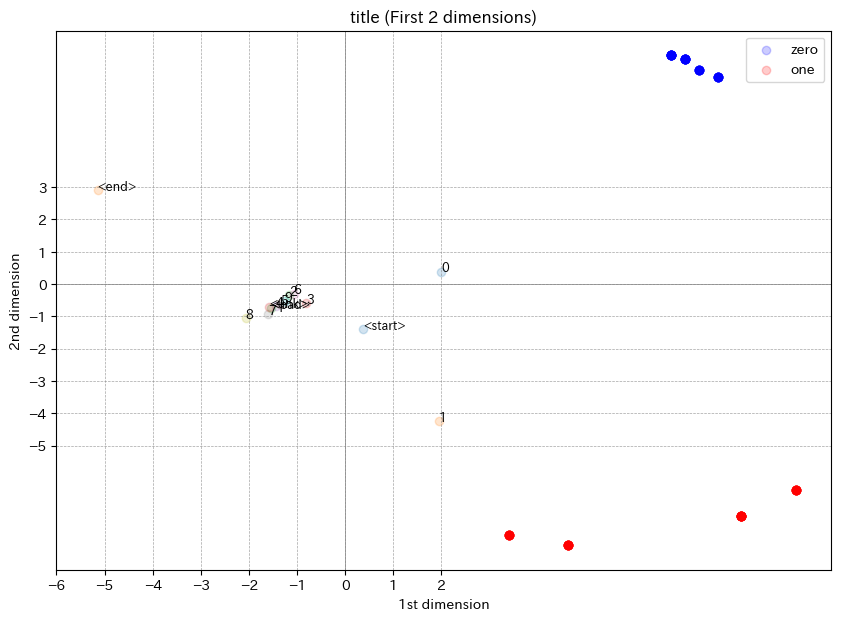

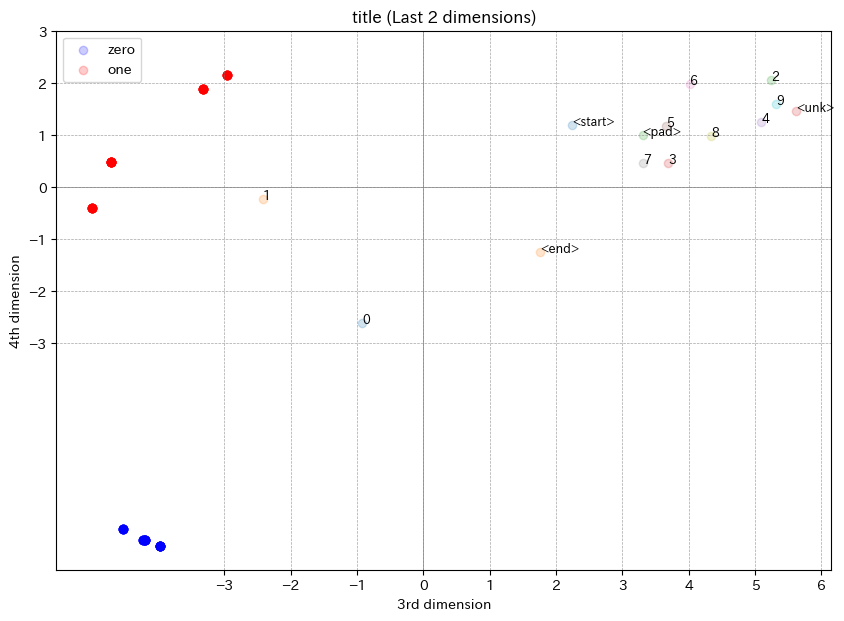

<Figure size 1000x500 with 0 Axes>

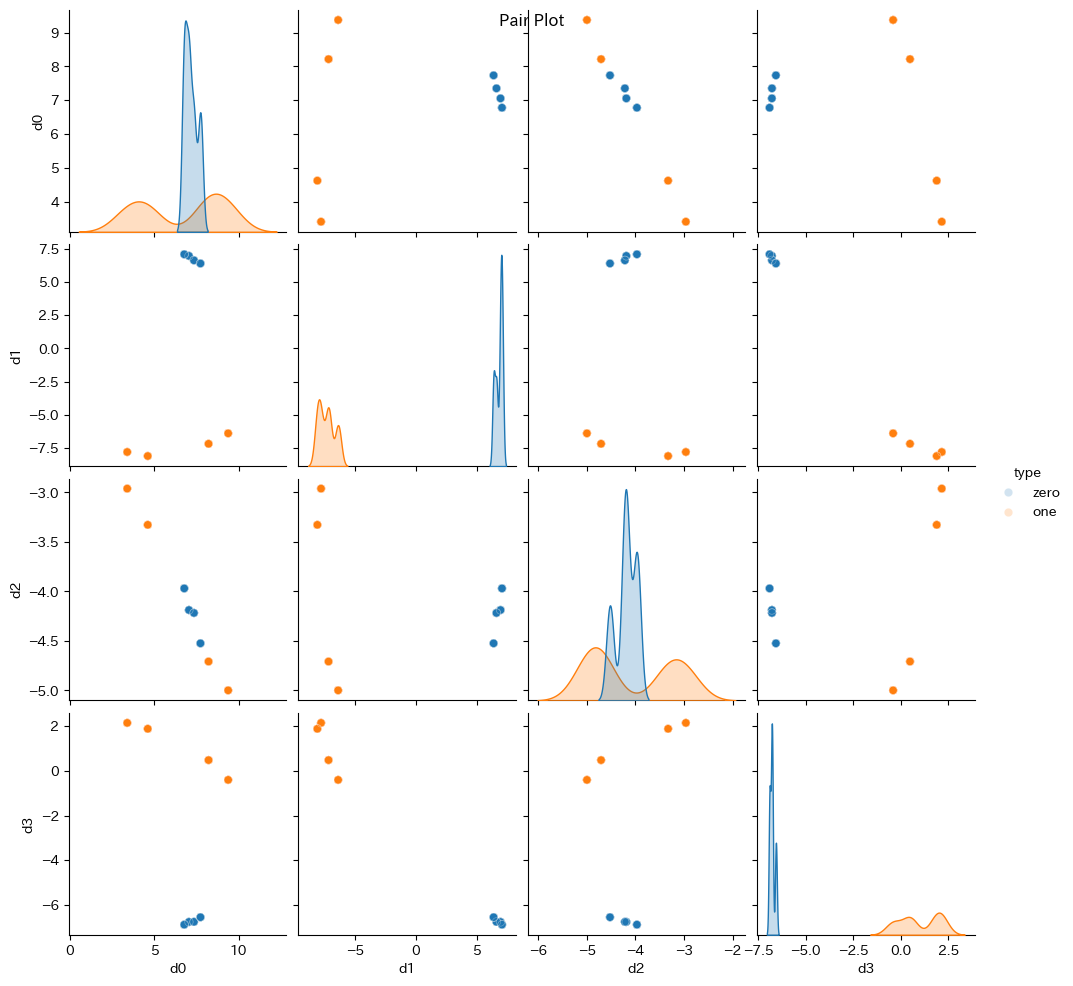

In [43]:

# Cross Attention後の出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt[:, -1])
        vectors.append(tgt.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)[:, -1, :]
one_vectors_ca = extract_vectors(one_src, loaded_model)[:, -1, :]
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_umap_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True, n_neighbors=50)
plot_map_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

#### 最終の確率を図示

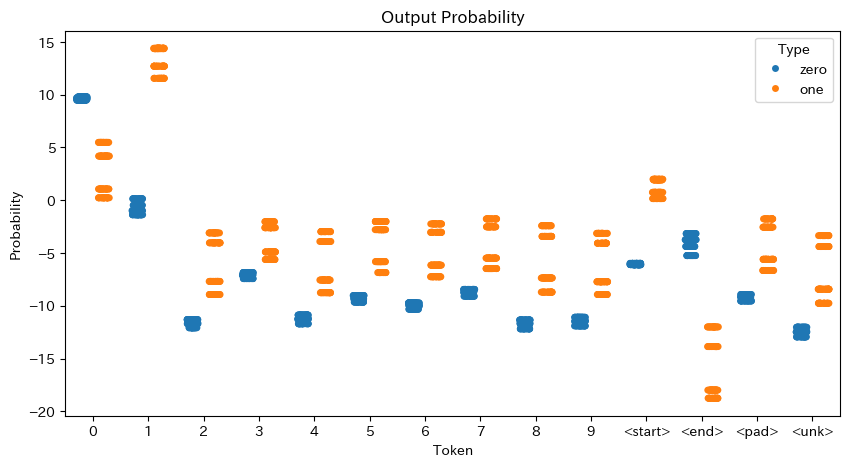

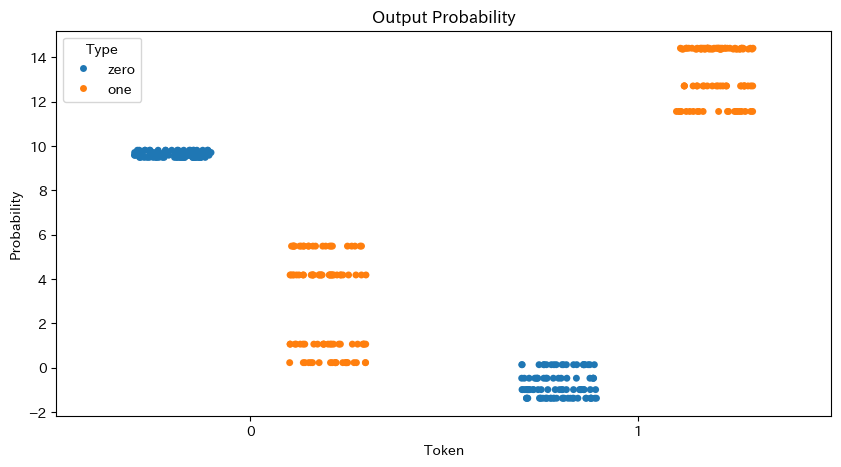

In [44]:
# 結果の出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt)
        output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(output.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
plot_stripplot(zero_vectors_ca, one_vectors_ca)
plot_stripplot(zero_vectors_ca[:, :2], one_vectors_ca[:, :2])

# margin